# Approach Adapted from "An emotion-driven, transformer-based network for multimodal fake news detection" by Yadav and Gupta (2024), but for unimodal datasets first

**Reference:** Ashima Yadav and Anika Gupta. 2024. An emotion-driven, transformer-based network for multimodal fake news detection. Int J Multimed Info Retr 13, 1 (March 2024), 7. https://doi.org/10.1007/s13735-023-00315-3

## Environment Setup

In [1]:
# Imports basic libraries
import os # For file loading & saving functionality
import re # For regex to apply the text cleaning functionality
import time # For measuring how long embedding generation takes
import pandas as pd
import numpy as np
from tqdm.auto import tqdm # For progress monitoring with pandas .progress_apply
tqdm.pandas()
# Plotting libraries for generating the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Transformers and TensorFlow DistilBERT-loading functions
# Reference: https://medium.com/towards-data-science/tensorflow-and-transformers-df6fceaf57cc
from transformers import TFAutoModel, AutoTokenizer
# For creating the Dense layer Keras classification head
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Input, Dense, 
    Dropout, Flatten, concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# For emotions feature extraction
from nrclex import NRCLex
# For emoji extraction
import emoji
# For emoji sentiment scoring
# Reference: https://github.com/omkar-foss/emosent-py
from emosent import get_emoji_sentiment_rank

# For Passive-Aggressive Clasisifer model training, optimization, feature scaling and classifier evaluation
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import GridSearchCV
# Imports eval metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# Imports scaler for extra features
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Sets up the root path for loading datasets with text and extra engineered features
root_path = "../../FPData/BasicFeatureExtractionDFs/"

In [55]:
# WELFake
# Sets up the paths to the WELFake train and validation csv files
wf_train_path = os.path.join(root_path, "WELFake_train_basic_features.csv")
wf_val_path = os.path.join(root_path, "WELFake_val_basic_features.csv")
wf_test_path = os.path.join(root_path, "WELFake_test_basic_features.csv")

# Reads in the training and validation WELFake sets as pandas DataFrames
wf_train_df = pd.read_csv(wf_train_path)
wf_val_df = pd.read_csv(wf_val_path)
wf_test_df = pd.read_csv(wf_test_path)

In [56]:
print(len(wf_train_df), len(wf_val_df), len(wf_test_df))

41560 9325 11237


In [3]:
# Fakeddit
fe_train_path = os.path.join(root_path, "Fakeddit_train_basic_features.csv")
fe_val_path = os.path.join(root_path, "Fakeddit_val_basic_features.csv")
fe_test_path = os.path.join(root_path, "Fakeddit_test_basic_features.csv")

fe_train_df = pd.read_csv(fe_train_path)
fe_val_df = pd.read_csv(fe_val_path)
fe_test_df = pd.read_csv(fe_test_path)

In [4]:
print(len(fe_train_df), len(fe_val_df), len(fe_test_df))

648076 70332 71095


In [4]:
# Constraint
ct_train_path = os.path.join(root_path, "Constraint_train_basic_features.csv")
ct_val_path = os.path.join(root_path, "Constraint_val_basic_features.csv")
ct_test_path = os.path.join(root_path, "Constraint_test_basic_features.csv")

ct_train_df = pd.read_csv(ct_train_path)
ct_val_df = pd.read_csv(ct_val_path)
ct_test_df = pd.read_csv(ct_test_path)

In [5]:
print(len(ct_train_df), len(ct_val_df), len(ct_test_df))

6376 2128 2122


In [4]:
# PolitiFact
pf_train_path = os.path.join(root_path, "PolitiFact_train_basic_features.csv")
pf_val_path = os.path.join(root_path, "PolitiFact_val_basic_features.csv")
pf_test_path = os.path.join(root_path, "PolitiFact_test_basic_features.csv")

pf_train_df = pd.read_csv(pf_train_path)
pf_val_df = pd.read_csv(pf_val_path)
pf_test_df = pd.read_csv(pf_test_path)

In [5]:
print(len(pf_train_df), len(pf_val_df), len(pf_test_df))

436 104 126


In [3]:
# GossipCop
gc_train_path = os.path.join(root_path, "GossipCop_train_basic_features.csv")
gc_val_path = os.path.join(root_path, "GossipCop_val_basic_features.csv")
gc_test_path = os.path.join(root_path, "GossipCop_test_basic_features.csv")

gc_train_df = pd.read_csv(gc_train_path)
gc_val_df = pd.read_csv(gc_val_path)
gc_test_df = pd.read_csv(gc_test_path)

In [4]:
print(len(gc_train_df), len(gc_val_df), len(gc_test_df))

11042 2630 3199


In [3]:
# All-Four Combined
all_four_train_path = os.path.join(root_path, "all_four_datasets_train_basic_features.csv")
all_four_val_path = os.path.join(root_path, "all_four_datasets_val_basic_features.csv")
all_four_test_path = os.path.join(root_path, "all_four_datasets_test_basic_features.csv")

all_four_train_df = pd.read_csv(all_four_train_path)
all_four_val_df = pd.read_csv(all_four_val_path)
all_four_test_df = pd.read_csv(all_four_test_path)

In [4]:
print(len(all_four_train_df), len(all_four_val_df), len(all_four_test_df))

59414 14187 16683


In [127]:
# Five-shot: WELFake target training data
wf_target_five_shot_train_basic_feature_df =  pd.read_csv(os.path.join(root_path, "Five_Shot_WELFake_Target_basic_features.csv"))

In [128]:
print(len(wf_target_five_shot_train_basic_feature_df))

17857


In [8]:
# Five-shot: Constraint target training data
ct_target_five_shot_train_basic_feature_df = pd.read_csv(os.path.join(root_path, "Five_Shot_Constraint_Target_basic_features.csv"))

In [9]:
print(len(ct_target_five_shot_train_basic_feature_df))

53041


In [6]:
# Five-shot: PolitiFact target training data
pf_target_five_shot_train_basic_feature_df = pd.read_csv(os.path.join(root_path, "Five_Shot_PolitiFact_Target_basic_features.csv"))

In [7]:
print(len(pf_target_five_shot_train_basic_feature_df))

58983


In [5]:
# Five-shot: GossipCop target training data
gc_target_five_shot_train_basic_feature_df = pd.read_csv(os.path.join(root_path, "Five_Shot_GossipCop_Target_basic_features.csv"))

In [6]:
print(len(gc_target_five_shot_train_basic_feature_df))

48377


In [129]:
# Zero-shot: WELFake target training data
wf_target_zero_shot_train_basic_feature_df =  pd.read_csv(os.path.join(root_path, "Zero_Shot_WELFake_Target_basic_features.csv"))

In [130]:
print(len(wf_target_zero_shot_train_basic_feature_df))

17852


In [10]:
# Zero-shot: Constraint target training data
ct_target_zero_shot_train_basic_feature_df =  pd.read_csv(os.path.join(root_path, "Zero_Shot_Constraint_Target_basic_features.csv"))

In [11]:
print(len(ct_target_zero_shot_train_basic_feature_df))

53036


In [8]:
# Zero-shot: PolitiFact target training data
pf_target_zero_shot_train_basic_feature_df =  pd.read_csv(os.path.join(root_path, "Zero_Shot_PolitiFact_Target_basic_features.csv"))

In [9]:
print(len(pf_target_zero_shot_train_basic_feature_df))

58978


In [7]:
# Zero-shot: GossipCop target training data
gc_target_zero_shot_train_basic_feature_df =  pd.read_csv(os.path.join(root_path, "Zero_Shot_GossipCop_Target_basic_features.csv"))

In [8]:
print(len(gc_target_zero_shot_train_basic_feature_df))

48372


## Preprocessing Text for DistilBERT Embedding Extraction

In [5]:
# Text cleaning and pre-processing in preparation for DistilBERT embeddings
# For DistilBERT and other transformers, tokenization or lemmatization is not necessary as this is handled
# by the transformers library
# However, it is necessary to remove things like redundant newline characters and trailing whitespace, as well
# as HTML tags and URLs
# Lowercasing will be applied as DistilBERT/BERT-uncased used in the Yadav and Gupta study expects no capital letters
# Reference: https://medium.com/@prakashram1327/building-a-text-classification-model-using-distilbert-703c1409696c

def cleanTextForDistilBERT(text):
    """
    Takes in a text string and applies RegEx to clean from redundant whitespace and other special strings such
    as HTML tags. Lowercases the text in preparation for the uncased transformer model.
    Reference for code this is based on: 
        https://medium.com/@prakashram1327/building-a-text-classification-model-using-distilbert-703c1409696c
        
        Input Parameters:
            text (str): the text to be cleaned
        Output:
            text (str): the now cleaned text
    """
    # Lowercases the text
    text = text.lower()
    # Removes HTML tags
    text = re.sub(r"<.*?>", '', text)
    # Removes URLs starting with http
    text = re.sub(r"http\S+", '', text)
    # Removes other URLs. Reference: https://uibakery.io/regex-library/url-regex-python
    text = re.sub(r"^[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*)$",
                  '', text)
    # Removes email addresses, reference: https://uibakery.io/regex-library/email-regex-python
    text = re.sub(r"^[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*@(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?$" ,
                  '', text)  
    # Removes phone numbers (basic 10-digit format). Reference: https://uibakery.io/regex-library/phone-number-python
    text = re.sub("^\\+?[1-9][0-9]{7,14}$",
                  '', text)  
    # Removes trailing spaces and replace with single space
    text = re.sub(r"\s+", " ", text).strip()
    return text


def removeEmptyRows(df, text_column_name="clean_text"):
    """
    Removes rows where the "text" column's value is empty or contains only whitespace.
    This could be the case after regular expression cleaning!
        
        Input Parameters:
            df (pandas.DataFrame): The DataFrame to clean.
            text_column_name (str): The column name containing the text data. The default is "text".
            
        Output:
            df (pandas.DataFrame): The cleaned dataframe with rows where "text" is empty removed.
    """
    
    # Strips whitespace from text entry using the .str method --> uses ".ne" = not equal to determine if
    # text is not equal to an empty string after stripping any trailing whitespace
    # Reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ne.html
    df = df[df[text_column_name].str.strip().ne('')]

    return df

In [60]:
# Applies the above cleaning functions to the WELFake datasets
wf_train_df["cleaned_text_for_distilbert"] = wf_train_df["text"].progress_apply(cleanTextForDistilBERT)
wf_val_df["cleaned_text_for_distilbert"] = wf_val_df["text"].progress_apply(cleanTextForDistilBERT)
wf_test_df["cleaned_text_for_distilbert"] = wf_test_df["text"].progress_apply(cleanTextForDistilBERT)

print(f"Length of training set before removing empty rows: {len(wf_train_df)}, length of validation set: {len(wf_val_df)}, length of test set: {len(wf_test_df)}")

# Removes any rows with empty strings following regex cleaning and whitespace stripping
wf_train_df = removeEmptyRows(wf_train_df, text_column_name = "cleaned_text_for_distilbert")
wf_val_df = removeEmptyRows(wf_val_df, text_column_name = "cleaned_text_for_distilbert")
wf_test_df = removeEmptyRows(wf_test_df, text_column_name = "cleaned_text_for_distilbert")

print(f"Length of training set after removing empty rows: {len(wf_train_df)}, length of validation set: {len(wf_val_df)}, length of test set: {len(wf_test_df)}")

# Saves the clean text DataFrames as .csv files
wf_train_df.to_csv("../../FPData/EmotionApproach/wf_train_df_cleaned_for_distilbert.csv")
wf_val_df.to_csv("../../FPData/EmotionApproach/wf_val_df_cleaned_for_distilbert.csv")
wf_test_df.to_csv("../../FPData/EmotionApproach/wf_test_df_cleaned_for_distilbert.csv")

  0%|          | 0/41560 [00:00<?, ?it/s]

  0%|          | 0/9325 [00:00<?, ?it/s]

  0%|          | 0/11237 [00:00<?, ?it/s]

Length of training set before removing empty rows: 41560, length of validation set: 9325, length of test set: 11237
Length of training set after removing empty rows: 41560, length of validation set: 9325, length of test set: 11237


In [8]:
# Applies the above cleaning functions to the Fakeddit datasets
fe_train_df["cleaned_text_for_distilbert"] = fe_train_df["text"].progress_apply(cleanTextForDistilBERT)
fe_val_df["cleaned_text_for_distilbert"] = fe_val_df["text"].progress_apply(cleanTextForDistilBERT)
fe_test_df["cleaned_text_for_distilbert"] = fe_test_df["text"].progress_apply(cleanTextForDistilBERT)

print(f"Length of training set before removing empty rows: {len(fe_train_df)}, length of validation set: {len(fe_val_df)}, length of test set: {len(fe_test_df)}")

# Removes any rows with empty strings following regex cleaning and whitespace stripping
fe_train_df = removeEmptyRows(fe_train_df, text_column_name = "cleaned_text_for_distilbert")
fe_val_df = removeEmptyRows(fe_val_df, text_column_name = "cleaned_text_for_distilbert")
fe_test_df = removeEmptyRows(fe_test_df, text_column_name = "cleaned_text_for_distilbert")

print(f"Length of training set after removing empty rows: {len(fe_train_df)}, length of validation set: {len(fe_val_df)}, length of test set: {len(fe_test_df)}")

# Saves the clean text DataFrames as .csv files
fe_train_df.to_csv("../../FPData/EmotionApproach/fe_train_df_cleaned_for_distilbert.csv")
fe_val_df.to_csv("../../FPData/EmotionApproach/fe_val_df_cleaned_for_distilbert.csv")
fe_test_df.to_csv("../../FPData/EmotionApproach/fe_test_df_cleaned_for_distilbert.csv")

  0%|          | 0/648076 [00:00<?, ?it/s]

  0%|          | 0/70332 [00:00<?, ?it/s]

  0%|          | 0/71095 [00:00<?, ?it/s]

Length of training set before removing empty rows: 648076, length of validation set: 70332, length of test set: 71095
Length of training set before removing empty rows: 648075, length of validation set: 70330, length of test set: 71095


In [17]:
# Applies the above cleaning functions to the Constraint datasets
ct_train_df["cleaned_text_for_distilbert"] = ct_train_df["text"].progress_apply(cleanTextForDistilBERT)
ct_val_df["cleaned_text_for_distilbert"] = ct_val_df["text"].progress_apply(cleanTextForDistilBERT)
ct_test_df["cleaned_text_for_distilbert"] = ct_test_df["text"].progress_apply(cleanTextForDistilBERT)

print(f"Length of training set before removing empty rows: {len(ct_train_df)}, length of validation set: {len(ct_val_df)}, length of test set: {len(ct_test_df)}")

# Removes any rows with empty strings following regex cleaning and whitespace stripping
ct_train_df = removeEmptyRows(ct_train_df, text_column_name = "cleaned_text_for_distilbert")
ct_val_df = removeEmptyRows(ct_val_df, text_column_name = "cleaned_text_for_distilbert")
ct_test_df = removeEmptyRows(ct_test_df, text_column_name = "cleaned_text_for_distilbert")

print(f"Length of training set after removing empty rows: {len(ct_train_df)}, length of validation set: {len(ct_val_df)}, length of test set: {len(ct_test_df)}")

# Saves the clean text DataFrames as .csv files
ct_train_df.to_csv("../../FPData/EmotionApproach/ct_train_df_cleaned_for_distilbert.csv")
ct_val_df.to_csv("../../FPData/EmotionApproach/ct_val_df_cleaned_for_distilbert.csv")
ct_test_df.to_csv("../../FPData/EmotionApproach/ct_test_df_cleaned_for_distilbert.csv")

  0%|          | 0/6376 [00:00<?, ?it/s]

  0%|          | 0/2128 [00:00<?, ?it/s]

  0%|          | 0/2122 [00:00<?, ?it/s]

Length of training set before removing empty rows: 6376, length of validation set: 2128, length of test set: 2122
Length of training set before removing empty rows: 6376, length of validation set: 2128, length of test set: 2122


In [11]:
# Applies the above cleaning functions to the PolitiFact datasets
pf_train_df["cleaned_text_for_distilbert"] = pf_train_df["text"].progress_apply(cleanTextForDistilBERT)
pf_val_df["cleaned_text_for_distilbert"] = pf_val_df["text"].progress_apply(cleanTextForDistilBERT)
pf_test_df["cleaned_text_for_distilbert"] = pf_test_df["text"].progress_apply(cleanTextForDistilBERT)

print(f"Length of training set before removing empty rows: {len(pf_train_df)}, length of validation set: {len(pf_val_df)}, length of test set: {len(pf_test_df)}")

# Removes any rows with empty strings following regex cleaning and whitespace stripping
pf_train_df = removeEmptyRows(pf_train_df, text_column_name = "cleaned_text_for_distilbert")
pf_val_df = removeEmptyRows(pf_val_df, text_column_name = "cleaned_text_for_distilbert")
pf_test_df = removeEmptyRows(pf_test_df, text_column_name = "cleaned_text_for_distilbert")

print(f"Length of training set after removing empty rows: {len(pf_train_df)}, length of validation set: {len(pf_val_df)}, length of test set: {len(pf_test_df)}")

# Saves the clean text DataFrames as .csv files
pf_train_df.to_csv("../../FPData/EmotionApproach/pf_train_df_cleaned_for_distilbert.csv")
pf_val_df.to_csv("../../FPData/EmotionApproach/pf_val_df_cleaned_for_distilbert.csv")
pf_test_df.to_csv("../../FPData/EmotionApproach/pf_test_df_cleaned_for_distilbert.csv")

  0%|          | 0/436 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Length of training set before removing empty rows: 436, length of validation set: 104, length of test set: 126
Length of training set before removing empty rows: 436, length of validation set: 104, length of test set: 126


In [10]:
# Applies the above cleaning functions to the GossipCop datasets
gc_train_df["cleaned_text_for_distilbert"] = gc_train_df["text"].progress_apply(cleanTextForDistilBERT)
gc_val_df["cleaned_text_for_distilbert"] = gc_val_df["text"].progress_apply(cleanTextForDistilBERT)
gc_test_df["cleaned_text_for_distilbert"] = gc_test_df["text"].progress_apply(cleanTextForDistilBERT)

print(f"Length of training set before removing empty rows: {len(gc_train_df)}, length of validation set: {len(gc_val_df)}, length of test set: {len(gc_test_df)}")

# Removes any rows with empty strings following regex cleaning and whitespace stripping
gc_train_df = removeEmptyRows(gc_train_df, text_column_name = "cleaned_text_for_distilbert")
gc_val_df = removeEmptyRows(gc_val_df, text_column_name = "cleaned_text_for_distilbert")
gc_test_df = removeEmptyRows(gc_test_df, text_column_name = "cleaned_text_for_distilbert")

print(f"Length of training set after removing empty rows: {len(gc_train_df)}, length of validation set: {len(gc_val_df)}, length of test set: {len(gc_test_df)}")

# Saves the clean text DataFrames as .csv files
gc_train_df.to_csv("../../FPData/EmotionApproach/gc_train_df_cleaned_for_distilbert.csv")
gc_val_df.to_csv("../../FPData/EmotionApproach/gc_val_df_cleaned_for_distilbert.csv")
gc_test_df.to_csv("../../FPData/EmotionApproach/gc_test_df_cleaned_for_distilbert.csv")

  0%|          | 0/11042 [00:00<?, ?it/s]

  0%|          | 0/2630 [00:00<?, ?it/s]

  0%|          | 0/3199 [00:00<?, ?it/s]

Length of training set before removing empty rows: 11042, length of validation set: 2630, length of test set: 3199
Length of training set before removing empty rows: 11042, length of validation set: 2630, length of test set: 3199


In [6]:
# Applies the above cleaning functions to the All-Four combined datasets
all_four_train_df["cleaned_text_for_distilbert"] = all_four_train_df["text"].progress_apply(cleanTextForDistilBERT)
all_four_val_df["cleaned_text_for_distilbert"] = all_four_val_df["text"].progress_apply(cleanTextForDistilBERT)
all_four_test_df["cleaned_text_for_distilbert"] = all_four_test_df["text"].progress_apply(cleanTextForDistilBERT)

print(f"Length of training set before removing empty rows: {len(all_four_train_df)}, length of validation set: {len(all_four_val_df)}, length of test set: {len(all_four_test_df)}")

# Removes any rows with empty strings following regex cleaning and whitespace stripping
all_four_train_df = removeEmptyRows(all_four_train_df, text_column_name = "cleaned_text_for_distilbert")
all_four_val_df = removeEmptyRows(all_four_val_df, text_column_name = "cleaned_text_for_distilbert")
all_four_test_df = removeEmptyRows(all_four_test_df, text_column_name = "cleaned_text_for_distilbert")

print(f"Length of training set after removing empty rows: {len(all_four_train_df)}, length of validation set: {len(all_four_val_df)}, length of test set: {len(all_four_test_df)}")

# Saves the clean text DataFrames as .csv files
all_four_train_df.to_csv("../../FPData/EmotionApproach/all_four_train_df_cleaned_for_distilbert.csv")
all_four_val_df.to_csv("../../FPData/EmotionApproach/all_four_val_df_cleaned_for_distilbert.csv")
all_four_test_df.to_csv("../../FPData/EmotionApproach/all_four_test_df_cleaned_for_distilbert.csv")

  0%|          | 0/59414 [00:00<?, ?it/s]

  0%|          | 0/14187 [00:00<?, ?it/s]

  0%|          | 0/16683 [00:00<?, ?it/s]

Length of training set before removing empty rows: 59414, length of validation set: 14187, length of test set: 16683
Length of training set after removing empty rows: 59414, length of validation set: 14187, length of test set: 16683


In [132]:
# Five-shot: WELFake target
wf_target_five_shot_train_basic_feature_df["cleaned_text_for_distilbert"] = wf_target_five_shot_train_basic_feature_df["text"].progress_apply(cleanTextForDistilBERT)

print(f"Length of training set before removing empty rows: {len(wf_target_five_shot_train_basic_feature_df)}")


wf_target_five_shot_train_basic_feature_df = removeEmptyRows(wf_target_five_shot_train_basic_feature_df,
                                                             text_column_name = "cleaned_text_for_distilbert")

print(f"Length of training set after removing empty rows: {len(wf_target_five_shot_train_basic_feature_df)}")

# Saves the clean text DataFrame to .csv file
wf_target_five_shot_train_basic_feature_df.to_csv("../../FPData/EmotionApproach/five_shot_wf_target_df_cleaned_for_distilbert.csv")

  0%|          | 0/17857 [00:00<?, ?it/s]

Length of training set before removing empty rows: 17857
Length of training set after removing empty rows: 17857


In [18]:
# Five-shot: Constraint target
ct_target_five_shot_train_basic_feature_df["cleaned_text_for_distilbert"] = ct_target_five_shot_train_basic_feature_df["text"].progress_apply(cleanTextForDistilBERT)

print(f"Length of training set before removing empty rows: {len(ct_target_five_shot_train_basic_feature_df)}")


ct_target_five_shot_train_basic_feature_df = removeEmptyRows(ct_target_five_shot_train_basic_feature_df,
                                                             text_column_name = "cleaned_text_for_distilbert")

print(f"Length of training set after removing empty rows: {len(ct_target_five_shot_train_basic_feature_df)}")

# Saves the clean text DataFrame to .csv file
ct_target_five_shot_train_basic_feature_df.to_csv("../../FPData/EmotionApproach/five_shot_ct_target_df_cleaned_for_distilbert.csv")

  0%|          | 0/53041 [00:00<?, ?it/s]

Length of training set before removing empty rows: 53041
Length of training set after removing empty rows: 53041


In [12]:
# Five-shot: PolitiFact target
pf_target_five_shot_train_basic_feature_df["cleaned_text_for_distilbert"] = pf_target_five_shot_train_basic_feature_df["text"].progress_apply(cleanTextForDistilBERT)

print(f"Length of training set before removing empty rows: {len(pf_target_five_shot_train_basic_feature_df)}")


pf_target_five_shot_train_basic_feature_df = removeEmptyRows(pf_target_five_shot_train_basic_feature_df,
                                                             text_column_name = "cleaned_text_for_distilbert")

print(f"Length of training set after removing empty rows: {len(pf_target_five_shot_train_basic_feature_df)}")

# Saves the clean text DataFrame to .csv file
pf_target_five_shot_train_basic_feature_df.to_csv("../../FPData/EmotionApproach/five_shot_pf_target_df_cleaned_for_distilbert.csv")

  0%|          | 0/58983 [00:00<?, ?it/s]

Length of training set before removing empty rows: 58983
Length of training set after removing empty rows: 58983


In [11]:
# Five-shot: GossipCop target
gc_target_five_shot_train_basic_feature_df["cleaned_text_for_distilbert"] = gc_target_five_shot_train_basic_feature_df["text"].progress_apply(cleanTextForDistilBERT)

print(f"Length of training set before removing empty rows: {len(gc_target_five_shot_train_basic_feature_df)}")


gc_target_five_shot_train_basic_feature_df = removeEmptyRows(gc_target_five_shot_train_basic_feature_df,
                                                             text_column_name = "cleaned_text_for_distilbert")

print(f"Length of training set after removing empty rows: {len(gc_target_five_shot_train_basic_feature_df)}")

# Saves the clean text DataFrame to .csv file
gc_target_five_shot_train_basic_feature_df.to_csv("../../FPData/EmotionApproach/five_shot_gc_target_df_cleaned_for_distilbert.csv")

  0%|          | 0/48377 [00:00<?, ?it/s]

Length of training set before removing empty rows: 48377
Length of training set after removing empty rows: 48377


In [133]:
# Zero-shot: WELFake target
wf_target_zero_shot_train_basic_feature_df["cleaned_text_for_distilbert"] = wf_target_zero_shot_train_basic_feature_df["text"].progress_apply(cleanTextForDistilBERT)

print(f"Length of training set before removing empty rows: {len(wf_target_zero_shot_train_basic_feature_df)}")


wf_target_zero_shot_train_basic_feature_df = removeEmptyRows(wf_target_zero_shot_train_basic_feature_df,
                                                             text_column_name = "cleaned_text_for_distilbert")

print(f"Length of training set after removing empty rows: {len(wf_target_zero_shot_train_basic_feature_df)}")

# Saves the clean text DataFrame to .csv file
all_four_train_df.to_csv("../../FPData/EmotionApproach/zero_shot_wf_target_df_cleaned_for_distilbert.csv")

  0%|          | 0/17852 [00:00<?, ?it/s]

Length of training set before removing empty rows: 17852
Length of training set after removing empty rows: 17852


In [19]:
# Zero-shot: Constraint target
ct_target_zero_shot_train_basic_feature_df["cleaned_text_for_distilbert"] = ct_target_zero_shot_train_basic_feature_df["text"].progress_apply(cleanTextForDistilBERT)

print(f"Length of training set before removing empty rows: {len(ct_target_zero_shot_train_basic_feature_df)}")


ct_target_zero_shot_train_basic_feature_df = removeEmptyRows(ct_target_zero_shot_train_basic_feature_df,
                                                             text_column_name = "cleaned_text_for_distilbert")

print(f"Length of training set after removing empty rows: {len(ct_target_zero_shot_train_basic_feature_df)}")

# Saves the clean text DataFrame to .csv file
ct_target_zero_shot_train_basic_feature_df.to_csv("../../FPData/EmotionApproach/zero_shot_ct_target_df_cleaned_for_distilbert.csv")

  0%|          | 0/53036 [00:00<?, ?it/s]

Length of training set before removing empty rows: 53036
Length of training set after removing empty rows: 53036


In [13]:
# Zero-shot: PolitiFact target
pf_target_zero_shot_train_basic_feature_df["cleaned_text_for_distilbert"] = pf_target_zero_shot_train_basic_feature_df["text"].progress_apply(cleanTextForDistilBERT)

print(f"Length of training set before removing empty rows: {len(pf_target_zero_shot_train_basic_feature_df)}")


pf_target_zero_shot_train_basic_feature_df = removeEmptyRows(pf_target_zero_shot_train_basic_feature_df,
                                                             text_column_name = "cleaned_text_for_distilbert")

print(f"Length of training set after removing empty rows: {len(pf_target_zero_shot_train_basic_feature_df)}")

# Saves the clean text DataFrame to .csv file
pf_target_zero_shot_train_basic_feature_df.to_csv("../../FPData/EmotionApproach/zero_shot_pf_target_df_cleaned_for_distilbert.csv")

  0%|          | 0/58978 [00:00<?, ?it/s]

Length of training set before removing empty rows: 58978
Length of training set after removing empty rows: 58978


In [12]:
# Zero-shot: GossipCop target
gc_target_zero_shot_train_basic_feature_df["cleaned_text_for_distilbert"] = gc_target_zero_shot_train_basic_feature_df["text"].progress_apply(cleanTextForDistilBERT)

print(f"Length of training set before removing empty rows: {len(gc_target_zero_shot_train_basic_feature_df)}")


gc_target_zero_shot_train_basic_feature_df = removeEmptyRows(gc_target_zero_shot_train_basic_feature_df,
                                                             text_column_name = "cleaned_text_for_distilbert")

print(f"Length of training set after removing empty rows: {len(gc_target_zero_shot_train_basic_feature_df)}")

# Saves the clean text DataFrame to .csv file
gc_target_zero_shot_train_basic_feature_df.to_csv("../../FPData/EmotionApproach/zero_shot_gc_target_df_cleaned_for_distilbert.csv")

  0%|          | 0/48372 [00:00<?, ?it/s]

Length of training set before removing empty rows: 48372
Length of training set after removing empty rows: 48372


## Extracting DistilBERT Embeddings

In [7]:
# DistilBERT: loads in the pre-trained model and tokenizer
# Reference for how to load with TensorFlow: Natural Language Processing with Transformers book by Lewis Tunstall et al., p. 38
# Reference: https://medium.com/towards-data-science/tensorflow-and-transformers-df6fceaf57cc
model_ckpt = "distilbert-base-uncased"
model = TFAutoModel.from_pretrained(model_ckpt)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [8]:
"""
     "We have our input data and tokenizer ready,
     so now we can encode our input data into two arrays — (1) the input IDs and (2) the attention mask."
     Reference: https://medium.com/towards-data-science/tensorflow-and-transformers-df6fceaf57cc
"""

def encodeText(text, tokenizer, model, max_length=512):
    """
    Extracts the CLS (summary) DistilBERT embedding from a news text.
    
        Input Parameters:
            text (str): the text to encode into pre-trained DistilBERT embeddings
            tokenizer (transformers.models.distilbert.tokenization_distilbert_fast.DistilBertTokenizerFast): DistilBERT autotokenizer
            model (transformers.models.distilbert.modeling_tf_distilbert.TFDistilBertModel): DistilBERT model for generating embeddings
            max_length (int): max number of word tokens to use to extract the DistilBERT overall embeddings, default is 512 which is BERT max
            
        Output:
            encoding (transformers.tokenization_utils_base.BatchEncoding): encoding of the text using DistilBERT tokenizer
    """
    tokenizer_encoding = tokenizer.encode_plus(
                                        text, # The text to be encoded
                                        # Tunstall book reference: --> "For applications using DistilBERT, the maximum context size
                                        # is 512 tokens, which amounts to a few paragraphs of text."
                                        max_length=max_length, # The recommended max-length BERT was pre-trained on 
                                        truncation=True,
                                        padding="max_length",
                                        add_special_tokens=True, # Add [CLS] token which stores text info for classification tasks
                                        return_attention_mask=True, # Return attention mask to show which tokens are padded
                                        return_token_type_ids=False, # Not necessary for DistilBERT
                                        return_tensors="tf" # Return TensorFlow (instead of PyTorch) tensors)
    )
    
    input_ids = tokenizer_encoding["input_ids"]
    attention_mask = tokenizer_encoding["attention_mask"]
    
    # Reference: p. 40 of NLP with Transformers book by Tunstall et al.
    """
        --> Looking at the hidden state tensor, we see that it has the shape [batch_size,
        n_tokens, hidden_dim]. In other words, a 768-dimensional vector is returned for
        each of the n_tokens (here: 512) input tokens. 
    """
    outputs = model(input_ids, attention_mask=attention_mask) # Generate model outputs (embeddings per token)
    last_hidden_state = outputs.last_hidden_state # Get last hidden state (last embeddings) generated by DistilBERT
    #print(f"Size of last_hidden_state: {last_hidden_state.shape}") # The shape should be (1, 512 [max tokens], 768) for this one single text

    """
        --> "For classification tasks, it is common practice to just use
        the hidden state associated with the [CLS] token as the input feature." 
        
        --> "Since this token appears at the start of each sequence, we can extract it by simply indexing into
        outputs.last_hidden_state as follows (Tunstall et al. book)"
    """
    cls_hidden_state = last_hidden_state[:, 0, :] # Extracts only the first token embedding for [num_samples, num_tokens, embedding_size]
    
    return cls_hidden_state

### WELFake

In [70]:
# WELFake

# Converts the cleaned text in the training set in DistilBERT embeddings/features
wf_distilbert_train_embeddings = wf_train_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the validation set texts into DistilBERT features
wf_distilbert_val_embeddings = wf_val_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the test set texts into DistilBERT features
wf_distilbert_test_embeddings = wf_test_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the Series of embeddings into into numpy arrays for saving as .npy files, as encoding texts as embeddings takes a long time
wf_train_embeddings_np = np.array([embedding.numpy() for embedding in wf_distilbert_train_embeddings])
wf_val_embeddings_np = np.array([embedding.numpy() for embedding in wf_distilbert_val_embeddings])
wf_test_embeddings_np = np.array([embedding.numpy() for embedding in wf_distilbert_test_embeddings])

# Prints the types and shapes to verify whether embeddings are now a numpy.ndarray of size (num_samples x 1 x 768)
print("Training embeddings:")
print(type(wf_train_embeddings_np))
print(wf_train_embeddings_np.shape, "\n")

print("\nValidation embeddings:")
print(type(wf_val_embeddings_np))
print(wf_val_embeddings_np.shape, "\n")

print("\nTest embeddings:")
print(type(wf_test_embeddings_np))
print(wf_test_embeddings_np.shape, "\n")

# Prints the first five values of the first embedding for the training and validation set to verify everything seems to be working okay
print("Training:")
print(wf_train_embeddings_np[0, 0, 0:5])
print("\nVal:")
print(wf_val_embeddings_np[0, 0, 0:5])
print("\nTest:")
print(wf_test_embeddings_np[0, 0, 0:5])

# Reshapes the embeddings to remove the extra (second) dimension, this removes the extra "column" dim containing the single CLS embedding
# This removes the leftover dimension from when only the first token was extracted at index 0 - the previous tokens are now removed,
# but the dimension/second axis is still there. The aim is to have a 2D (num_samples x embedding_size) nd array for training
# train_embeddings_np.shape[0] = first dimension (num_samples)
# auto-infer shape of second dimension (768)
wf_X_train = wf_train_embeddings_np.reshape(wf_train_embeddings_np.shape[0], -1)  # The new shape: (41560, 768)
wf_X_val = wf_val_embeddings_np.reshape(wf_val_embeddings_np.shape[0], -1)
wf_X_test = wf_test_embeddings_np.reshape(wf_test_embeddings_np.shape[0], -1)

# Saves the NumPy 2D embedding matrices as npy files
np.save("../../FPData/EmotionApproach/wf_train_distilbert_embeddings.npy", wf_X_train)
np.save("../../FPData/EmotionApproach/wf_val_distilbert_embeddings.npy", wf_X_val)
np.save("../../FPData/EmotionApproach/wf_test_distilbert_embeddings.npy", wf_X_test)

  0%|          | 0/41560 [00:00<?, ?it/s]

  0%|          | 0/9325 [00:00<?, ?it/s]

  0%|          | 0/11237 [00:00<?, ?it/s]

Training embeddings:
<class 'numpy.ndarray'>
(41560, 1, 768) 


Validation embeddings:
<class 'numpy.ndarray'>
(9325, 1, 768) 


Test embeddings:
<class 'numpy.ndarray'>
(11237, 1, 768) 

Training:
[ 0.0354466  -0.05019638 -0.14387222 -0.03412496 -0.12113594]

Val:
[-0.178144   -0.34203225 -0.19263789 -0.00293319 -0.19487984]

Test:
[ 0.03586658 -0.20868921 -0.12812698 -0.00868216 -0.15238832]


In [105]:
# Extracts the labels for training and validation and save them as NumPy arrays as well
wf_y_train = wf_train_df["label"].values
wf_y_val = wf_val_df["label"].values
wf_y_test = wf_test_df["label"].values

# Save the labels as .npy files
np.save("../../FPData/EmotionApproach/wf_train_labels.npy", wf_y_train)
np.save("../../FPData/EmotionApproach/wf_val_labels.npy", wf_y_val)
np.save("../../FPData/EmotionApproach/wf_test_labels.npy", wf_y_test)

In [61]:
# Loads the embeddings and labels back in
wf_X_train = np.load("../../FPData/EmotionApproach/wf_train_distilbert_embeddings.npy")
wf_X_val = np.load("../../FPData/EmotionApproach/wf_val_distilbert_embeddings.npy")
wf_X_test = np.load("../../FPData/EmotionApproach/wf_test_distilbert_embeddings.npy")

# Verifies shapes
print(wf_X_train.shape,wf_X_val.shape, wf_X_test.shape)

wf_y_train = np.load("../../FPData/EmotionApproach/wf_train_labels.npy")
wf_y_val = np.load("../../FPData/EmotionApproach/wf_val_labels.npy")
wf_y_test = np.load("../../FPData/EmotionApproach/wf_test_labels.npy")

# Verifies shapes again
print(wf_y_train.shape, wf_y_val.shape, wf_y_test.shape)

(41560, 768) (9325, 768) (11237, 768)
(41560,) (9325,) (11237,)


### Fakeddit

In [16]:
# Fakeddit

# Converts the cleaned text in the training set in DistilBERT embeddings/features
fe_distilbert_train_embeddings = fe_train_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model, max_length=25)
)

# Converts the validation set texts into DistilBERT features
fe_distilbert_val_embeddings = fe_val_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model, max_length=25)
)

# Converts the test set texts into DistilBERT features
fe_distilbert_test_embeddings = fe_test_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model, max_length=25)
)

# Converts the Series of embeddings into numpy arrays for saving as .npy files, as encoding texts as embeddings takes a long time
fe_train_embeddings_np = np.array([embedding.numpy() for embedding in fe_distilbert_train_embeddings])
fe_val_embeddings_np = np.array([embedding.numpy() for embedding in fe_distilbert_val_embeddings])
fe_test_embeddings_np = np.array([embedding.numpy() for embedding in fe_distilbert_test_embeddings])

# Prints the types and shapes to verify whether embeddings are now a numpy.ndarray of size (num_samples x 1 x 768)
print("Training embeddings:")
print(type(fe_train_embeddings_np))
print(fe_train_embeddings_np.shape, "\n")

print("\nValidation embeddings:")
print(type(fe_val_embeddings_np))
print(fe_val_embeddings_np.shape, "\n")

print("\nTest embeddings:")
print(type(fe_test_embeddings_np))
print(fe_test_embeddings_np.shape, "\n")

# Prints the first five values of the first embedding for the training and validation set to verify everything seems to be working okay
print("Training:")
print(fe_train_embeddings_np[0, 0, 0:5])
print("\nVal:")
print(fe_val_embeddings_np[0, 0, 0:5])
print("\nTest:")
print(fe_test_embeddings_np[0, 0, 0:5])

# Reshapes the embeddings to remove the extra (second) dimension, this removes the extra "column" dim then leave only CLS embedding
fe_X_train = fe_train_embeddings_np.reshape(fe_train_embeddings_np.shape[0], -1)  # The new shape: (41560, 768)
fe_X_val = fe_val_embeddings_np.reshape(fe_val_embeddings_np.shape[0], -1)
fe_X_test = fe_test_embeddings_np.reshape(fe_test_embeddings_np.shape[0], -1)

# Saves the NumPy 2D embedding matrices as npy files
np.save("../../FPData/EmotionApproach/fe_train_distilbert_embeddings.npy", fe_X_train)
np.save("../../FPData/EmotionApproach/fe_val_distilbert_embeddings.npy", fe_X_val)
np.save("../../FPData/EmotionApproach/fe_test_distilbert_embeddings.npy", fe_X_test)

# Extracts the labels for training and validation and save them as NumPy arrays as well
fe_y_train = fe_train_df["label"].values
fe_y_val = fe_val_df["label"].values
fe_y_test = fe_test_df["label"].values

# Saves the labels as .npy files
np.save("../../FPData/EmotionApproach/fe_train_labels.npy", fe_y_train)
np.save("../../FPData/EmotionApproach/fe_val_labels.npy", fe_y_val)
np.save("../../FPData/EmotionApproach/fe_test_labels.npy", fe_y_test)

  0%|          | 0/648075 [00:00<?, ?it/s]

  0%|          | 0/70330 [00:00<?, ?it/s]

  0%|          | 0/71095 [00:00<?, ?it/s]

Training embeddings:
<class 'numpy.ndarray'>
(648075, 1, 768) 


Validation embeddings:
<class 'numpy.ndarray'>
(70330, 1, 768) 


Test embeddings:
<class 'numpy.ndarray'>
(71095, 1, 768) 

Training:
[-0.23755482  0.01052046  0.04500601 -0.08506187 -0.03059581]

Val:
[-0.10018382 -0.06006667  0.20128137 -0.19840671  0.01315889]

Test:
[-0.22194476 -0.3413481  -0.34824538 -0.05022687  0.05219602]


In [17]:
# Loads the embeddings and labels back in
fe_X_train = np.load("../../FPData/EmotionApproach/fe_train_distilbert_embeddings.npy")
fe_X_val = np.load("../../FPData/EmotionApproach/fe_val_distilbert_embeddings.npy")
fe_X_test = np.load("../../FPData/EmotionApproach/fe_test_distilbert_embeddings.npy")

# Verifies the shape
print(fe_X_train.shape, fe_X_val.shape, fe_X_test.shape)

fe_y_train = np.load("../../FPData/EmotionApproach/fe_train_labels.npy")
fe_y_val = np.load("../../FPData/EmotionApproach/fe_val_labels.npy")
fe_y_test = np.load("../../FPData/EmotionApproach/fe_test_labels.npy")

# Verifies the shapes
print(fe_y_train.shape, fe_y_val.shape, fe_y_test.shape)

(648075, 768) (70330, 768) (71095, 768)
(648075,) (70330,) (71095,)


### Constraint

In [23]:
# Constraint

# Converts the cleaned text in the training set in DistilBERT embeddings/features
ct_distilbert_train_embeddings = ct_train_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the validation set texts into DistilBERT features
ct_distilbert_val_embeddings = ct_val_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the test set texts into DistilBERT features
ct_distilbert_test_embeddings = ct_test_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Convert the Series of embeddings into numpy arrays for saving as .npy files, as encoding texts as embeddings takes a long time
ct_train_embeddings_np = np.array([embedding.numpy() for embedding in ct_distilbert_train_embeddings])
ct_val_embeddings_np = np.array([embedding.numpy() for embedding in ct_distilbert_val_embeddings])
ct_test_embeddings_np = np.array([embedding.numpy() for embedding in ct_distilbert_test_embeddings])

# Prints the types and shapes to verify whether embeddings are now a numpy.ndarray of size (num_samples x 1 x 768)
print("Training embeddings:")
print(type(ct_train_embeddings_np))
print(ct_train_embeddings_np.shape, "\n")

print("\nValidation embeddings:")
print(type(ct_val_embeddings_np))
print(ct_val_embeddings_np.shape, "\n")

print("\nTest embeddings:")
print(type(ct_test_embeddings_np))
print(ct_test_embeddings_np.shape, "\n")

# Prints the first five values of the first embedding for the training and validation set to verify everything seems to be working okay
print("Training:")
print(ct_train_embeddings_np[0, 0, 0:5])
print("\nVal:")
print(ct_val_embeddings_np[0, 0, 0:5])
print("\nTest:")
print(ct_test_embeddings_np[0, 0, 0:5])

# Reshapes the embeddings to remove the extra (second) dimension
ct_X_train = ct_train_embeddings_np.reshape(ct_train_embeddings_np.shape[0], -1)  # The new shape: (41560, 768)
ct_X_val = ct_val_embeddings_np.reshape(ct_val_embeddings_np.shape[0], -1)
ct_X_test = ct_test_embeddings_np.reshape(ct_test_embeddings_np.shape[0], -1)

# Saves the NumPy 2D embedding matrices as npy files
np.save("../../FPData/EmotionApproach/ct_train_distilbert_embeddings.npy", ct_X_train)
np.save("../../FPData/EmotionApproach/ct_val_distilbert_embeddings.npy", ct_X_val)
np.save("../../FPData/EmotionApproach/ct_test_distilbert_embeddings.npy", ct_X_test)

# Extracts the labels for training and validation and save them as NumPy arrays as well
ct_y_train = ct_train_df["label"].values
ct_y_val = ct_val_df["label"].values
ct_y_test = ct_test_df["label"].values

# Saves the labels as .npy files
np.save("../../FPData/EmotionApproach/ct_train_labels.npy", ct_y_train)
np.save("../../FPData/EmotionApproach/ct_val_labels.npy", ct_y_val)
np.save("../../FPData/EmotionApproach/ct_test_labels.npy", ct_y_test)

  0%|          | 0/6376 [00:00<?, ?it/s]

  0%|          | 0/2128 [00:00<?, ?it/s]

  0%|          | 0/2122 [00:00<?, ?it/s]

Training embeddings:
<class 'numpy.ndarray'>
(6376, 1, 768) 


Validation embeddings:
<class 'numpy.ndarray'>
(2128, 1, 768) 


Test embeddings:
<class 'numpy.ndarray'>
(2122, 1, 768) 

Training:
[-0.16795959 -0.02943988 -0.1556398  -0.23483957 -0.01260307]

Val:
[-0.15570232  0.00382971 -0.04949425 -0.35065094 -0.1896443 ]

Test:
[-0.1692642  -0.38296998  0.23284307 -0.04387975  0.10157619]


In [19]:
# Loads embeddings and labels back in
ct_X_train = np.load("../../FPData/EmotionApproach/ct_train_distilbert_embeddings.npy")
ct_X_val = np.load("../../FPData/EmotionApproach/ct_val_distilbert_embeddings.npy")
ct_X_test = np.load("../../FPData/EmotionApproach/ct_test_distilbert_embeddings.npy")

# Verifies shape
print(ct_X_train.shape, ct_X_val.shape, ct_X_test.shape)

ct_y_train = np.load("../../FPData/EmotionApproach/ct_train_labels.npy")
ct_y_val = np.load("../../FPData/EmotionApproach/ct_val_labels.npy")
ct_y_test = np.load("../../FPData/EmotionApproach/ct_test_labels.npy")

# Verifies shapes again
print(ct_y_train.shape, ct_y_val.shape, ct_y_test.shape)

(6376, 768) (2128, 768) (2122, 768)
(6376,) (2128,) (2122,)


### PolitiFact

In [16]:
# PolitiFact

# Converts the cleaned text in the training set in DistilBERT embeddings/features
pf_distilbert_train_embeddings = pf_train_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the validation set texts into DistilBERT features
pf_distilbert_val_embeddings = pf_val_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the test set texts into DistilBERT features
pf_distilbert_test_embeddings = pf_test_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the Series of embeddings into numpy arrays for saving as .npy files, as encoding texts as embeddings takes a long time
pf_train_embeddings_np = np.array([embedding.numpy() for embedding in pf_distilbert_train_embeddings])
pf_val_embeddings_np = np.array([embedding.numpy() for embedding in pf_distilbert_val_embeddings])
pf_test_embeddings_np = np.array([embedding.numpy() for embedding in pf_distilbert_test_embeddings])

# Prints the types and shapes to verify whether embeddings are now a numpy.ndarray of size (num_samples x 1 x 768)
print("Training embeddings:")
print(type(pf_train_embeddings_np))
print(pf_train_embeddings_np.shape, "\n")

print("\nValidation embeddings:")
print(type(pf_val_embeddings_np))
print(pf_val_embeddings_np.shape, "\n")

print("\nTest embeddings:")
print(type(pf_test_embeddings_np))
print(pf_test_embeddings_np.shape, "\n")

# Prints the first five values of the first embedding for the training and validation set to verify everything seems to be working okay
print("Training:")
print(pf_train_embeddings_np[0, 0, 0:5])
print("\nVal:")
print(pf_val_embeddings_np[0, 0, 0:5])
print("\nTest:")
print(pf_test_embeddings_np[0, 0, 0:5])

# Reshapes the embeddings to remove the extra (second) dimension
pf_X_train = pf_train_embeddings_np.reshape(pf_train_embeddings_np.shape[0], -1)  # The new shape: (41560, 768)
pf_X_val = pf_val_embeddings_np.reshape(pf_val_embeddings_np.shape[0], -1)
pf_X_test = pf_test_embeddings_np.reshape(pf_test_embeddings_np.shape[0], -1)

# Saves the NumPy 2D embedding matrices as npy files
np.save("../../FPData/EmotionApproach/pf_train_distilbert_embeddings.npy", pf_X_train)
np.save("../../FPData/EmotionApproach/pf_val_distilbert_embeddings.npy", pf_X_val)
np.save("../../FPData/EmotionApproach/pf_test_distilbert_embeddings.npy", pf_X_test)

# Extracts the labels for training and validation and save them as NumPy arrays as well
pf_y_train = pf_train_df["label"].values
pf_y_val = pf_val_df["label"].values
pf_y_test = pf_test_df["label"].values

# Saves the labels as .npy files
np.save("../../FPData/EmotionApproach/pf_train_labels.npy", pf_y_train)
np.save("../../FPData/EmotionApproach/pf_val_labels.npy", pf_y_val)
np.save("../../FPData/EmotionApproach/pf_test_labels.npy", pf_y_test)

  0%|          | 0/436 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Training embeddings:
<class 'numpy.ndarray'>
(436, 1, 768) 


Validation embeddings:
<class 'numpy.ndarray'>
(104, 1, 768) 


Test embeddings:
<class 'numpy.ndarray'>
(126, 1, 768) 

Training:
[-0.14034897 -0.45963627 -0.06006685  0.0406189  -0.08299973]

Val:
[-0.09889027 -0.27781436 -0.11949821 -0.18267503  0.09653919]

Test:
[ 0.04749067 -0.19507496 -0.15733007 -0.10054483  0.13311248]


In [18]:
# Loads the embeddings and labels back in
pf_X_train = np.load("../../FPData/EmotionApproach/pf_train_distilbert_embeddings.npy")
pf_X_val = np.load("../../FPData/EmotionApproach/pf_val_distilbert_embeddings.npy")
pf_X_test = np.load("../../FPData/EmotionApproach/pf_test_distilbert_embeddings.npy")

# Verifies shape
print(pf_X_train.shape, pf_X_val.shape, pf_X_test.shape)

pf_y_train = np.load("../../FPData/EmotionApproach/pf_train_labels.npy")
pf_y_val = np.load("../../FPData/EmotionApproach/pf_val_labels.npy")
pf_y_test = np.load("../../FPData/EmotionApproach/pf_test_labels.npy")

# Verifies shapes
print(pf_y_train.shape, pf_y_val.shape, pf_y_test.shape)

(436, 768) (104, 768) (126, 768)
(436,) (104,) (126,)


### GossipCop

In [15]:
# GossipCop

# Converts the cleaned text in the training set in DistilBERT embeddings/features
gc_distilbert_train_embeddings = gc_train_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the validation set texts into DistilBERT features
gc_distilbert_val_embeddings = gc_val_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the test set texts into DistilBERT features
gc_distilbert_test_embeddings = gc_test_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the Series of embeddings into numpy arrays for saving as .npy files, as encoding texts as embeddings takes a long time
gc_train_embeddings_np = np.array([embedding.numpy() for embedding in gc_distilbert_train_embeddings])
gc_val_embeddings_np = np.array([embedding.numpy() for embedding in gc_distilbert_val_embeddings])
gc_test_embeddings_np = np.array([embedding.numpy() for embedding in gc_distilbert_test_embeddings])

# Prints types and shapes to verify whether embeddings are now a numpy.ndarray of size (num_samples x 1 x 768)
print("Training embeddings:")
print(type(gc_train_embeddings_np))
print(gc_train_embeddings_np.shape, "\n")

print("\nValidation embeddings:")
print(type(gc_val_embeddings_np))
print(gc_val_embeddings_np.shape, "\n")

print("\nTest embeddings:")
print(type(gc_test_embeddings_np))
print(gc_test_embeddings_np.shape, "\n")

# Prints the first five values of the first embedding for the training and validation set to verify everything seems to be working okay
print("Training:")
print(gc_train_embeddings_np[0, 0, 0:5])
print("\nVal:")
print(gc_val_embeddings_np[0, 0, 0:5])
print("\nTest:")
print(gc_test_embeddings_np[0, 0, 0:5])

# Reshapes the embeddings to remove the extra (second) dimension
gc_X_train = gc_train_embeddings_np.reshape(gc_train_embeddings_np.shape[0], -1)  # The new shape: (41560, 768)
gc_X_val = gc_val_embeddings_np.reshape(gc_val_embeddings_np.shape[0], -1)
gc_X_test = gc_test_embeddings_np.reshape(gc_test_embeddings_np.shape[0], -1)

# Saves the NumPy 2D embedding matrices as npy files
np.save("../../FPData/EmotionApproach/gc_train_distilbert_embeddings.npy", gc_X_train)
np.save("../../FPData/EmotionApproach/gc_val_distilbert_embeddings.npy", gc_X_val)
np.save("../../FPData/EmotionApproach/gc_test_distilbert_embeddings.npy", gc_X_test)

# Extracts the labels for training and validation and save them as NumPy arrays as well
gc_y_train = gc_train_df["label"].values
gc_y_val = gc_val_df["label"].values
gc_y_test = gc_test_df["label"].values

# Saves the labels as .npy files
np.save("../../FPData/EmotionApproach/gc_train_labels.npy", gc_y_train)
np.save("../../FPData/EmotionApproach/gc_val_labels.npy", gc_y_val)
np.save("../../FPData/EmotionApproach/gc_test_labels.npy", gc_y_test)

  0%|          | 0/11042 [00:00<?, ?it/s]

  0%|          | 0/2630 [00:00<?, ?it/s]

  0%|          | 0/3199 [00:00<?, ?it/s]

Training embeddings:
<class 'numpy.ndarray'>
(11042, 1, 768) 


Validation embeddings:
<class 'numpy.ndarray'>
(2630, 1, 768) 


Test embeddings:
<class 'numpy.ndarray'>
(3199, 1, 768) 

Training:
[-0.3869825  -0.3165449  -0.01990406 -0.29174456  0.08741188]

Val:
[-0.09994496 -0.30622634 -0.13143721 -0.12960544  0.06503065]

Test:
[ 0.04268469 -0.22261015 -0.11548831 -0.09247173  0.12650993]


In [16]:
# Loads embeddings and labels back in
gc_X_train = np.load("../../FPData/EmotionApproach/gc_train_distilbert_embeddings.npy")
gc_X_val = np.load("../../FPData/EmotionApproach/gc_val_distilbert_embeddings.npy")
gc_X_test = np.load("../../FPData/EmotionApproach/gc_test_distilbert_embeddings.npy")

# Verify shape
print(gc_X_train.shape, gc_X_val.shape, gc_X_test.shape)

gc_y_train = np.load("../../FPData/EmotionApproach/gc_train_labels.npy")
gc_y_val = np.load("../../FPData/EmotionApproach/gc_val_labels.npy")
gc_y_test = np.load("../../FPData/EmotionApproach/gc_test_labels.npy")

# Verify shapes
print(gc_y_train.shape, gc_y_val.shape, gc_y_test.shape)

(11042, 768) (2630, 768) (3199, 768)
(11042,) (2630,) (3199,)


### All-Four Combined

In [9]:
# All-Four Combined

# Converts the cleaned text in the training set in DistilBERT embeddings/features
all_four_distilbert_train_embeddings = all_four_train_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the validation set texts into DistilBERT features
all_four_distilbert_val_embeddings = all_four_val_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the test set texts into DistilBERT features
all_four_distilbert_test_embeddings = all_four_test_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the Series of embeddings into numpy arrays for saving as .npy files, as encoding texts as embeddings takes a long time
all_four_train_embeddings_np = np.array([embedding.numpy() for embedding in all_four_distilbert_train_embeddings])
all_four_val_embeddings_np = np.array([embedding.numpy() for embedding in all_four_distilbert_val_embeddings])
all_four_test_embeddings_np = np.array([embedding.numpy() for embedding in all_four_distilbert_test_embeddings])

# Prints types and shapes to verify whether embeddings are now a numpy.ndarray of size (num_samples x 1 x 768)
print("Training embeddings:")
print(type(all_four_train_embeddings_np))
print(all_four_train_embeddings_np.shape, "\n")

print("\nValidation embeddings:")
print(type(all_four_val_embeddings_np))
print(all_four_val_embeddings_np.shape, "\n")

print("\nTest embeddings:")
print(type(all_four_test_embeddings_np))
print(all_four_test_embeddings_np.shape, "\n")

# Prints the first five values of the first embedding for the training and validation set to verify everything seems to be working okay
print("Training:")
print(all_four_train_embeddings_np[0, 0, 0:5])
print("\nVal:")
print(all_four_val_embeddings_np[0, 0, 0:5])
print("\nTest:")
print(all_four_test_embeddings_np[0, 0, 0:5])

# Reshapes the embeddings to remove the extra (second) dimension
all_four_X_train = all_four_train_embeddings_np.reshape(all_four_train_embeddings_np.shape[0], -1)  # The new shape: (41560, 768)
all_four_X_val = all_four_val_embeddings_np.reshape(all_four_val_embeddings_np.shape[0], -1)
all_four_X_test = all_four_test_embeddings_np.reshape(all_four_test_embeddings_np.shape[0], -1)

  0%|          | 0/59414 [00:00<?, ?it/s]

  0%|          | 0/14187 [00:00<?, ?it/s]

  0%|          | 0/16683 [00:00<?, ?it/s]

Training embeddings:
<class 'numpy.ndarray'>
(59414, 1, 768) 


Validation embeddings:
<class 'numpy.ndarray'>
(14187, 1, 768) 


Test embeddings:
<class 'numpy.ndarray'>
(16683, 1, 768) 

Training:
[ 0.05230105 -0.29070652  0.11094437  0.07668645 -0.02166791]

Val:
[-0.11667962 -0.00215677  0.15301912 -0.19831641 -0.09814818]

Test:
[-0.3539119  -0.15790825 -0.01579989 -0.03087657 -0.16319034]


In [24]:
# Saves the NumPy 2D embedding matrices as npy files
np.save("../../FPData/EmotionApproach/all_four_train_distilbert_embeddings.npy", all_four_X_train)
np.save("../../FPData/EmotionApproach/all_four_val_distilbert_embeddings.npy", all_four_X_val)
np.save("../../FPData/EmotionApproach/all_four_test_distilbert_embeddings.npy", all_four_X_test)

# Extracts the labels for training and validation and save them as NumPy arrays as well
all_four_y_train = all_four_train_df["label"].values
all_four_y_val = all_four_val_df["label"].values
all_four_y_test = all_four_test_df["label"].values

# Saves the labels as .npy files
np.save("../../FPData/EmotionApproach/all_four_train_labels.npy", all_four_y_train)
np.save("../../FPData/EmotionApproach/all_four_val_labels.npy", all_four_y_val)
np.save("../../FPData/EmotionApproach/all_four_test_labels.npy", all_four_y_test)

In [25]:
# Loads the embeddings and labels back in
all_four_X_train = np.load("../../FPData/EmotionApproach/all_four_train_distilbert_embeddings.npy")
all_four_X_val = np.load("../../FPData/EmotionApproach/all_four_val_distilbert_embeddings.npy")
all_four_X_test = np.load("../../FPData/EmotionApproach/all_four_test_distilbert_embeddings.npy")

# Verifies shapes
print(all_four_X_train.shape, all_four_X_val.shape, all_four_X_test.shape)

all_four_y_train = np.load("../../FPData/EmotionApproach/all_four_train_labels.npy")
all_four_y_val = np.load("../../FPData/EmotionApproach/all_four_val_labels.npy")
all_four_y_test = np.load("../../FPData/EmotionApproach/all_four_test_labels.npy")

# Verifies shapes
print(all_four_y_train.shape, all_four_y_val.shape, all_four_y_test.shape)

(59414, 768) (14187, 768) (16683, 768)
(59414,) (14187,) (16683,)


### Five-Shot: WELFake target

In [134]:
# Five-Shot: WELFake target

# Converts the cleaned text in the training set into DistilBERT embeddings/features
wf_target_five_shot_distilbert_train_embeddings = wf_target_five_shot_train_basic_feature_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the Series of embeddings into numpy arrays for saving as .npy files, as encoding texts as embeddings takes a long time
wf_target_five_shot_train_embeddings_np = np.array([embedding.numpy() for embedding in wf_target_five_shot_distilbert_train_embeddings])

# Prints the types and shapes to verify whether embeddings are now a numpy.ndarray of size (num_samples x 1 x 768)
print("Five-Shot WELFake target train embeddings:")
print(type(wf_target_five_shot_train_embeddings_np))
print(wf_target_five_shot_train_embeddings_np.shape, "\n")

# Prints the first five values of the first embedding for the training set to verify everything seems to be working okay
print("Five-Shot WELFake target train sample:")
print(wf_target_five_shot_train_embeddings_np[0, 0, 0:5])

# Reshapes the embeddings to remove the extra (second) dimension;  the new shape: (num_samples, 768)
wf_target_five_shot_X_train = wf_target_five_shot_train_embeddings_np.reshape(wf_target_five_shot_train_embeddings_np.shape[0], -1) 

# Saves the NumPy 2D embedding matrix as an .npy file
np.save("../../FPData/EmotionApproach/wf_target_five_shot_train_distilbert_embeddings.npy", wf_target_five_shot_X_train)

# Extracts the labels for training and save them as NumPy arrays
wf_target_five_shot_y_train = wf_target_five_shot_train_basic_feature_df["label"].values

# Saves the labels as .npy files
np.save("../../FPData/EmotionApproach/wf_target_five_shot_train_labels.npy", wf_target_five_shot_y_train)

  0%|          | 0/17857 [00:00<?, ?it/s]

Five-Shot WELFake target train embeddings:
<class 'numpy.ndarray'>
(17857, 1, 768) 

Five-Shot WELFake target train sample:
[-0.10557483 -0.12007721  0.07988617 -0.16725306  0.03816631]


In [105]:
# Loads the embeddings and labels back in
wf_target_five_shot_X_train = np.load("../../FPData/EmotionApproach/wf_target_five_shot_train_distilbert_embeddings.npy")

# Verifies shape
print(wf_target_five_shot_X_train.shape)

# Reshapes to remove token-length dimension i.e. second dimension
# X_train = X_train.reshape(X_train.shape[0], -1)  # The new shape: (41560, 768)
# X_val = X_val.reshape(X_val.shape[0], -1)

wf_target_five_shot_y_train = np.load("../../FPData/EmotionApproach/wf_target_five_shot_train_labels.npy")

# Verifies shapes
print(wf_target_five_shot_y_train.shape)

(17857, 768)
(17857,)


### Five-Shot: Constraint target

In [20]:
# Five-Shot: Constraint target

# Converts the cleaned text in the training set into DistilBERT embeddings/features
ct_target_five_shot_distilbert_train_embeddings = ct_target_five_shot_train_basic_feature_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the Series of embeddings into numpy arrays for saving as .npy files, as encoding texts as embeddings takes a long time
ct_target_five_shot_train_embeddings_np = np.array([embedding.numpy() for embedding in ct_target_five_shot_distilbert_train_embeddings])

# Prints the types and shapes to verify whether embeddings are now a numpy.ndarray of size (num_samples x 1 x 768)
print("Five-Shot Constraint target train embeddings:")
print(type(ct_target_five_shot_train_embeddings_np))
print(ct_target_five_shot_train_embeddings_np.shape, "\n")

# Prints the first five values of the first embedding for the training set to verify everything seems to be working okay
print("Five-Shot Constraint target train sample:")
print(ct_target_five_shot_train_embeddings_np[0, 0, 0:5])

# Reshapes the embeddings to remove the extra (second) dimension;  the new shape: (num_samples, 768)
ct_target_five_shot_X_train = ct_target_five_shot_train_embeddings_np.reshape(ct_target_five_shot_train_embeddings_np.shape[0], -1) 

# Saves the NumPy 2D embedding matrix as an .npy file
np.save("../../FPData/EmotionApproach/ct_target_five_shot_train_distilbert_embeddings.npy", ct_target_five_shot_X_train)

# Extracts the labels for training and save them as NumPy arrays
ct_target_five_shot_y_train = ct_target_five_shot_train_basic_feature_df["label"].values

# Saves the labels as .npy files
np.save("../../FPData/EmotionApproach/ct_target_five_shot_train_labels.npy", ct_target_five_shot_y_train)

NameError: name 'ct_target_five_shot_train_basic_feature_df' is not defined

Rerunning by accident again broke my code that took hours to process!! Not running this again as it took like six hours.....

In [27]:
# Reshapes the embeddings to remove the extra (second) dimension;  the new shape: (num_samples, 768)
ct_target_five_shot_X_train = ct_target_five_shot_train_embeddings_np.reshape(ct_target_five_shot_train_embeddings_np.shape[0], -1) 

# Saves the NumPy 2D embedding matrix as an .npy file
np.save("../../FPData/EmotionApproach/ct_target_five_shot_train_distilbert_embeddings.npy", ct_target_five_shot_X_train)

# Extracts the labels for training and save them as NumPy arrays
ct_target_five_shot_y_train = ct_target_five_shot_train_basic_feature_df["label"].values

# Saves the labels as .npy files
np.save("../../FPData/EmotionApproach/ct_target_five_shot_train_labels.npy", ct_target_five_shot_y_train)

In [22]:
# Loads the embeddings and labels back in
ct_target_five_shot_X_train = np.load("../../FPData/EmotionApproach/ct_target_five_shot_train_distilbert_embeddings.npy")

# Verifies shapes
print(ct_target_five_shot_X_train.shape)

ct_target_five_shot_y_train = np.load("../../FPData/EmotionApproach/ct_target_five_shot_train_labels.npy")

# Verifies shapes
print(ct_target_five_shot_y_train.shape)

(53041, 768)
(53041,)


### Five-Shot: PolitiFact target

In [ ]:
# Five-Shot: PolitiFact target

# Converts the cleaned text in the training set into DistilBERT embeddings/features
pf_target_five_shot_distilbert_train_embeddings = pf_target_five_shot_train_basic_feature_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the Series of embeddings into numpy arrays for saving as .npy files, as encoding texts as embeddings takes a long time
pf_target_five_shot_train_embeddings_np = np.array([embedding.numpy() for embedding in pf_target_five_shot_distilbert_train_embeddings])

# Prints the types and shapes to verify whether embeddings are now a numpy.ndarray of size (num_samples x 1 x 768)
print("Five-Shot PolitiFact target train embeddings:")
print(type(pf_target_five_shot_train_embeddings_np))

print(pf_target_five_shot_train_embeddings_np.shape, "\n")

In [24]:
# Prints the first five values of the first embedding for the training set to verify everything seems to be working okay
print("Five-Shot PolitiFact target train sample:")
print(pf_target_five_shot_train_embeddings_np[0, 0, 0:5])

# Reshapes the embeddings to remove the extra (second) dimension;  the new shape: (num_samples, 768)
pf_target_five_shot_X_train = pf_target_five_shot_train_embeddings_np.reshape(pf_target_five_shot_train_embeddings_np.shape[0], -1) 

# Saves the NumPy 2D embedding matrix as an .npy file
np.save("../../FPData/EmotionApproach/pf_target_five_shot_train_distilbert_embeddings.npy", pf_target_five_shot_X_train)

# Extracts the labels for training and save them as NumPy arrays
pf_target_five_shot_y_train = pf_target_five_shot_train_basic_feature_df["label"].values

# Saves the labels as .npy files
np.save("../../FPData/EmotionApproach/pf_target_five_shot_train_labels.npy", pf_target_five_shot_y_train)

Five-Shot PolitiFact target train sample:
[ 0.03088435 -0.17326224 -0.21743645 -0.08087908  0.22513902]


In [26]:
# Loads the embeddings and labels back in
pf_target_five_shot_X_train = np.load("../../FPData/EmotionApproach/pf_target_five_shot_train_distilbert_embeddings.npy")

# Verifies shapes
print(pf_target_five_shot_X_train.shape)

pf_target_five_shot_y_train = np.load("../../FPData/EmotionApproach/pf_target_five_shot_train_labels.npy")

# Verifies shapes
print(pf_target_five_shot_y_train.shape)

(58983, 768)
(58983,)


### Five-Shot: GossipCop target

In [17]:
## Five-Shot: GossipCop target

# Converts the cleaned text in the training set into DistilBERT embeddings/features
gc_target_five_shot_distilbert_train_embeddings = gc_target_five_shot_train_basic_feature_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the Series of embeddings into numpy arrays for saving as .npy files, as encoding texts as embeddings takes a long time
gc_target_five_shot_train_embeddings_np = np.array([embedding.numpy() for embedding in gc_target_five_shot_distilbert_train_embeddings])

# Prints the types and shapes to verify whether embeddings are now a numpy.ndarray of size (num_samples x 1 x 768)
print("Five-Shot GossipCop target train embeddings:")
print(type(gc_target_five_shot_train_embeddings_np))
print(gc_target_five_shot_train_embeddings_np.shape, "\n")

# Prints the first five values of the first embedding for the training set to verify everything seems to be working okay
print("Five-Shot GossipCop target train sample:")
print(gc_target_five_shot_train_embeddings_np[0, 0, 0:5])

# Reshapes the embeddings to remove the extra (second) dimension; the new shape: (num_samples, 768)
gc_target_five_shot_X_train = gc_target_five_shot_train_embeddings_np.reshape(gc_target_five_shot_train_embeddings_np.shape[0], -1)

# Saves the NumPy 2D embedding matrix as an .npy file
np.save("../../FPData/EmotionApproach/gc_target_five_shot_train_distilbert_embeddings.npy", gc_target_five_shot_X_train)

# Extracts the labels for training and save them as NumPy arrays
gc_target_five_shot_y_train = gc_target_five_shot_train_basic_feature_df["label"].values

# Saves the labels as .npy files
np.save("../../FPData/EmotionApproach/gc_target_five_shot_train_labels.npy", gc_target_five_shot_y_train)

  0%|          | 0/48377 [00:00<?, ?it/s]

Five-Shot GossipCop target train embeddings:
<class 'numpy.ndarray'>
(48377, 1, 768) 

Five-Shot GossipCop target train sample:
[-0.24892384 -0.03980545 -0.24358597 -0.05455063 -0.13666672]


In [37]:
# Loads embeddings and labels back in
gc_target_five_shot_X_train = np.load("../../FPData/EmotionApproach/gc_target_five_shot_train_distilbert_embeddings.npy")

# Verifies shapes
print(gc_target_five_shot_X_train.shape)

# Reshapes to remove token-length dimension i.e. second dimension
# gc_target_five_shot_X_train = gc_target_five_shot_X_train.reshape(gc_target_five_shot_X_train.shape[0], -1)  # The new shape: (41560, 768)
# gc_target_five_shot_X_val = gc_target_five_shot_X_val.reshape(gc_target_five_shot_X_val.shape[0], -1)

gc_target_five_shot_y_train = np.load("../../FPData/EmotionApproach/gc_target_five_shot_train_labels.npy")

# Verifies shapes
print(gc_target_five_shot_y_train.shape)

(48377, 768)
(48377,)


### Zero-Shot: WELFake target

In [138]:
## Zero-Shot: WELFake target

# Converts the cleaned text in the training set into DistilBERT embeddings/features
wf_target_zero_shot_distilbert_train_embeddings = wf_target_zero_shot_train_basic_feature_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the Series of embeddings into numpy arrays for saving as .npy files, as encoding texts as embeddings takes a long time
wf_target_zero_shot_train_embeddings_np = np.array([embedding.numpy() for embedding in wf_target_zero_shot_distilbert_train_embeddings])

# Prints the types and shapes to verify whether embeddings are now a numpy.ndarray of size (num_samples x 1 x 768)
print("Zero-Shot WELFake target train embeddings:")
print(type(wf_target_zero_shot_train_embeddings_np))
print(wf_target_zero_shot_train_embeddings_np.shape, "\n")

# Prints the first five values of the first embedding for the training set to verify everything seems to be working okay
print("Zero-Shot WELFake target train sample:")
print(wf_target_zero_shot_train_embeddings_np[0, 0, 0:5])

# Reshapes the embeddings to remove the extra (second) dimension;  the new shape: (num_samples, 768)
wf_target_zero_shot_X_train = wf_target_zero_shot_train_embeddings_np.reshape(wf_target_zero_shot_train_embeddings_np.shape[0], -1) 

# Saves the NumPy 2D embedding matrix as an .npy file
np.save("../../FPData/EmotionApproach/wf_target_zero_shot_train_distilbert_embeddings.npy", wf_target_zero_shot_X_train)

# Extract sthe labels for training and save them as NumPy arrays
wf_target_zero_shot_y_train = wf_target_zero_shot_train_basic_feature_df["label"].values

# Saves the labels as .npy files
np.save("../../FPData/EmotionApproach/wf_target_zero_shot_train_labels.npy", wf_target_zero_shot_y_train)

  0%|          | 0/17852 [00:00<?, ?it/s]

Zero-Shot WELFake target train embeddings:
<class 'numpy.ndarray'>
(17852, 1, 768) 

Zero-Shot WELFake target train sample:
[ 0.06909108 -0.09526438  0.01552626 -0.10294797  0.10930055]


In [106]:
# Loads the embeddings and labels back in
wf_target_zero_shot_X_train = np.load("../../FPData/EmotionApproach/wf_target_zero_shot_train_distilbert_embeddings.npy")

# Verifies shapes
print(wf_target_zero_shot_X_train.shape)

wf_target_zero_shot_y_train = np.load("../../FPData/EmotionApproach/wf_target_zero_shot_train_labels.npy")

# Verifies shapes
print(wf_target_zero_shot_y_train.shape)

(17852, 768)
(17852,)


### Zero-Shot: Constraint target

In [28]:
## Zero-Shot: Constraint target

# Converts the cleaned text in the training set into DistilBERT embeddings/features
ct_target_zero_shot_distilbert_train_embeddings = ct_target_zero_shot_train_basic_feature_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the Series of embeddings into numpy arrays for saving as .npy files, as encoding texts as embeddings takes a long time
ct_target_zero_shot_train_embeddings_np = np.array([embedding.numpy() for embedding in ct_target_zero_shot_distilbert_train_embeddings])

# Prints the types and shapes to verify whether embeddings are now a numpy.ndarray of size (num_samples x 1 x 768)
print("Zero-Shot Constraint target train embeddings:")
print(type(ct_target_zero_shot_train_embeddings_np))
print(ct_target_zero_shot_train_embeddings_np.shape, "\n")

# Prints the first five values of the first embedding for the training set to verify everything seems to be working okay
print("Zero-Shot Constraint target train sample:")
print(ct_target_zero_shot_train_embeddings_np[0, 0, 0:5])

# Reshapes the embeddings to remove the extra (second) dimension;  the new shape: (num_samples, 768)
ct_target_zero_shot_X_train = ct_target_zero_shot_train_embeddings_np.reshape(ct_target_zero_shot_train_embeddings_np.shape[0], -1) 

# Saves the NumPy 2D embedding matrix as an .npy file
np.save("../../FPData/EmotionApproach/ct_target_zero_shot_train_distilbert_embeddings.npy", ct_target_zero_shot_X_train)

# Extracts the labels for training and save them as NumPy arrays
ct_target_zero_shot_y_train = ct_target_zero_shot_train_basic_feature_df["label"].values

# Saves the labels as .npy files
np.save("../../FPData/EmotionApproach/ct_target_zero_shot_train_labels.npy", ct_target_zero_shot_y_train)


  0%|          | 0/53036 [00:00<?, ?it/s]

Zero-Shot Constraint target train embeddings:
<class 'numpy.ndarray'>
(53036, 1, 768) 

Zero-Shot Constraint target train sample:
[ 0.02025466 -0.01716413 -0.29653305 -0.12200514 -0.03111235]


In [31]:
# Loads the embeddings and labels back in
ct_target_zero_shot_X_train = np.load("../../FPData/EmotionApproach/ct_target_zero_shot_train_distilbert_embeddings.npy")

# Verifies shapes
print(ct_target_zero_shot_X_train.shape)

ct_target_zero_shot_y_train = np.load("../../FPData/EmotionApproach/ct_target_zero_shot_train_labels.npy")
# Verifies shapes
print(ct_target_zero_shot_y_train.shape)

(53036, 768)
(53036,)


### Zero-Shot: PolitiFact target

In [27]:
## Zero-Shot: PolitiFact target

# Converts the cleaned text in the training set into DistilBERT embeddings/features
pf_target_zero_shot_distilbert_train_embeddings = pf_target_zero_shot_train_basic_feature_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the Series of embeddings into numpy arrays for saving as .npy files, as encoding texts as embeddings takes a long time
pf_target_zero_shot_train_embeddings_np = np.array([embedding.numpy() for embedding in pf_target_zero_shot_distilbert_train_embeddings])

# Prints the types and shapes to verify whether embeddings are now a numpy.ndarray of size (num_samples x 1 x 768)
print("Zero-Shot PolitiFact target train embeddings:")
print(type(pf_target_zero_shot_train_embeddings_np))
print(pf_target_zero_shot_train_embeddings_np.shape, "\n")

# Prints the first five values of the first embedding for the training set to verify everything seems to be working okay
print("Zero-Shot PolitiFact target train sample:")
print(pf_target_zero_shot_train_embeddings_np[0, 0, 0:5])

# Reshapes the embeddings to remove the extra (second) dimension;  the new shape: (num_samples, 768)
pf_target_zero_shot_X_train = pf_target_zero_shot_train_embeddings_np.reshape(pf_target_zero_shot_train_embeddings_np.shape[0], -1) 

# Saves the NumPy 2D embedding matrix as an .npy file
np.save("../../FPData/EmotionApproach/pf_target_zero_shot_train_distilbert_embeddings.npy", pf_target_zero_shot_X_train)

# Extracts the labels for training and save them as NumPy arrays
pf_target_zero_shot_y_train = pf_target_zero_shot_train_basic_feature_df["label"].values

# Saves the labels as .npy files
np.save("../../FPData/EmotionApproach/pf_target_zero_shot_train_labels.npy", pf_target_zero_shot_y_train)

  0%|          | 0/58978 [00:00<?, ?it/s]

Zero-Shot PolitiFact target train embeddings:
<class 'numpy.ndarray'>
(58978, 1, 768) 

Zero-Shot PolitiFact target train sample:
[-0.0835085  -0.13947304 -0.16999428 -0.0545234  -0.15313266]


In [29]:
# Loads the embeddings and labels back in
pf_target_zero_shot_X_train = np.load("../../FPData/EmotionApproach/pf_target_zero_shot_train_distilbert_embeddings.npy")

# Verifies shapes
print(pf_target_zero_shot_X_train.shape)

pf_target_zero_shot_y_train = np.load("../../FPData/EmotionApproach/pf_target_zero_shot_train_labels.npy")

# Verifies shapes
print(pf_target_zero_shot_y_train.shape)

(58978, 768)
(58978,)


### Zero-Shot: GossipCop target

In [19]:
## Zero-Shot: GossipCop target

# Converts the cleaned text in the training set into DistilBERT embeddings/features
gc_target_zero_shot_distilbert_train_embeddings = gc_target_zero_shot_train_basic_feature_df["cleaned_text_for_distilbert"].progress_apply(
    lambda text: encodeText(text, tokenizer, model)
)

# Converts the Series of embeddings into numpy arrays for saving as .npy files, as encoding texts as embeddings takes a long time
gc_target_zero_shot_train_embeddings_np = np.array([embedding.numpy() for embedding in gc_target_zero_shot_distilbert_train_embeddings])

# Print the types and shapes to verify whether embeddings are now a numpy.ndarray of size (num_samples x 1 x 768)
print("Zero-Shot GossipCop target train embeddings:")
print(type(gc_target_zero_shot_train_embeddings_np))
print(gc_target_zero_shot_train_embeddings_np.shape, "\n")

# Prints the first five values of the first embedding for the training set to verify everything seems to be working okay
print("Zero-Shot GossipCop target train sample:")
print(gc_target_zero_shot_train_embeddings_np[0, 0, 0:5])

# Reshapes the embeddings to remove the extra (second) dimension; the new shape: (num_samples, 768)
gc_target_zero_shot_X_train = gc_target_zero_shot_train_embeddings_np.reshape(gc_target_zero_shot_train_embeddings_np.shape[0], -1)

# Saves the NumPy 2D embedding matrix as an .npy file
np.save("../../FPData/EmotionApproach/gc_target_zero_shot_train_distilbert_embeddings.npy", gc_target_zero_shot_X_train)

# Extracts the labels for training and save them as NumPy arrays
gc_target_zero_shot_y_train = gc_target_zero_shot_train_basic_feature_df["label"].values

# Saves the labels as .npy files
np.save("../../FPData/EmotionApproach/gc_target_zero_shot_train_labels.npy", gc_target_zero_shot_y_train)

  0%|          | 0/48372 [00:00<?, ?it/s]

Zero-Shot GossipCop target train embeddings:
<class 'numpy.ndarray'>
(48372, 1, 768) 

Zero-Shot GossipCop target train sample:
[ 0.10443982  0.02086085 -0.08223879 -0.01422468  0.01474579]


In [36]:
# Loads the embeddings and labels back in
gc_target_zero_shot_X_train = np.load("../../FPData/EmotionApproach/gc_target_zero_shot_train_distilbert_embeddings.npy")

# Verifies shapes
print(gc_target_zero_shot_X_train.shape)

gc_target_zero_shot_y_train = np.load("../../FPData/EmotionApproach/gc_target_zero_shot_train_labels.npy")

# Verifies shapes
print(gc_target_zero_shot_y_train.shape)

(48372, 768)
(48372,)


## Combining DistilBERT Features with Emotion and Extra Features

### Finding the Min and Max Embedding Floating-Point Value for Feature Vector Scaling

In [62]:
# Finds the min and max training embedding value to use for later scaling extra features with MinMax scaler class

# WELFake
wf_embeddings_1d = wf_X_train.flatten() # Flatten training embeddings to a 1D array

# Extracts the minimum and maximum range of values for the DistilBERT training embeddings to fit the MinMaxScaler
wf_min_embedding_val = wf_embeddings_1d.min()
wf_max_embedding_val = wf_embeddings_1d.max()

# Prints the range of embedding values for the training data
print(f"Min WELFake embedding value: {wf_min_embedding_val}")
print(f"Max WELFake embedding value: {wf_max_embedding_val}")

Min WELFake embedding value: -8.469930648803711
Max WELFake embedding value: 4.046855926513672


In [18]:
# Fakeddit
fe_embeddings_1d = fe_X_train.flatten() # Flatten training embeddings to a 1D array

# Extracts the minimum and maximum range of values for the DistilBERT training embeddings to fit the MinMaxScaler
fe_min_embedding_val = fe_embeddings_1d.min()
fe_max_embedding_val = fe_embeddings_1d.max()

# Prints the range of embedding values for the training data
print(f"Min Fakeddit embedding value: {fe_min_embedding_val}")
print(f"Max Fakeddit embedding value: {fe_max_embedding_val}")

Min Fakeddit embedding value: -8.94237995147705
Max Fakeddit embedding value: 4.226080894470215


In [32]:
# Constraint
ct_embeddings_1d = ct_X_train.flatten() # Flatten training embeddings to a 1D array

# Extracts the minimum and maximum range of values for the DistilBERT training embeddings to fit the MinMaxScaler
ct_min_embedding_val = ct_embeddings_1d.min()
ct_max_embedding_val = ct_embeddings_1d.max()

# Prints the range of embedding values for the training data
print(f"Min Constraint embedding value: {ct_min_embedding_val}")
print(f"Max Constraint embedding value: {ct_max_embedding_val}")

Min Constraint embedding value: -7.99443244934082
Max Constraint embedding value: 3.9950969219207764


In [30]:
# PolitiFact
pf_embeddings_1d = pf_X_train.flatten() # Flatten training embeddings to a 1D array

# Extracts the minimum and maximum range of values for the DistilBERT training embeddings to fit the MinMaxScaler
pf_min_embedding_val = pf_embeddings_1d.min()
pf_max_embedding_val = pf_embeddings_1d.max()

# Prints the range of embedding values for the training data
print(f"Min PolitiFact embedding value: {pf_min_embedding_val}")
print(f"Max PolitiFact embedding value: {pf_max_embedding_val}")

Min PolitiFact embedding value: -7.594398498535156
Max PolitiFact embedding value: 3.882800340652466


In [21]:
# GossipCop
gc_embeddings_1d = gc_X_train.flatten() # Flatten training embeddings to a 1D array

# Extracts the minimum and maximum range of values for the DistilBERT training embeddings to fit the MinMaxScaler
gc_min_embedding_val = gc_embeddings_1d.min()
gc_max_embedding_val = gc_embeddings_1d.max()

# Prints the range of embedding values for the training data
print(f"Min GossipCop embedding value: {gc_min_embedding_val}")
print(f"Max GossipCop embedding value: {gc_max_embedding_val}")

Min GossipCop embedding value: -8.7158203125
Max GossipCop embedding value: 4.124612808227539


In [26]:
# All_Four
all_four_embeddings_1d = all_four_X_train.flatten() # Flatten training embeddings to a 1D array

# Extracts the minimum and maximum range of values for the DistilBERT training embeddings to fit the MinMaxScaler
all_four_min_embedding_val = all_four_embeddings_1d.min()
all_four_max_embedding_val = all_four_embeddings_1d.max()

# Prints the range of embedding values for the training data
print(f"Min All-four combined embedding value: {all_four_min_embedding_val}")
print(f"Max All-four combined embedding value: {all_four_max_embedding_val}")

Min All-four combined embedding value: -8.7158203125
Max All-four combined embedding value: 4.124612808227539


In [107]:
# Five-Shot: WELFake target
wf_target_five_shot_embeddings_1d = wf_target_five_shot_X_train.flatten()

# Extracts the minimum and maximum range of values for the DistilBERT training embeddings to fit the MinMaxScaler
wf_target_five_shot_min_embedding_val = wf_target_five_shot_embeddings_1d.min()
wf_target_five_shot_max_embedding_val = wf_target_five_shot_embeddings_1d.max()

# Prints the range of embedding values for the training data
print(f"Min Five-Shot - WELFake target embedding value: {wf_target_five_shot_min_embedding_val}")
print(f"Max Five-Shot WELFake target embedding value: {wf_target_five_shot_max_embedding_val}")

Min Five-Shot - WELFake target embedding value: -8.7158203125
Max Five-Shot WELFake target embedding value: 4.124612808227539


In [33]:
# Five-Shot: Constraint target
ct_target_five_shot_embeddings_1d = ct_target_five_shot_X_train.flatten()

# Extracts the minimum and maximum range of values for the DistilBERT training embeddings to fit the MinMaxScaler
ct_target_five_shot_min_embedding_val = ct_target_five_shot_embeddings_1d.min()
ct_target_five_shot_max_embedding_val = ct_target_five_shot_embeddings_1d.max()

# Prints the range of embedding values for the training data
print(f"Min Five-Shot - Constraint target embedding value: {ct_target_five_shot_min_embedding_val}")
print(f"Max Five-Shot Constraint target embedding value: {ct_target_five_shot_max_embedding_val}")

Min Five-Shot - Constraint target embedding value: -8.7158203125
Max Five-Shot Constraint target embedding value: 4.124612808227539


In [31]:
# Five-Shot: PolitiFact target
pf_target_five_shot_embeddings_1d = pf_target_five_shot_X_train.flatten()

# Extracts the minimum and maximum range of values for the DistilBERT training embeddings to fit the MinMaxScaler
pf_target_five_shot_min_embedding_val = pf_target_five_shot_embeddings_1d.min()
pf_target_five_shot_max_embedding_val = pf_target_five_shot_embeddings_1d.max()

# Prints the range of embedding values for the training data
print(f"Min Five-Shot - PolitiFact target embedding value: {pf_target_five_shot_min_embedding_val}")
print(f"Max Five-Shot PolitiFact target embedding value: {pf_target_five_shot_max_embedding_val}")

Min Five-Shot - PolitiFact target embedding value: -8.7158203125
Max Five-Shot PolitiFact target embedding value: 4.124612808227539


In [22]:
# Five-Shot: GossipCop target
gc_target_five_shot_embeddings_1d = gc_target_five_shot_X_train.flatten()

# Extracts the minimum and maximum range of values for the DistilBERT training embeddings to fit the MinMaxScaler
gc_target_five_shot_min_embedding_val = gc_target_five_shot_embeddings_1d.min()
gc_target_five_shot_max_embedding_val = gc_target_five_shot_embeddings_1d.max()

# Prints the range of embedding values for the training data
print(f"Min Five-Shot - GossipCop target embedding value: {gc_target_five_shot_min_embedding_val}")
print(f"Max Five-Shot GossipCop target embedding value: {gc_target_five_shot_max_embedding_val}")

Min Five-Shot - GossipCop target embedding value: -8.469930648803711
Max Five-Shot GossipCop target embedding value: 4.046855926513672


In [108]:
# Zero-Shot: WELFake target
wf_target_zero_shot_embeddings_1d = wf_target_zero_shot_X_train.flatten()

# Extracts the minimum and maximum range of values for the DistilBERT training embeddings to fit the MinMaxScaler
wf_target_zero_shot_min_embedding_val = wf_target_zero_shot_embeddings_1d.min()
wf_target_zero_shot_max_embedding_val = wf_target_zero_shot_embeddings_1d.max()

# Prints the range of embedding values for the training data
print(f"Min Zero-Shot - WELFake target embedding value: {wf_target_zero_shot_min_embedding_val}")
print(f"Max Zero-Shot WELFake target embedding value: {wf_target_zero_shot_max_embedding_val}")

Min Zero-Shot - WELFake target embedding value: -8.7158203125
Max Zero-Shot WELFake target embedding value: 4.124612808227539


In [34]:
# Zero-Shot: Constraint target
ct_target_zero_shot_embeddings_1d = ct_target_zero_shot_X_train.flatten()

# Extracts the minimum and maximum range of values for the DistilBERT training embeddings to fit the MinMaxScaler
ct_target_zero_shot_min_embedding_val = ct_target_zero_shot_embeddings_1d.min()
ct_target_zero_shot_max_embedding_val = ct_target_zero_shot_embeddings_1d.max()

# Prints the range of embedding values for the training data
print(f"Min Zero-Shot - Constraint target embedding value: {ct_target_zero_shot_min_embedding_val}")
print(f"Max Zero-Shot Constraint target embedding value: {ct_target_zero_shot_max_embedding_val}")

Min Zero-Shot - Constraint target embedding value: -8.7158203125
Max Zero-Shot Constraint target embedding value: 4.124612808227539


In [32]:
# Zero-Shot: PolitiFact target
pf_target_zero_shot_embeddings_1d = pf_target_zero_shot_X_train.flatten()

# Extracts the minimum and maximum range of values for the DistilBERT training embeddings to fit the MinMaxScaler
pf_target_zero_shot_min_embedding_val = pf_target_zero_shot_embeddings_1d.min()
pf_target_zero_shot_max_embedding_val = pf_target_zero_shot_embeddings_1d.max()

# Prints the range of embedding values for the training data
print(f"Min Zero-Shot - PolitiFact target embedding value: {pf_target_zero_shot_min_embedding_val}")
print(f"Max Zero-Shot PolitiFact target embedding value: {pf_target_zero_shot_max_embedding_val}")

Min Zero-Shot - PolitiFact target embedding value: -8.7158203125
Max Zero-Shot PolitiFact target embedding value: 4.124612808227539


In [23]:
# Zero-Shot: GossipCop target
gc_target_zero_shot_embeddings_1d = gc_target_zero_shot_X_train.flatten()

# Extracts the minimum and maximum range of values for the DistilBERT training embeddings to fit the MinMaxScaler
gc_target_zero_shot_min_embedding_val = gc_target_zero_shot_embeddings_1d.min()
gc_target_zero_shot_max_embedding_val = gc_target_zero_shot_embeddings_1d.max()

# Prints the range of embedding values for the training data
print(f"Min Zero-Shot - GossipCop target embedding value: {gc_target_zero_shot_min_embedding_val}")
print(f"Max Zero-Shot GossipCop target embedding value: {gc_target_zero_shot_max_embedding_val}")

Min Zero-Shot - GossipCop target embedding value: -8.469930648803711
Max Zero-Shot GossipCop target embedding value: 4.046855926513672


### Emotion Extraction Class

In [27]:
class EmotionExtractor:
    """
        Extracts NRC-lexicon emotion scores for each text in a dataset as per Yadav & Gupta's 2024
        paper about emotion features in fake news detection. Also extracts sentiment scores based on emojis found
        in each news text (if any) using the emosent custom library.
    """
    
    def __init__(self):
        pass # No constr setup required

    def extractEmotionScoreForText(self, text, emotion):
        """
        Extracts a specified emotion score using the NRC Lexicon from an inputted news text.
        
            Input Parameters:
                text (str): the news text to extract the emotion score from.
                emotion (str): the name of the emotion to extract
            
            Output:
                float: the emotion score for the particular NRC emotion string specified as input
        """
        
        # Creates an NRC Emotion Lexicon object out of the text
        emotion_obj = NRCLex(text)
        
        # Returns the specified emotion's score for this text (use "get" to default to 0.0 if for some reason it is not found)
        return emotion_obj.affect_frequencies.get(emotion, 0.0) 

    
    def extractNRCEmotionsForDataFrame(self, df, text_column_name):
        """
        Extracts the NRC Emotion Lexicon scores for a news DataFrame and stores them in new columns.

        Input Parameters:
                df (pd.DataFrame): the DataFrame with the texts to extract emotion lexicon scores from
                text_column_name (str): the text column to extract the emotion scores from

            Output:
                emotion_df (pd.DataFrame): the DataFrame with the added emotion score columns
        """

        # Makes a deep copy of DataFrame
        emotion_df = df.copy()

        # Drops the pre-existing positive and trust emotion-feature columns
        # as these were based on different text pre-processing than these texts
        emotion_df = emotion_df.drop(columns=["nrc_positive_emotion_score", "nrc_trust_emotion_score"], errors="ignore")

        # References for list of NRC emotions: 
            # https://investigate.ai/upshot-trump-emolex/nrc-emotional-lexicon/#:~:text=This%20is%20the%20NRC%20Emotional,sentiments%20(negative%20and%20positive).
        emotions_to_extract = ["anger", "anticipation", "disgust", "fear", "joy", "positive", 
                                   "negative", "sadness", "surprise", "trust"]

        # Creates a new list of new column names to store the returned emotion scores for each text
        new_emotion_column_names = [
            "nrc_anger_emotion_score", "nrc_anticipation_emotion_score", "nrc_disgust_emotion_score", "nrc_fear_emotion_score",
            "nrc_joy_emotion_score", "nrc_positive_emotion_score", "nrc_negative_emotion_score",
            "nrc_sadness_emotion_score", "nrc_surprise_emotion_score", "nrc_trust_emotion_score"
        ]

        # Iterates over the emotions and prints which one is being currently extracted
        for index, emotion in enumerate(emotions_to_extract):
            print(f"Extracting scores for {emotion.upper()} using NRC Lexicon scores...")
            # Adds the new emotion score column (at same index as the emotion in the list) and 
            # extracts emotion scores using the helper function above
            emotion_df[new_emotion_column_names[index]] = emotion_df[text_column_name].progress_apply(
                lambda text: self.extractEmotionScoreForText(
                text, emotion)
            )

        return emotion_df

    
    def extractNRCEmotionsForSingleText(self, text):
        """
        Extracts the NRC Emotion Lexicon scores for a news text

            Input Parameters:
                    text (str): the news text to extract the NRC emotion lexicon scores from
    
            Output:
            emotion_dictf (dict): the dictionary storing NRC emotion scores for the text
        """
        
        # Extracts the emotions for single text for single prediction with LIME in news detction app
        emotions_to_extract = ["anger", "anticipation", "disgust", "fear", "joy", 
                                "positive", "negative", "sadness", "surprise", "trust"] 
        
        # Uses a dict comprehension to get the score for each of the NRC emotions defined above using the helper method
        emotion_dict = {
            f"nrc_{emotion}_emotion_score": self.extractEmotionScoreForText(text, emotion)
            for emotion in emotions_to_extract
        }

        return emotion_dict

    
    def emojiExtractor(self, text):
        """
        Uses the "emoji" library to extract a list of distinct emojis from a news text.

            Input Parameters:
                text (str): news text to extract emojis from

            Output:
                emoji_list (list): list of Unicode emojis in text, empty list if none are found
        """
        # Returns a list of all distinct emojis found in the text
        emoji_list = emoji.distinct_emoji_list(text) 
        return emoji_list
        

    def extractEmojiListsFromDataFrame(self, df, text_column_name):
        """
        Extracts the emojis per news text in a pandas DataFrame from the text_column_name column

            Input Parameters:
                df (pd.DataFrame): the news DataFrame to extract emojis for.
                text_column_name (str): the column to use for the text values to extract emojis from

            Output:
                emoji_df (pd.DataFrame): the news DataFrame with the "emoji_list" column added
        """
        emoji_df = df.copy()

        # Applies the emoji extraction function to each text in the inputted DataFrame
        emoji_df["emoji_list"] = emoji_df[text_column_name].progress_apply(self.emojiExtractor)

        return emoji_df


    def getEmojiSentimentScore(self, emoji_list):
        """
        Extracts the mean emoji sentiment score from a list of Unicode emojis.

            Input Parameters:
                emoji_list (list): list of Unicode emojis extracted from one text

            Output:
                avg_emoji_score (float): the mean emoji sentiment score calculated using get_emoji_sentiment_rank from the emoset library
        """

        # Sets emoji score to 0 initially
        emoji_score = 0.0

        # If the emoji list is empty, return 0.0
        if not emoji_list: # Empty list
            return emoji_score
        # If the emoji list is not empty, then continue with the following code
        else: 
            # Calculates the number of distinct emojis in list
            num_emojis = len(emoji_list)
            # Iterates over each of the emojis in the list
            for emoji in emoji_list:
                # Retrieves this specific emoji's sentiment score, stored in a dictionary, using the built-in function
                emoji_dict = get_emoji_sentiment_rank(emoji)
                # Checks if the returned dict is not None and if it has a "sentiment_score" key
                if emoji_dict is not None and "sentiment_score" in list(emoji_dict.keys()): # Checks that the returned dict is valid
                    # Add the emoji's score to the overall emoji_score counter
                    emoji_score += emoji_dict["sentiment_score"]
            # Calculates the mean emoji sentiment score for this text
            avg_emoji_score = emoji_score / num_emojis
            return avg_emoji_score
            

    def getEmojiSentimentScoresForDataFrame(self, df, emoji_column_name):
        """
        Creates a new "emoji_based_sent_score" column for a pandas DataFrame based on emojis found in each text.

            Input Parameters:
                df (pd.DataFrame): the news DataFrame to extract emoji sentiment scores for.
                emoji_column_name (str): the name of the column in the DataFrame storing lists of extracted emojis

            Output:
                emoji_sent_df (pd.DataFrame): the DataFrame with the added emoji sentiment score column
            
        """
        # Creates a deep copy of the inputted DataFrame
        emoji_sent_df = df.copy()

        # Gets the emoji sentiment score for the text
        emoji_sent_df["emoji_based_sent_score"] = df[emoji_column_name].progress_apply(self.getEmojiSentimentScore)

        return emoji_sent_df

### Extracting NRC Emotion Features

#### WELFake

In [79]:
# WELFake

# Initializes the Emotion Extractor object
emo_extractor = EmotionExtractor()

# Times the progress
start_time = time.time()

# Extracts the emotions for training, validation and test data
wf_emotions_train_df = emo_extractor.extractNRCEmotionsForDataFrame(wf_train_df, "cleaned_text_for_distilbert")
wf_emotions_val_df = emo_extractor.extractNRCEmotionsForDataFrame(wf_val_df, "cleaned_text_for_distilbert")
wf_emotions_test_df = emo_extractor.extractNRCEmotionsForDataFrame(wf_test_df, "cleaned_text_for_distilbert")

end_time = time.time()

# Calculates the time elapsed ina hh:mm:ss format
time_elapsed = end_time - start_time
hours, remainder = divmod(time_elapsed, 3600) # Divide by 60ˆ2 and get remainder to get number of hours plus any remaining minutes
minutes, seconds = divmod(remainder, 60) # Divide the remaining minutes by 60 to get minutes and seconds

print(f"Time taken for extracting emotion features from WELFake training, validation and test sets: {hours}:{minutes}:{seconds}")

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/41560 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/41560 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/41560 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/41560 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/41560 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/41560 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/41560 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/41560 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/41560 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/41560 [00:00<?, ?it/s]

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/9325 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/9325 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/9325 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/9325 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/9325 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/9325 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/9325 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/9325 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/9325 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/9325 [00:00<?, ?it/s]

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/11237 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/11237 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/11237 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/11237 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/11237 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/11237 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/11237 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/11237 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/11237 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/11237 [00:00<?, ?it/s]

Time taken for extracting emotion features from WELFake training, validation and test sets: 0.0:21.0:53.80295276641846


#### Fakeddit

In [20]:
# Fakeddit

# Initializes Emotion Extractor object (this has to be re-done, as Kernel is restarted between each dataset to prevent crashing as low RAM)
emo_extractor = EmotionExtractor()

# Times the progress
start_time = time.time()

# Extracts the emotions for training, validation and test data
fe_emotions_train_df = emo_extractor.extractNRCEmotionsForDataFrame(fe_train_df, "cleaned_text_for_distilbert")
fe_emotions_val_df = emo_extractor.extractNRCEmotionsForDataFrame(fe_val_df, "cleaned_text_for_distilbert")
fe_emotions_test_df = emo_extractor.extractNRCEmotionsForDataFrame(fe_test_df, "cleaned_text_for_distilbert")

end_time = time.time()

# Calculates the time elapsed in hh:mm:ss format
time_elapsed = end_time - start_time
hours, remainder = divmod(time_elapsed, 3600) # Divide by 60ˆ2 and get remainder to get number of hours plus any remaining minutes
minutes, seconds = divmod(remainder, 60) # Divide the remaining minutes by 60 to get minutes and seconds

print(f"Time taken for extracting emotion features from Fakeddit training, validation and test sets: {hours}:{minutes}:{seconds}")

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/648075 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/648075 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/648075 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/648075 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/648075 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/648075 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/648075 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/648075 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/648075 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/648075 [00:00<?, ?it/s]

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/70330 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/70330 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/70330 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/70330 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/70330 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/70330 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/70330 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/70330 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/70330 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/70330 [00:00<?, ?it/s]

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/71095 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/71095 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/71095 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/71095 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/71095 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/71095 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/71095 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/71095 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/71095 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/71095 [00:00<?, ?it/s]

Time taken for extracting emotion features from Fakeddit training, validation and test sets: 0.0:7.0:37.75468587875366


#### Constraint

In [37]:
# Constraint

# Initializes the Emotion Extractor object (this has to be re-done, as Kernel is restarted between each dataset to prevent crashing as low RAM)
emo_extractor = EmotionExtractor()

# Times the progress
start_time = time.time()

# Extracts the emotions for training, validation and test data
ct_emotions_train_df = emo_extractor.extractNRCEmotionsForDataFrame(ct_train_df, "cleaned_text_for_distilbert")
ct_emotions_val_df = emo_extractor.extractNRCEmotionsForDataFrame(ct_val_df, "cleaned_text_for_distilbert")
ct_emotions_test_df = emo_extractor.extractNRCEmotionsForDataFrame(ct_test_df, "cleaned_text_for_distilbert")

end_time = time.time()

# Calculates the time elapsed in hh:mm:ss format
time_elapsed = end_time - start_time
hours, remainder = divmod(time_elapsed, 3600) # Divide by 60ˆ2 and get remainder to get number of hours plus any remaining minutes
minutes, seconds = divmod(remainder, 60) # Divide the remaining minutes by 60 to get minutes and seconds

print(f"Time taken for extracting emotion features from Constraint training, validation and test sets: {hours}:{minutes}:{seconds}")

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/6376 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/6376 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/6376 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/6376 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/6376 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/6376 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/6376 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/6376 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/6376 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/6376 [00:00<?, ?it/s]

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/2128 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/2128 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/2128 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/2128 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/2128 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/2128 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/2128 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/2128 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/2128 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/2128 [00:00<?, ?it/s]

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/2122 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/2122 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/2122 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/2122 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/2122 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/2122 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/2122 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/2122 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/2122 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/2122 [00:00<?, ?it/s]

Time taken for extracting emotion features from Constraint training, validation and test sets: 0.0:0.0:14.099400043487549


#### PolitiFact

In [34]:
# PolitiFact

emo_extractor = EmotionExtractor()

start_time = time.time()

# Extracts the emotions for training, validation and test data
pf_emotions_train_df = emo_extractor.extractNRCEmotionsForDataFrame(pf_train_df, "cleaned_text_for_distilbert")
pf_emotions_val_df = emo_extractor.extractNRCEmotionsForDataFrame(pf_val_df, "cleaned_text_for_distilbert")
pf_emotions_test_df = emo_extractor.extractNRCEmotionsForDataFrame(pf_test_df, "cleaned_text_for_distilbert")

end_time = time.time()

# Calculates the time elapsed in hh:mm:ss format
time_elapsed = end_time - start_time
hours, remainder = divmod(time_elapsed, 3600) # Divide by 60ˆ2 and get remainder to get number of hours plus any remaining minutes
minutes, seconds = divmod(remainder, 60) # Divide the remaining minutes by 60 to get minutes and seconds

print(f"Time taken for extracting emotion features from PolitiFact training, validation and test sets: {hours}:{minutes}:{seconds}")

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/436 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/436 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/436 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/436 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/436 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/436 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/436 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/436 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/436 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/436 [00:00<?, ?it/s]

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/104 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/104 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/104 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/104 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/104 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/104 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/104 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/104 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/104 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/104 [00:00<?, ?it/s]

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/126 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/126 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/126 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/126 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/126 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/126 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/126 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/126 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/126 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/126 [00:00<?, ?it/s]

Time taken for extracting emotion features from PolitiFact training, validation and test sets: 0.0:0.0:39.53938889503479


#### GossipCop

In [25]:
# GossipCop

emo_extractor = EmotionExtractor()

start_time = time.time()

# Extracts the emotions for training, validation and test data
gc_emotions_train_df = emo_extractor.extractNRCEmotionsForDataFrame(gc_train_df, "cleaned_text_for_distilbert")
gc_emotions_val_df = emo_extractor.extractNRCEmotionsForDataFrame(gc_val_df, "cleaned_text_for_distilbert")
gc_emotions_test_df = emo_extractor.extractNRCEmotionsForDataFrame(gc_test_df, "cleaned_text_for_distilbert")

end_time = time.time()

# Calculates time elapsed in hh:mm:ss format
time_elapsed = end_time - start_time
hours, remainder = divmod(time_elapsed, 3600) # Divide by 60ˆ2 and get remainder to get number of hours plus any remaining minutes
minutes, seconds = divmod(remainder, 60) # Divide the remaining minutes by 60 to get minutes and seconds

print(f"Time taken for extracting emotion features from GossipCop training, validation and test sets: {hours}:{minutes}:{seconds}")

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/11042 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/11042 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/11042 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/11042 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/11042 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/11042 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/11042 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/11042 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/11042 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/11042 [00:00<?, ?it/s]

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/2630 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/2630 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/2630 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/2630 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/2630 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/2630 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/2630 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/2630 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/2630 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/2630 [00:00<?, ?it/s]

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/3199 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/3199 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/3199 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/3199 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/3199 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/3199 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/3199 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/3199 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/3199 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/3199 [00:00<?, ?it/s]

Time taken for extracting emotion features from GossipCop training, validation and test sets: 0.0:6.0:46.53604316711426


#### All-Four combined

In [28]:
# All-Four combined

emo_extractor = EmotionExtractor()

start_time = time.time()

# Extracts the emotions for training, validation and test data
all_four_emotions_train_df = emo_extractor.extractNRCEmotionsForDataFrame(all_four_train_df, "cleaned_text_for_distilbert")
all_four_emotions_val_df = emo_extractor.extractNRCEmotionsForDataFrame(all_four_val_df, "cleaned_text_for_distilbert")
all_four_emotions_test_df = emo_extractor.extractNRCEmotionsForDataFrame(all_four_test_df, "cleaned_text_for_distilbert")

end_time = time.time()

# Calculates time elapsed in hh:mm:ss format
time_elapsed = end_time - start_time
hours, remainder = divmod(time_elapsed, 3600) # Divide by 60ˆ2 and get remainder to get number of hours plus any remaining minutes
minutes, seconds = divmod(remainder, 60) # Divide the remaining minutes by 60 to get minutes and seconds

print(f"Time taken for extracting emotion features from All-Four combined training, validation and test sets: {hours}:{minutes}:{seconds}")

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/59414 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/59414 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/59414 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/59414 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/59414 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/59414 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/59414 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/59414 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/59414 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/59414 [00:00<?, ?it/s]

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/14187 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/14187 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/14187 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/14187 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/14187 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/14187 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/14187 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/14187 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/14187 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/14187 [00:00<?, ?it/s]

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/16683 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/16683 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/16683 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/16683 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/16683 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/16683 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/16683 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/16683 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/16683 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/16683 [00:00<?, ?it/s]

Time taken for extracting emotion features from All-Four combined training, validation and test sets: 0.0:34.0:17.925042152404785


#### Five-Shot: WELFake target

In [145]:
# Five-Shot: WELFake target

emo_extractor = EmotionExtractor()

start_time = time.time()

wf_target_five_shot_train_basic_feature_df = emo_extractor.extractNRCEmotionsForDataFrame(
    wf_target_five_shot_train_basic_feature_df,
    "cleaned_text_for_distilbert"
)

end_time = time.time()

# Calculates time elapsed in hh:mm:ss format
time_elapsed = end_time - start_time
hours, remainder = divmod(time_elapsed, 3600) # Divide by 60ˆ2 and get remainder to get number of hours plus any remaining minutes
minutes, seconds = divmod(remainder, 60) # Divide the remaining minutes by 60 to get minutes and seconds

print(f"Time taken for extracting emotion features from Five-Shot - WELFake target training set: {hours}:{minutes}:{seconds}")

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/17857 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/17857 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/17857 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/17857 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/17857 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/17857 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/17857 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/17857 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/17857 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/17857 [00:00<?, ?it/s]

Time taken for extracting emotion features from Five-Shot - WELFake target training set: 0.0:5.0:11.458125829696655


#### Five-Shot: Constraint target

In [38]:
# Five-Shot: Constraint target

emo_extractor = EmotionExtractor()

start_time = time.time()

ct_target_five_shot_train_basic_feature_df = emo_extractor.extractNRCEmotionsForDataFrame(
    ct_target_five_shot_train_basic_feature_df,
    "cleaned_text_for_distilbert"
)

end_time = time.time()

# Calculates time elapsed in hh:mm:ss format
time_elapsed = end_time - start_time
hours, remainder = divmod(time_elapsed, 3600) # Divide by 60^2 and get remainder to get number of hours plus any remaining minutes
minutes, seconds = divmod(remainder, 60) # Divide the remaining minutes by 60 to get minutes and seconds

print(f"Time taken for extracting emotion features from Five-Shot - Constraint target training set: {hours}:{minutes}:{seconds}")

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/53041 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/53041 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/53041 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/53041 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/53041 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/53041 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/53041 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/53041 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/53041 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/53041 [00:00<?, ?it/s]

Time taken for extracting emotion features from Five-Shot - Constraint target training set: 0.0:19.0:31.96942710876465


#### Five-Shot: PolitiFact target

In [35]:
# Five-Shot: PolitiFact target

emo_extractor = EmotionExtractor()

start_time = time.time()

pf_target_five_shot_train_basic_feature_df = emo_extractor.extractNRCEmotionsForDataFrame(
    pf_target_five_shot_train_basic_feature_df,
    "cleaned_text_for_distilbert"
)

end_time = time.time()

# Calculates time elapsed in hh:mm:ss format
time_elapsed = end_time - start_time
hours, remainder = divmod(time_elapsed, 3600) # Divide by 60^2 and get remainder to get number of hours plus any remaining minutes
minutes, seconds = divmod(remainder, 60) # Divide the remaining minutes by 60 to get minutes and seconds

print(f"Time taken for extracting emotion features from Five-Shot - PolitiFact target training set: {hours}:{minutes}:{seconds}")

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/58983 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/58983 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/58983 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/58983 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/58983 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/58983 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/58983 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/58983 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/58983 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/58983 [00:00<?, ?it/s]

Time taken for extracting emotion features from Five-Shot - PolitiFact target training set: 0.0:19.0:8.388499975204468


#### Five-Shot: GossipCop target

In [26]:
# Five-Shot: GossipCop target

emo_extractor = EmotionExtractor()

start_time = time.time()

gc_target_five_shot_train_basic_feature_df = emo_extractor.extractNRCEmotionsForDataFrame(
    gc_target_five_shot_train_basic_feature_df,
    "cleaned_text_for_distilbert"
)

end_time = time.time()

# Calculates time elapsed in hh:mm:ss format
time_elapsed = end_time - start_time
hours, remainder = divmod(time_elapsed, 3600) # Divide by 60^2 and get remainder to get number of hours plus any remaining minutes
minutes, seconds = divmod(remainder, 60) # Divide the remaining minutes by 60 to get minutes and seconds

print(f"Time taken for extracting emotion features from Five-Shot - GossipCop target training set: {hours}:{minutes}:{seconds}")

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/48377 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/48377 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/48377 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/48377 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/48377 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/48377 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/48377 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/48377 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/48377 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/48377 [00:00<?, ?it/s]

Time taken for extracting emotion features from Five-Shot - GossipCop target training set: 0.0:14.0:48.05588507652283


#### Zero-Shot: WELFake target

In [146]:
# Zero-Shot: WELFake target

emo_extractor = EmotionExtractor()

start_time = time.time()

wf_target_zero_shot_train_basic_feature_df = emo_extractor.extractNRCEmotionsForDataFrame(
    wf_target_zero_shot_train_basic_feature_df,
    "cleaned_text_for_distilbert"
)

end_time = time.time()

# Calculates time elapsed in hh:mm:ss format
time_elapsed = end_time - start_time
hours, remainder = divmod(time_elapsed, 3600) # Divide by 60^2 and get remainder to get number of hours plus any remaining minutes
minutes, seconds = divmod(remainder, 60) # Divide the remaining minutes by 60 to get minutes and seconds

print(f"Time taken for extracting emotion features from Zero-Shot - WELFake target training set: {hours}:{minutes}:{seconds}")

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/17852 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/17852 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/17852 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/17852 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/17852 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/17852 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/17852 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/17852 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/17852 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/17852 [00:00<?, ?it/s]

Time taken for extracting emotion features from Zero-Shot - WELFake target training set: 0.0:5.0:12.049283027648926


#### Zero-Shot: Constraint target

In [39]:
# Zero-Shot: Constraint target

emo_extractor = EmotionExtractor()

start_time = time.time()

ct_target_zero_shot_train_basic_feature_df = emo_extractor.extractNRCEmotionsForDataFrame(
    ct_target_zero_shot_train_basic_feature_df,
    "cleaned_text_for_distilbert"
)

end_time = time.time()

# Calculates time elapsed in hh:mm:ss format
time_elapsed = end_time - start_time
hours, remainder = divmod(time_elapsed, 3600) # Divide by 60^2 and get remainder to get number of hours plus any remaining minutes
minutes, seconds = divmod(remainder, 60) # Divide the remaining minutes by 60 to get minutes and seconds

print(f"Time taken for extracting emotion features from Zero-Shot - Constraint target training set: {hours}:{minutes}:{seconds}")

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/53036 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/53036 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/53036 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/53036 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/53036 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/53036 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/53036 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/53036 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/53036 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/53036 [00:00<?, ?it/s]

Time taken for extracting emotion features from Zero-Shot - Constraint target training set: 0.0:19.0:39.29712891578674


#### Zero-Shot: PolitiFact target

In [36]:
# Zero-Shot: PolitiFact target

emo_extractor = EmotionExtractor()

start_time = time.time()

pf_target_zero_shot_train_basic_feature_df = emo_extractor.extractNRCEmotionsForDataFrame(
    pf_target_zero_shot_train_basic_feature_df,
    "cleaned_text_for_distilbert"
)

end_time = time.time()

# Calculates time elapsed in hh:mm:ss format
time_elapsed = end_time - start_time
hours, remainder = divmod(time_elapsed, 3600) # Divide by 60^2 and get remainder to get number of hours plus any remaining minutes
minutes, seconds = divmod(remainder, 60) # Divide the remaining minutes by 60 to get minutes and seconds

print(f"Time taken for extracting emotion features from Zero-Shot - PolitiFact target training set: {hours}:{minutes}:{seconds}")

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/58978 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/58978 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/58978 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/58978 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/58978 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/58978 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/58978 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/58978 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/58978 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/58978 [00:00<?, ?it/s]

Time taken for extracting emotion features from Zero-Shot - PolitiFact target training set: 0.0:19.0:8.120221853256226


#### Zero-Shot: GossipCop target

In [40]:
# Zero-Shot: GossipCop target

emo_extractor = EmotionExtractor()

start_time = time.time()

gc_target_zero_shot_train_basic_feature_df = emo_extractor.extractNRCEmotionsForDataFrame(
    gc_target_zero_shot_train_basic_feature_df,
    "cleaned_text_for_distilbert"
)

end_time = time.time()

# Calculates time elapsed in hh:mm:ss format
time_elapsed = end_time - start_time
hours, remainder = divmod(time_elapsed, 3600) # Divide by 60^2 and get remainder to get number of hours plus any remaining minutes
minutes, seconds = divmod(remainder, 60) # Divide the remaining minutes by 60 to get minutes and seconds

print(f"Time taken for extracting emotion features from Zero-Shot - GossipCop target training set: {hours}:{minutes}:{seconds}")

Extracting scores for ANGER using NRC Lexicon scores...


  0%|          | 0/48372 [00:00<?, ?it/s]

Extracting scores for ANTICIPATION using NRC Lexicon scores...


  0%|          | 0/48372 [00:00<?, ?it/s]

Extracting scores for DISGUST using NRC Lexicon scores...


  0%|          | 0/48372 [00:00<?, ?it/s]

Extracting scores for FEAR using NRC Lexicon scores...


  0%|          | 0/48372 [00:00<?, ?it/s]

Extracting scores for JOY using NRC Lexicon scores...


  0%|          | 0/48372 [00:00<?, ?it/s]

Extracting scores for POSITIVE using NRC Lexicon scores...


  0%|          | 0/48372 [00:00<?, ?it/s]

Extracting scores for NEGATIVE using NRC Lexicon scores...


  0%|          | 0/48372 [00:00<?, ?it/s]

Extracting scores for SADNESS using NRC Lexicon scores...


  0%|          | 0/48372 [00:00<?, ?it/s]

Extracting scores for SURPRISE using NRC Lexicon scores...


  0%|          | 0/48372 [00:00<?, ?it/s]

Extracting scores for TRUST using NRC Lexicon scores...


  0%|          | 0/48372 [00:00<?, ?it/s]

Time taken for extracting emotion features from Zero-Shot - GossipCop target training set: 0.0:14.0:49.85068488121033


### Extracting Emoji Sentiment Scores

#### WELFake

In [91]:
# Emoji sentiment score extraction code

# WELFake

# Creates an "emoji_list" column with list of distinct emojis for each text
# Uses the unprocessed text column rather than the "cleaned_text_for_distilbert" which may have had some of the punctuation and emojis removed
wf_emotions_emojis_train_df = emo_extractor.extractEmojiListsFromDataFrame(wf_emotions_train_df, "text") 
wf_emotions_emojis_val_df = emo_extractor.extractEmojiListsFromDataFrame(wf_emotions_val_df, "text")
wf_emotions_emojis_test_df = emo_extractor.extractEmojiListsFromDataFrame(wf_emotions_test_df, "text")

# Extracts the sentiment scores for emojis in each text using the column created above
wf_emotions_emojis_train_df = emo_extractor.getEmojiSentimentScoresForDataFrame(wf_emotions_emojis_train_df, "emoji_list")
wf_emotions_emojis_val_df = emo_extractor.getEmojiSentimentScoresForDataFrame(wf_emotions_emojis_val_df, "emoji_list")
wf_emotions_emojis_test_df = emo_extractor.getEmojiSentimentScoresForDataFrame(wf_emotions_emojis_test_df, "emoji_list")

# Saves the progress of extracting the emoji scores for DataFrames to csv files
wf_emotions_emojis_train_df.to_csv("../../FPData/EmotionApproach/wf_nrc_emotions_emojis_scores_train_df.csv")
wf_emotions_emojis_val_df.to_csv("../../FPData/EmotionApproach/wf_nrc_emotions_emojis_scores_val_df.csv") 
wf_emotions_emojis_test_df.to_csv("../../FPData/EmotionApproach/wf_nrc_emotions_emojis_scores_test_df.csv")

  0%|          | 0/41560 [00:00<?, ?it/s]

  0%|          | 0/9325 [00:00<?, ?it/s]

  0%|          | 0/11237 [00:00<?, ?it/s]

  0%|          | 0/41560 [00:00<?, ?it/s]

  0%|          | 0/9325 [00:00<?, ?it/s]

  0%|          | 0/11237 [00:00<?, ?it/s]

In [64]:
# Loads the emotion-features DataFrames back in

# WELFake
wf_emotions_emojis_train_df = pd.read_csv("../../FPData/EmotionApproach/wf_nrc_emotions_emojis_scores_train_df.csv")
wf_emotions_emojis_val_df = pd.read_csv("../../FPData/EmotionApproach/wf_nrc_emotions_emojis_scores_val_df.csv")
wf_emotions_emojis_test_df = pd.read_csv("../../FPData/EmotionApproach/wf_nrc_emotions_emojis_scores_test_df.csv")

# Verifies training, val and test datasets are loaded correctly
print(len(wf_emotions_emojis_train_df), len(wf_emotions_emojis_val_df), len(wf_emotions_emojis_test_df))

41560 9325 11237


#### Fakeddit

In [21]:
# Emoji sentiment score extraction code

# Fakeddit
# Creates an "emoji_list" column with list of distinct emojis for each text
# Uses unprocessed text column rather than the "cleaned_text_for_distilbert" which may have had some of the punctuation and emojis removed
fe_emotions_emojis_train_df = emo_extractor.extractEmojiListsFromDataFrame(fe_emotions_train_df, "text") 
fe_emotions_emojis_val_df = emo_extractor.extractEmojiListsFromDataFrame(fe_emotions_val_df, "text")
fe_emotions_emojis_test_df = emo_extractor.extractEmojiListsFromDataFrame(fe_emotions_test_df, "text")

# Extracts the sentiment scores for emojis in each text using the column created above
fe_emotions_emojis_train_df = emo_extractor.getEmojiSentimentScoresForDataFrame(fe_emotions_emojis_train_df, "emoji_list")
fe_emotions_emojis_val_df = emo_extractor.getEmojiSentimentScoresForDataFrame(fe_emotions_emojis_val_df, "emoji_list")
fe_emotions_emojis_test_df = emo_extractor.getEmojiSentimentScoresForDataFrame(fe_emotions_emojis_test_df, "emoji_list")

# Saves the progress of extracting the emoji scores for DataFrames to csv files
fe_emotions_emojis_train_df.to_csv("../../FPData/EmotionApproach/fe_nrc_emotions_emojis_scores_train_df.csv")
fe_emotions_emojis_val_df.to_csv("../../FPData/EmotionApproach/fe_nrc_emotions_emojis_scores_val_df.csv") 
fe_emotions_emojis_test_df.to_csv("../../FPData/EmotionApproach/fe_nrc_emotions_emojis_scores_test_df.csv")

  0%|          | 0/648075 [00:00<?, ?it/s]

  0%|          | 0/70330 [00:00<?, ?it/s]

  0%|          | 0/71095 [00:00<?, ?it/s]

  0%|          | 0/648075 [00:00<?, ?it/s]

  0%|          | 0/70330 [00:00<?, ?it/s]

  0%|          | 0/71095 [00:00<?, ?it/s]

In [22]:
# Loads the emotion-features DataFrames back in

# Fakeddit
fe_emotions_emojis_train_df = pd.read_csv("../../FPData/EmotionApproach/fe_nrc_emotions_emojis_scores_train_df.csv")
fe_emotions_emojis_val_df = pd.read_csv("../../FPData/EmotionApproach/fe_nrc_emotions_emojis_scores_val_df.csv")
fe_emotions_emojis_test_df = pd.read_csv("../../FPData/EmotionApproach/fe_nrc_emotions_emojis_scores_test_df.csv")

# Verifies training, val and test datasets are loaded correctly
print(len(fe_emotions_emojis_train_df), len(fe_emotions_emojis_val_df), len(fe_emotions_emojis_test_df))

648075 70330 71095


#### Constraint

In [40]:
# Constraint

# Creates an "emoji_list" column with list of distinct emojis for each text
# Uses unprocessed text column rather than the "cleaned_text_for_distilbert" which may have had some of the punctuation and emojis removed
ct_emotions_emojis_train_df = emo_extractor.extractEmojiListsFromDataFrame(ct_emotions_train_df, "text") 
ct_emotions_emojis_val_df = emo_extractor.extractEmojiListsFromDataFrame(ct_emotions_val_df, "text")
ct_emotions_emojis_test_df = emo_extractor.extractEmojiListsFromDataFrame(ct_emotions_test_df, "text")

# Extracts the sentiment scores for emojis in each text using the column created above
ct_emotions_emojis_train_df = emo_extractor.getEmojiSentimentScoresForDataFrame(ct_emotions_emojis_train_df, "emoji_list")
ct_emotions_emojis_val_df = emo_extractor.getEmojiSentimentScoresForDataFrame(ct_emotions_emojis_val_df, "emoji_list")
ct_emotions_emojis_test_df = emo_extractor.getEmojiSentimentScoresForDataFrame(ct_emotions_emojis_test_df, "emoji_list")

# Saves the progress of extracting the emoji scores for DataFrames to csv files
ct_emotions_emojis_train_df.to_csv("../../FPData/EmotionApproach/ct_nrc_emotions_emojis_scores_train_df.csv")
ct_emotions_emojis_val_df.to_csv("../../FPData/EmotionApproach/ct_nrc_emotions_emojis_scores_val_df.csv") 
ct_emotions_emojis_test_df.to_csv("../../FPData/EmotionApproach/ct_nrc_emotions_emojis_scores_test_df.csv")


  0%|          | 0/6376 [00:00<?, ?it/s]

  0%|          | 0/2128 [00:00<?, ?it/s]

  0%|          | 0/2122 [00:00<?, ?it/s]

  0%|          | 0/6376 [00:00<?, ?it/s]

  0%|          | 0/2128 [00:00<?, ?it/s]

  0%|          | 0/2122 [00:00<?, ?it/s]

In [42]:
# Loads the emotion-features DataFrames back in

# Constraint
ct_emotions_emojis_train_df = pd.read_csv("../../FPData/EmotionApproach/ct_nrc_emotions_emojis_scores_train_df.csv")
ct_emotions_emojis_val_df = pd.read_csv("../../FPData/EmotionApproach/ct_nrc_emotions_emojis_scores_val_df.csv")
ct_emotions_emojis_test_df = pd.read_csv("../../FPData/EmotionApproach/ct_nrc_emotions_emojis_scores_test_df.csv")

# Verifies training, val and test datasets are loaded correctly
print(len(ct_emotions_emojis_train_df), len(ct_emotions_emojis_val_df), len(ct_emotions_emojis_test_df))

6376 2128 2122


#### PolitiFact

In [37]:
# PolitiFact

# Creates an "emoji_list" column with list of distinct emojis for each text
# Uses unprocessed text column rather than the "cleaned_text_for_distilbert" which may have had some of the punctuation and emojis removed
pf_emotions_emojis_train_df = emo_extractor.extractEmojiListsFromDataFrame(pf_emotions_train_df, "text") 
pf_emotions_emojis_val_df = emo_extractor.extractEmojiListsFromDataFrame(pf_emotions_val_df, "text")
pf_emotions_emojis_test_df = emo_extractor.extractEmojiListsFromDataFrame(pf_emotions_test_df, "text")

# Extracts the sentiment scores for emojis in each text using the column created above
pf_emotions_emojis_train_df = emo_extractor.getEmojiSentimentScoresForDataFrame(pf_emotions_emojis_train_df, "emoji_list")
pf_emotions_emojis_val_df = emo_extractor.getEmojiSentimentScoresForDataFrame(pf_emotions_emojis_val_df, "emoji_list")
pf_emotions_emojis_test_df = emo_extractor.getEmojiSentimentScoresForDataFrame(pf_emotions_emojis_test_df, "emoji_list")

# Saves the progress of extracting the emoji scores for DataFrames to csv files
pf_emotions_emojis_train_df.to_csv("../../FPData/EmotionApproach/pf_nrc_emotions_emojis_scores_train_df.csv")
pf_emotions_emojis_val_df.to_csv("../../FPData/EmotionApproach/pf_nrc_emotions_emojis_scores_val_df.csv") 
pf_emotions_emojis_test_df.to_csv("../../FPData/EmotionApproach/pf_nrc_emotions_emojis_scores_test_df.csv")

  0%|          | 0/436 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/436 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

In [39]:
# Loads the emotion-features DataFrames back in

# PolitiFact
pf_emotions_emojis_train_df = pd.read_csv("../../FPData/EmotionApproach/pf_nrc_emotions_emojis_scores_train_df.csv")
pf_emotions_emojis_val_df = pd.read_csv("../../FPData/EmotionApproach/pf_nrc_emotions_emojis_scores_val_df.csv")
pf_emotions_emojis_test_df = pd.read_csv("../../FPData/EmotionApproach/pf_nrc_emotions_emojis_scores_test_df.csv")

# Verifies training, val and test datasets are loaded correctly
print(len(pf_emotions_emojis_train_df), len(pf_emotions_emojis_val_df), len(pf_emotions_emojis_test_df))

436 104 126


#### GossipCop

In [28]:
# GossipCop

# Creates an "emoji_list" column with list of distinct emojis for each text
# Uses unprocessed text column rather than the "cleaned_text_for_distilbert" which may have had some of the punctuation and emojis removed
gc_emotions_emojis_train_df = emo_extractor.extractEmojiListsFromDataFrame(gc_emotions_train_df, "text") 
gc_emotions_emojis_val_df = emo_extractor.extractEmojiListsFromDataFrame(gc_emotions_val_df, "text")
gc_emotions_emojis_test_df = emo_extractor.extractEmojiListsFromDataFrame(gc_emotions_test_df, "text")

# Extracts the sentiment scores for emojis in each text using the column created above
gc_emotions_emojis_train_df = emo_extractor.getEmojiSentimentScoresForDataFrame(gc_emotions_emojis_train_df, "emoji_list")
gc_emotions_emojis_val_df = emo_extractor.getEmojiSentimentScoresForDataFrame(gc_emotions_emojis_val_df, "emoji_list")
gc_emotions_emojis_test_df = emo_extractor.getEmojiSentimentScoresForDataFrame(gc_emotions_emojis_test_df, "emoji_list")

# Saves the progress of extracting the emoji scores for DataFrames to csv files
gc_emotions_emojis_train_df.to_csv("../../FPData/EmotionApproach/gc_nrc_emotions_emojis_scores_train_df.csv")
gc_emotions_emojis_val_df.to_csv("../../FPData/EmotionApproach/gc_nrc_emotions_emojis_scores_val_df.csv") 
gc_emotions_emojis_test_df.to_csv("../../FPData/EmotionApproach/gc_nrc_emotions_emojis_scores_test_df.csv")

  0%|          | 0/11042 [00:00<?, ?it/s]

  0%|          | 0/2630 [00:00<?, ?it/s]

  0%|          | 0/3199 [00:00<?, ?it/s]

  0%|          | 0/11042 [00:00<?, ?it/s]

  0%|          | 0/2630 [00:00<?, ?it/s]

  0%|          | 0/3199 [00:00<?, ?it/s]

In [29]:
# Loads the emotion-features DataFrames back in

# GossipCop
gc_emotions_emojis_train_df = pd.read_csv("../../FPData/EmotionApproach/gc_nrc_emotions_emojis_scores_train_df.csv")
gc_emotions_emojis_val_df = pd.read_csv("../../FPData/EmotionApproach/gc_nrc_emotions_emojis_scores_val_df.csv")
gc_emotions_emojis_test_df = pd.read_csv("../../FPData/EmotionApproach/gc_nrc_emotions_emojis_scores_test_df.csv")

# Verifies training, val and test datasets are loaded correctly
print(len(gc_emotions_emojis_train_df), len(gc_emotions_emojis_val_df), len(gc_emotions_emojis_test_df))

11042 2630 3199


#### All-Four combined

In [29]:
# All-Four combined

# Creates an "emoji_list" column with list of distinct emojis for each text
# Uses unprocessed text column rather than the "cleaned_text_for_distilbert" which may have had some of the punctuation and emojis removed
all_four_emotions_emojis_train_df = emo_extractor.extractEmojiListsFromDataFrame(all_four_emotions_train_df, "text") 
all_four_emotions_emojis_val_df = emo_extractor.extractEmojiListsFromDataFrame(all_four_emotions_val_df, "text")
all_four_emotions_emojis_test_df = emo_extractor.extractEmojiListsFromDataFrame(all_four_emotions_test_df, "text")

# Extracts the sentiment scores for emojis in each text using the column created above
all_four_emotions_emojis_train_df = emo_extractor.getEmojiSentimentScoresForDataFrame(all_four_emotions_emojis_train_df, "emoji_list")
all_four_emotions_emojis_val_df = emo_extractor.getEmojiSentimentScoresForDataFrame(all_four_emotions_emojis_val_df, "emoji_list")
all_four_emotions_emojis_test_df = emo_extractor.getEmojiSentimentScoresForDataFrame(all_four_emotions_emojis_test_df, "emoji_list")

# Saves the progress of extracting the emoji scores for DataFrames to csv files
all_four_emotions_emojis_train_df.to_csv("../../FPData/EmotionApproach/all_four_nrc_emotions_emojis_scores_train_df.csv")
all_four_emotions_emojis_val_df.to_csv("../../FPData/EmotionApproach/all_four_nrc_emotions_emojis_scores_val_df.csv") 
all_four_emotions_emojis_test_df.to_csv("../../FPData/EmotionApproach/all_four_nrc_emotions_emojis_scores_test_df.csv")

  0%|          | 0/59414 [00:00<?, ?it/s]

  0%|          | 0/14187 [00:00<?, ?it/s]

  0%|          | 0/16683 [00:00<?, ?it/s]

  0%|          | 0/59414 [00:00<?, ?it/s]

  0%|          | 0/14187 [00:00<?, ?it/s]

  0%|          | 0/16683 [00:00<?, ?it/s]

In [32]:
# Loads the emotion-features DataFrames back in

# All-Four combined
all_four_emotions_emojis_train_df = pd.read_csv("../../FPData/EmotionApproach/all_four_nrc_emotions_emojis_scores_train_df.csv")
all_four_emotions_emojis_val_df = pd.read_csv("../../FPData/EmotionApproach/all_four_nrc_emotions_emojis_scores_val_df.csv")
all_four_emotions_emojis_test_df = pd.read_csv("../../FPData/EmotionApproach/all_four_nrc_emotions_emojis_scores_test_df.csv")

# Verifies the training, val and test datasets are loaded correctly
print(len(all_four_emotions_emojis_train_df), len(all_four_emotions_emojis_val_df), len(all_four_emotions_emojis_test_df))

59414 14187 16683


#### Five-Shot: WELFake target

In [147]:
wf_target_five_shot_emotions_emojis_train_df = emo_extractor.extractEmojiListsFromDataFrame(
    wf_target_five_shot_train_basic_feature_df,
    "text"
) 

# Extracts the sentiment scores for emojis in each text using the column created above
wf_target_five_shot_emotions_emojis_train_df = emo_extractor.getEmojiSentimentScoresForDataFrame(wf_target_five_shot_emotions_emojis_train_df, "emoji_list")

# Saves the progress of extracting the emoji scores for DataFrames to csv files
wf_target_five_shot_emotions_emojis_train_df.to_csv("../../FPData/EmotionApproach/five_shot_wf_target_nrc_emotions_emojis_scores_train_df.csv")

  0%|          | 0/17857 [00:00<?, ?it/s]

  0%|          | 0/17857 [00:00<?, ?it/s]

In [109]:
# Loads back in
wf_target_five_shot_emotions_emojis_train_df = pd.read_csv("../../FPData/EmotionApproach/five_shot_wf_target_nrc_emotions_emojis_scores_train_df.csv")
print(len(wf_target_five_shot_emotions_emojis_train_df)) # Verify it has saved properly

17857


#### Five-Shot: Constraint target

In [43]:
ct_target_five_shot_emotions_emojis_train_df = emo_extractor.extractEmojiListsFromDataFrame(
    ct_target_five_shot_train_basic_feature_df,
    "text"
) 

# Extracts the sentiment scores for emojis in each text using the column created above
ct_target_five_shot_emotions_emojis_train_df = emo_extractor.getEmojiSentimentScoresForDataFrame(ct_target_five_shot_emotions_emojis_train_df, "emoji_list")

# Saves the progress of extracting the emoji scores for DataFrames to csv files
ct_target_five_shot_emotions_emojis_train_df.to_csv("../../FPData/EmotionApproach/five_shot_ct_target_nrc_emotions_emojis_scores_train_df.csv")

  0%|          | 0/53041 [00:00<?, ?it/s]

  0%|          | 0/53041 [00:00<?, ?it/s]

In [46]:
# Loads back in
ct_target_five_shot_emotions_emojis_train_df = pd.read_csv("../../FPData/EmotionApproach/five_shot_ct_target_nrc_emotions_emojis_scores_train_df.csv")
print(len(ct_target_five_shot_emotions_emojis_train_df)) # Verify it has saved properly

53041


#### Five-Shot: PolitiFact target

In [40]:
pf_target_five_shot_emotions_emojis_train_df = emo_extractor.extractEmojiListsFromDataFrame(
    pf_target_five_shot_train_basic_feature_df,
    "text"
) 

# Extracts the sentiment scores for emojis in each text using the column created above
pf_target_five_shot_emotions_emojis_train_df = emo_extractor.getEmojiSentimentScoresForDataFrame(pf_target_five_shot_emotions_emojis_train_df, "emoji_list")

# Saves the progress of extracting the emoji scores for DataFrames to csv files
pf_target_five_shot_emotions_emojis_train_df.to_csv("../../FPData/EmotionApproach/five_shot_pf_target_nrc_emotions_emojis_scores_train_df.csv")

  0%|          | 0/58983 [00:00<?, ?it/s]

  0%|          | 0/58983 [00:00<?, ?it/s]

In [41]:
# Loads back in
pf_target_five_shot_emotions_emojis_train_df = pd.read_csv("../../FPData/EmotionApproach/five_shot_pf_target_nrc_emotions_emojis_scores_train_df.csv")
print(len(pf_target_five_shot_emotions_emojis_train_df))  # Verify it has saved properly

58983


#### Five-Shot: GossipCop target

In [30]:

gc_target_five_shot_emotions_emojis_train_df = emo_extractor.extractEmojiListsFromDataFrame(
    gc_target_five_shot_train_basic_feature_df,
    "text"
) 

# Extracts the sentiment scores for emojis in each text using the column created above
gc_target_five_shot_emotions_emojis_train_df = emo_extractor.getEmojiSentimentScoresForDataFrame(gc_target_five_shot_emotions_emojis_train_df, "emoji_list")

# Saves the progress of extracting the emoji scores for DataFrames to csv files
gc_target_five_shot_emotions_emojis_train_df.to_csv("../../FPData/EmotionApproach/five_shot_gc_target_nrc_emotions_emojis_scores_train_df.csv")

  0%|          | 0/48377 [00:00<?, ?it/s]

  0%|          | 0/48377 [00:00<?, ?it/s]

In [31]:
# Loads back in
gc_target_five_shot_emotions_emojis_train_df = pd.read_csv("../../FPData/EmotionApproach/five_shot_gc_target_nrc_emotions_emojis_scores_train_df.csv")
print(len(gc_target_five_shot_emotions_emojis_train_df))  # Verify it has saved properly

48377


#### Zero-Shot: WELFake target

In [31]:
wf_target_zero_shot_emotions_emojis_train_df = emo_extractor.extractEmojiListsFromDataFrame(
    wf_target_zero_shot_train_basic_feature_df,
    "text"
) 

# Extracts the sentiment scores for emojis in each text using the column created above
wf_target_zero_shot_emotions_emojis_train_df = emo_extractor.getEmojiSentimentScoresForDataFrame(wf_target_zero_shot_emotions_emojis_train_df, "emoji_list")

# Saves the progress of extracting the emoji scores for DataFrames to csv files
wf_target_zero_shot_emotions_emojis_train_df.to_csv("../../FPData/EmotionApproach/zero_shot_wf_target_nrc_emotions_emojis_scores_train_df.csv")

In [ ]:
# Loads back in
wf_target_zero_shot_emotions_emojis_train_df = pd.read_csv("../../FPData/EmotionApproach/zero_shot_wf_target_nrc_emotions_emojis_scores_train_df.csv")
print(len(wf_target_zero_shot_emotions_emojis_train_df)) # Verify it loads properly

#### Zero-Shot: Constraint target

In [47]:
ct_target_zero_shot_emotions_emojis_train_df = emo_extractor.extractEmojiListsFromDataFrame(
    ct_target_zero_shot_train_basic_feature_df,
    "text"
) 

# Extracts the sentiment scores for emojis in each text using the column created above
ct_target_zero_shot_emotions_emojis_train_df = emo_extractor.getEmojiSentimentScoresForDataFrame(ct_target_zero_shot_emotions_emojis_train_df, "emoji_list")

# Saves the progress of extracting the emoji scores for DataFrames to csv files
ct_target_zero_shot_emotions_emojis_train_df.to_csv("../../FPData/EmotionApproach/zero_shot_ct_target_nrc_emotions_emojis_scores_train_df.csv")

  0%|          | 0/53036 [00:00<?, ?it/s]

  0%|          | 0/53036 [00:00<?, ?it/s]

In [48]:
# Loads back in
ct_target_zero_shot_emotions_emojis_train_df = pd.read_csv("../../FPData/EmotionApproach/zero_shot_ct_target_nrc_emotions_emojis_scores_train_df.csv")
print(len(ct_target_zero_shot_emotions_emojis_train_df))  # Verify it has saved properly

53036


#### Zero-Shot: PolitiFact target

In [42]:
pf_target_zero_shot_emotions_emojis_train_df = emo_extractor.extractEmojiListsFromDataFrame(
    pf_target_zero_shot_train_basic_feature_df,
    "text"
) 

# Extracts the sentiment scores for emojis in each text using the column created above
pf_target_zero_shot_emotions_emojis_train_df = emo_extractor.getEmojiSentimentScoresForDataFrame(pf_target_zero_shot_emotions_emojis_train_df, "emoji_list")

# Savs the progress of extracting the emoji scores for DataFrames to csv files
pf_target_zero_shot_emotions_emojis_train_df.to_csv("../../FPData/EmotionApproach/zero_shot_pf_target_nrc_emotions_emojis_scores_train_df.csv")

  0%|          | 0/58978 [00:00<?, ?it/s]

  0%|          | 0/58978 [00:00<?, ?it/s]

In [43]:
# Loads back in
pf_target_zero_shot_emotions_emojis_train_df = pd.read_csv("../../FPData/EmotionApproach/zero_shot_pf_target_nrc_emotions_emojis_scores_train_df.csv")
print(len(pf_target_zero_shot_emotions_emojis_train_df))  # Verify it has saved properly

58978


#### Zero-Shot: GossipCop target

In [32]:
gc_target_zero_shot_emotions_emojis_train_df = emo_extractor.extractEmojiListsFromDataFrame(
    gc_target_zero_shot_train_basic_feature_df,
    "text"
) 

# Extracts the sentiment scores for emojis in each text using the column created above
gc_target_zero_shot_emotions_emojis_train_df = emo_extractor.getEmojiSentimentScoresForDataFrame(gc_target_zero_shot_emotions_emojis_train_df, "emoji_list")

# Saves the progress of extracting the emoji scores for DataFrames to csv files
gc_target_zero_shot_emotions_emojis_train_df.to_csv("../../FPData/EmotionApproach/zero_shot_gc_target_nrc_emotions_emojis_scores_train_df.csv")

  0%|          | 0/48372 [00:00<?, ?it/s]

  0%|          | 0/48372 [00:00<?, ?it/s]

In [41]:
# Loads back in
gc_target_zero_shot_emotions_emojis_train_df = pd.read_csv("../../FPData/EmotionApproach/zero_shot_gc_target_nrc_emotions_emojis_scores_train_df.csv")
print(len(gc_target_zero_shot_emotions_emojis_train_df))  # Verify it has saved properly

48372


## Extracting and Scaling Extra Engineered Features and Combining with other Features and DistilBERT Embeddings

The previously-extracted semantic and linguistic features are also combined with the emotion-based features in order to maintain classifier explainability with the LIME package.

In [34]:
# Creates and store a list of extra features to scale and extract for training the model with this extra information
feature_columns = ["exclamation_point_frequency", "third_person_pronoun_frequency", 
                 "noun_to_verb_ratio", "cardinal_named_entity_frequency", 
                 "person_named_entity_frequency", "difficult_words_readability_score", "capital_letter_frequency",
                  "flesch_kincaid_readability_score", "nrc_anger_emotion_score", 
                   "nrc_anticipation_emotion_score", "nrc_disgust_emotion_score",
                   "nrc_fear_emotion_score", "nrc_joy_emotion_score",
                   "nrc_positive_emotion_score", "nrc_negative_emotion_score",
                   "nrc_sadness_emotion_score", "nrc_surprise_emotion_score",
                   "nrc_trust_emotion_score", "emoji_based_sent_score"
                  ]

#### WELFake

In [77]:
# Extracts the extra features from the DataFrames, e.g. exclamation point normalized frequency, and the emotions cores
wf_train_extra_features = wf_emotions_emojis_train_df[feature_columns].values
wf_val_extra_features = wf_emotions_emojis_val_df[feature_columns].values
wf_test_extra_features = wf_emotions_emojis_test_df[feature_columns].values

# Prints the range of extra features values to know if required to scale to the same range as the DistilBERT training embeddings
print(f"Extra (training set) features range before scaling: [{wf_train_extra_features.min():.3f}, {wf_train_extra_features.max():.3f}]")

# Initializes scaler to take the same value range as the DistilBERT training embeddings
scaler = MinMaxScaler(feature_range=(wf_min_embedding_val, wf_max_embedding_val))

# Fits the scaler to the training extra ling features 
wf_train_extra_features_scaled = scaler.fit_transform(wf_train_extra_features)

# Transforms the validation set extra features using the pre-fitted trained scaler
wf_val_extra_features_scaled = scaler.transform(wf_val_extra_features)

# Transforms the test set extra features using the pre-fitted trained scaler
wf_test_extra_features_scaled = scaler.transform(wf_test_extra_features)

print(f"Extra WELFake train features range after scaling: [{wf_train_extra_features_scaled.min():.3f}, {wf_train_extra_features_scaled.max():.3f}]")
print(f"Extra WELFake val features range after scaling: [{wf_val_extra_features_scaled.min():.3f}, {wf_val_extra_features_scaled.max():.3f}]")
print(f"Extra WELFake test features range after scaling: [{wf_test_extra_features_scaled.min():.3f}, {wf_test_extra_features_scaled.max():.3f}]")

Extra (training set) features range before scaling: [-3.500, 1922.000]
Extra WELFake train features range after scaling: [-8.470, 4.047]
Extra WELFake val features range after scaling: [-8.470, 8.219]
Extra WELFake test features range after scaling: [-8.470, 22.822]


In [78]:
# Combines extra features with DistilBERT embeddings using column concatenation NumPy hstack function
# "This is equivalent to concatenation along the second axis" Reference: https://numpy.org/doc/stable/reference/generated/numpy.hstack.html
wf_X_train_combined = np.hstack([wf_X_train, wf_train_extra_features_scaled])
wf_X_val_combined = np.hstack([wf_X_val, wf_val_extra_features_scaled])
wf_X_test_combined = np.hstack([wf_X_test, wf_test_extra_features_scaled])
print("WELFake dataset shape information:", wf_X_train_combined.shape, wf_X_val_combined.shape, wf_X_test_combined.shape) # Verify shapes

WELFake dataset shape information: (41560, 787) (9325, 787) (11237, 787)


In [79]:
# Checks that feature ranges are now correct with no extreme values
print("\nFeature ranges:")
print(f"DistilBERT WELFake train embeddings range: [{wf_X_train.min():.3f}, {wf_X_train.max():.3f}]")
print(f"WELFake Scaled train additional and emotion features range: [{wf_train_extra_features_scaled.min():.3f}, {wf_train_extra_features_scaled.max():.3f}]")


Feature ranges:
DistilBERT WELFake train embeddings range: [-8.470, 4.047]
WELFake Scaled train additional and emotion features range: [-8.470, 4.047]


In [80]:
wf_input_shape = wf_X_train_combined.shape
print(f"The shape of the WELFake training inputs is: {wf_input_shape[0]} samples, {wf_input_shape[1]} features.")
print(f"The shape of the WELFake validation inputs is: {wf_X_val_combined.shape[0]} samples, {wf_X_val_combined.shape[1]} features.")
print(f"The shape of the WELFake test inputs is: {wf_X_test_combined.shape[0]} samples, {wf_X_test_combined.shape[1]} features.")

# One hot encodes the training and validation labels for Keras deep learning with two Dense feedforward layers
wf_y_train_one_hot = to_categorical(wf_y_train) # Use the tf to_categorical function for this
wf_y_val_one_hot = to_categorical(wf_y_val)
wf_y_test_one_hot = to_categorical(wf_y_test)

# Confirms the labels are encoded as 2-element one-hot vectors
print(f"\nShape of WELFake training label one-hot vectors: {wf_y_train_one_hot.shape}, shape of validation label encodings: {wf_y_val_one_hot.shape}, shape of test label encodings: {wf_y_test_one_hot.shape}")

The shape of the WELFake training inputs is: 41560 samples, 787 features.
The shape of the WELFake validation inputs is: 9325 samples, 787 features.
The shape of the WELFake test inputs is: 11237 samples, 787 features.

Shape of WELFake training label one-hot vectors: (41560, 2), shape of validation label encodings: (9325, 2), shape of test label encodings: (11237, 2)


#### Fakeddit

In [25]:
# Extracts the extra features from the DataFrames, e.g. exclamation point normalized frequency, and the emotions cores
fe_train_extra_features = fe_emotions_emojis_train_df[feature_columns].values
fe_val_extra_features = fe_emotions_emojis_val_df[feature_columns].values
fe_test_extra_features = fe_emotions_emojis_test_df[feature_columns].values

# Prints the range of extra features values to know if required to scale to the same range as the DistilBERT training embeddings
print(f"Extra features range before scaling: [{fe_train_extra_features.min():.3f}, {fe_train_extra_features.max():.3f}]")

# Initializes scaler to take the same value range as the DistilBERT training embeddings
scaler = MinMaxScaler(feature_range=(fe_min_embedding_val, fe_max_embedding_val))

# Fits the scaler to the training extra ling features 
fe_train_extra_features_scaled = scaler.fit_transform(fe_train_extra_features)

# Transforms the validation set extra features using the pre-fitted trained scaler
fe_val_extra_features_scaled = scaler.transform(fe_val_extra_features)

# Transforms the test set extra features using the pre-fitted trained scaler
fe_test_extra_features_scaled = scaler.transform(fe_test_extra_features)

print(f"Extra Fakeddit train features range after scaling: [{fe_train_extra_features_scaled.min():.3f}, {fe_train_extra_features_scaled.max():.3f}]")
print(f"Extra Fakeddit val features range after scaling: [{fe_val_extra_features_scaled.min():.3f}, {fe_val_extra_features_scaled.max():.3f}]")
print(f"Extra Fakeddit test features range after scaling: [{fe_test_extra_features_scaled.min():.3f}, {fe_test_extra_features_scaled.max():.3f}]")

Extra features range before scaling: [-3.500, 374.200]
Extra Fakeddit train features range after scaling: [-8.942, 4.226]
Extra Fakeddit val features range after scaling: [-8.942, 4.226]
Extra Fakeddit test features range after scaling: [-8.942, 4.226]


In [26]:
# Combines extra features with DistilBERT embeddings using column concatenation NumPy hstack function
# "This is equivalent to concatenation along the second axis" Reference: https://numpy.org/doc/stable/reference/generated/numpy.hstack.html
fe_X_train_combined = np.hstack([fe_X_train, fe_train_extra_features_scaled])
fe_X_val_combined = np.hstack([fe_X_val, fe_val_extra_features_scaled])
fe_X_test_combined = np.hstack([fe_X_test, fe_test_extra_features_scaled])
print("Fakeddit dataset shape information:", fe_X_train_combined.shape, fe_X_val_combined.shape, fe_X_test_combined.shape)  # Verify shapes

Fakeddit dataset shape information: (648075, 787) (70330, 787) (71095, 787)


In [27]:
# Checks that feature ranges are now correct with no extreme values
print("\nFeature ranges:")
print(f"DistilBERT Fakeddit train embeddings range: [{fe_X_train.min():.3f}, {fe_X_train.max():.3f}]")
print(f"Fakeddit Scaled train additional and emotion features range: [{fe_train_extra_features_scaled.min():.3f}, {fe_train_extra_features_scaled.max():.3f}]")


Feature ranges:
DistilBERT Fakeddit train embeddings range: [-8.942, 4.226]
Fakeddit Scaled train additional and emotion features range: [-8.942, 4.226]


In [28]:
fe_input_shape = fe_X_train_combined.shape
print(f"The shape of the Fakeddit training inputs is: {fe_input_shape[0]} samples, {fe_input_shape[1]} features.")
print(f"The shape of the Fakeddit validation inputs is: {fe_X_val_combined.shape[0]} samples, {fe_X_val_combined.shape[1]} features.")
print(f"The shape of the Fakeddit test inputs is: {fe_X_test_combined.shape[0]} samples, {fe_X_test_combined.shape[1]} features.")

# One hot encodes the training and validation labels for Keras deep learning with two Dense feedforward layers
fe_y_train_one_hot = to_categorical(fe_y_train) # Use the tf to_categorical function for this
fe_y_val_one_hot = to_categorical(fe_y_val)
fe_y_test_one_hot = to_categorical(fe_y_test)

# Confirms the labels are encoded as 2-element one-hot vectors
print(f"\nShape of Fakeddit training label one-hot vectors: {fe_y_train_one_hot.shape}, shape of validation label encodings: {fe_y_val_one_hot.shape}, shape of test label encodings: {fe_y_test_one_hot.shape}")

The shape of the Fakeddit training inputs is: 648075 samples, 787 features.
The shape of the Fakeddit validation inputs is: 70330 samples, 787 features.
The shape of the Fakeddit test inputs is: 71095 samples, 787 features.

Shape of Fakeddit training label one-hot vectors: (648075, 2), shape of validation label encodings: (70330, 2), shape of test label encodings: (71095, 2)


#### Constraint

In [50]:
# Extracts the extra features from the DataFrames, e.g. exclamation point normalized frequency, and the emotions cores
ct_train_extra_features = ct_emotions_emojis_train_df[feature_columns].values
ct_val_extra_features = ct_emotions_emojis_val_df[feature_columns].values
ct_test_extra_features = ct_emotions_emojis_test_df[feature_columns].values

# Prints the range of extra features values to know if required to scale to the same range as the DistilBERT training embeddings
print(f"Extra features range: [{ct_train_extra_features.min():.3f}, {ct_train_extra_features.max():.3f}]")

# Initializes scaler to take the same value range as the DistilBERT training embeddings
scaler = MinMaxScaler(feature_range=(ct_min_embedding_val, ct_max_embedding_val))

# Fits the scaler to the training extra ling features 
ct_train_extra_features_scaled = scaler.fit_transform(ct_train_extra_features)

# Transforms the validation set extra features using the pre-fitted trained scaler
ct_val_extra_features_scaled = scaler.transform(ct_val_extra_features)

# Transforms the test set extra features using the pre-fitted trained scaler
ct_test_extra_features_scaled = scaler.transform(ct_test_extra_features)

print(f"Extra Constraint train features range after scaling: [{ct_train_extra_features_scaled.min():.3f}, {ct_train_extra_features_scaled.max():.3f}]")
print(f"Extra Constraint val features range after scaling: [{ct_val_extra_features_scaled.min():.3f}, {ct_val_extra_features_scaled.max():.3f}]")
print(f"Extra Constraint test features range after scaling: [{ct_test_extra_features_scaled.min():.3f}, {ct_test_extra_features_scaled.max():.3f}]") 

Extra features range: [-2.300, 281.000]
Extra Constraint train features range after scaling: [-7.994, 3.995]
Extra Constraint val features range after scaling: [-7.994, 4.178]
Extra Constraint test features range after scaling: [-7.994, 6.669]


In [51]:
# Combines extra features with DistilBERT embeddings using column concatenation NumPy hstack function
# "This is equivalent to concatenation along the second axis" Reference: https://numpy.org/doc/stable/reference/generated/numpy.hstack.html
ct_X_train_combined = np.hstack([ct_X_train, ct_train_extra_features_scaled])
ct_X_val_combined = np.hstack([ct_X_val, ct_val_extra_features_scaled])
ct_X_test_combined = np.hstack([ct_X_test, ct_test_extra_features_scaled])
print("Constraint dataset shape information:", ct_X_train_combined.shape, ct_X_val_combined.shape, ct_X_test_combined.shape)  # Verify shapes

Constraint dataset shape information: (6376, 787) (2128, 787) (2122, 787)


In [52]:
# Checks that feature ranges are now correct with no extreme values
print("\nFeature ranges:")
print(f"DistilBERT Constraint train embeddings range: [{ct_X_train.min():.3f}, {ct_X_train.max():.3f}]")
print(f"Constraint Scaled train additional and emotion features range: [{ct_train_extra_features_scaled.min():.3f}, {ct_train_extra_features_scaled.max():.3f}]")


Feature ranges:
DistilBERT Constraint train embeddings range: [-7.994, 3.995]
Constraint Scaled train additional and emotion features range: [-7.994, 3.995]


In [53]:
ct_input_shape = ct_X_train_combined.shape
print(f"The shape of the Constraint training inputs is: {ct_input_shape[0]} samples, {ct_input_shape[1]} features.")
print(f"The shape of the Constraint validation inputs is: {ct_X_val_combined.shape[0]} samples, {ct_X_val_combined.shape[1]} features.")
print(f"The shape of the Constraint test inputs is: {ct_X_test_combined.shape[0]} samples, {ct_X_test_combined.shape[1]} features.")

# One hot encodes the training and validation labels for Keras deep learning with two Dense feedforward layers
ct_y_train_one_hot = to_categorical(ct_y_train) # Use the tf to_categorical function for this
ct_y_val_one_hot = to_categorical(ct_y_val)
ct_y_test_one_hot = to_categorical(ct_y_test)

# Confirms the labels are encoded as 2-element one-hot vectors
print(f"\nShape of Constraint training label one-hot vectors: {ct_y_train_one_hot.shape}, shape of validation label encodings: {ct_y_val_one_hot.shape}, shape of test label encodings: {ct_y_test_one_hot.shape}")

The shape of the Constraint training inputs is: 6376 samples, 787 features.
The shape of the Constraint validation inputs is: 2128 samples, 787 features.
The shape of the Constraint test inputs is: 2122 samples, 787 features.

Shape of Constraint training label one-hot vectors: (6376, 2), shape of validation label encodings: (2128, 2), shape of test label encodings: (2122, 2)


#### PolitiFact

In [46]:
# Extracts the extra features from the DataFrames, e.g. exclamation point normalized frequency, and the emotions scores
pf_train_extra_features = pf_emotions_emojis_train_df[feature_columns].values
pf_val_extra_features = pf_emotions_emojis_val_df[feature_columns].values
pf_test_extra_features = pf_emotions_emojis_test_df[feature_columns].values

# Prints the range of extra features values to know if required to scale to the same range as the DistilBERT training embeddings
print(f"Extra features range: [{pf_train_extra_features.min():.3f}, {pf_train_extra_features.max():.3f}]")

# Initializes scaler to take the same value range as the DistilBERT training embeddings
scaler = MinMaxScaler(feature_range=(pf_min_embedding_val, pf_max_embedding_val))

# Fits the scaler to the training extra features 
pf_train_extra_features_scaled = scaler.fit_transform(pf_train_extra_features)

# Transforms the validation set extra features using the pre-fitted trained scaler
pf_val_extra_features_scaled = scaler.transform(pf_val_extra_features)

# Transforms the test set extra features using the pre-fitted trained scaler
pf_test_extra_features_scaled = scaler.transform(pf_test_extra_features)

print(f"Extra PolitiFact train features range after scaling: [{pf_train_extra_features_scaled.min():.3f}, {pf_train_extra_features_scaled.max():.3f}]")
print(f"Extra PolitiFact val features range after scaling: [{pf_val_extra_features_scaled.min():.3f}, {pf_val_extra_features_scaled.max():.3f}]")
print(f"Extra PolitiFact test features range after scaling: [{pf_test_extra_features_scaled.min():.3f}, {pf_test_extra_features_scaled.max():.3f}]")

Extra features range: [-1.500, 1338.000]
Extra PolitiFact train features range after scaling: [-7.594, 3.883]
Extra PolitiFact val features range after scaling: [-7.594, 77.175]
Extra PolitiFact test features range after scaling: [-7.667, 12.339]


In [47]:
# Combines extra features with DistilBERT embeddings using column concatenation NumPy hstack function
# "This is equivalent to concatenation along the second axis" Reference: https://numpy.org/doc/stable/reference/generated/numpy.hstack.html
pf_X_train_combined = np.hstack([pf_X_train, pf_train_extra_features_scaled])
pf_X_val_combined = np.hstack([pf_X_val, pf_val_extra_features_scaled])
pf_X_test_combined = np.hstack([pf_X_test, pf_test_extra_features_scaled])
print("PolitiFact dataset shape information:", pf_X_train_combined.shape, pf_X_val_combined.shape, pf_X_test_combined.shape)  # Verify shapes

PolitiFact dataset shape information: (436, 787) (104, 787) (126, 787)


In [48]:
# Checks that feature ranges are now correct with no extreme values
print("\nFeature ranges:")
print(f"DistilBERT PolitiFact train embeddings range: [{pf_X_train.min():.3f}, {pf_X_train.max():.3f}]")
print(f"PolitiFact Scaled train additional and emotion features range: [{pf_train_extra_features_scaled.min():.3f}, {pf_train_extra_features_scaled.max():.3f}]")


Feature ranges:
DistilBERT PolitiFact train embeddings range: [-7.594, 3.883]
PolitiFact Scaled train additional and emotion features range: [-7.594, 3.883]


In [49]:
pf_input_shape = pf_X_train_combined.shape
print(f"The shape of the PolitiFact training inputs is: {pf_input_shape[0]} samples, {pf_input_shape[1]} features.")
print(f"The shape of the PolitiFact validation inputs is: {pf_X_val_combined.shape[0]} samples, {pf_X_val_combined.shape[1]} features.")
print(f"The shape of the PolitiFact test inputs is: {pf_X_test_combined.shape[0]} samples, {pf_X_test_combined.shape[1]} features.")

# One hot encodes the training and validation labels for Keras deep learning with two Dense feedforward layers
pf_y_train_one_hot = to_categorical(pf_y_train) # Use the tf to_categorical function for this
pf_y_val_one_hot = to_categorical(pf_y_val)
pf_y_test_one_hot = to_categorical(pf_y_test)

# Confirsms the labels are encoded as 2-element one-hot vectors
print(f"\nShape of PolitiFact training label one-hot vectors: {pf_y_train_one_hot.shape}, shape of validation label encodings: {pf_y_val_one_hot.shape}, shape of test label encodings: {pf_y_test_one_hot.shape}")

The shape of the PolitiFact training inputs is: 436 samples, 787 features.
The shape of the PolitiFact validation inputs is: 104 samples, 787 features.
The shape of the PolitiFact test inputs is: 126 samples, 787 features.

Shape of PolitiFact training label one-hot vectors: (436, 2), shape of validation label encodings: (104, 2), shape of test label encodings: (126, 2)


### GossipCop

In [43]:
# Extracts the extra features from the DataFrames, e.g. exclamation point normalized frequency, and the emotions scores
gc_train_extra_features = gc_emotions_emojis_train_df[feature_columns].values
gc_val_extra_features = gc_emotions_emojis_val_df[feature_columns].values
gc_test_extra_features = gc_emotions_emojis_test_df[feature_columns].values

# Prints the range of extra features values to know if required to scale to the same range as the DistilBERT training embeddings
print(f"Extra features range: [{gc_train_extra_features.min():.3f}, {gc_train_extra_features.max():.3f}]")

# Initializes scaler to take the same value range as the DistilBERT training embeddings
scaler = MinMaxScaler(feature_range=(gc_min_embedding_val, gc_max_embedding_val))

# Fits the scaler to the training extra features 
gc_train_extra_features_scaled = scaler.fit_transform(gc_train_extra_features)

# Transforms the validation set extra features using the pre-fitted trained scaler
gc_val_extra_features_scaled = scaler.transform(gc_val_extra_features)

# Transforms the test set extra features using the pre-fitted trained scaler
gc_test_extra_features_scaled = scaler.transform(gc_test_extra_features)

print(f"Extra GossipCop train features range after scaling: [{gc_train_extra_features_scaled.min():.3f}, {gc_train_extra_features_scaled.max():.3f}]")
print(f"Extra GossipCop val features range after scaling: [{gc_val_extra_features_scaled.min():.3f}, {gc_val_extra_features_scaled.max():.3f}]")
print(f"Extra GossipCop test features range after scaling: [{gc_test_extra_features_scaled.min():.3f}, {gc_test_extra_features_scaled.max():.3f}]")

Extra features range: [-2.300, 2087.000]
Extra GossipCop train features range after scaling: [-8.716, 4.125]
Extra GossipCop val features range after scaling: [-8.716, 14.693]
Extra GossipCop test features range after scaling: [-8.716, 5.141]


In [44]:
# Combines extra features with DistilBERT embeddings using column concatenation NumPy hstack function
# "This is equivalent to concatenation along the second axis" Reference: https://numpy.org/doc/stable/reference/generated/numpy.hstack.html
gc_X_train_combined = np.hstack([gc_X_train, gc_train_extra_features_scaled])
gc_X_val_combined = np.hstack([gc_X_val, gc_val_extra_features_scaled])
gc_X_test_combined = np.hstack([gc_X_test, gc_test_extra_features_scaled])
print("GossipCop dataset shape information:", gc_X_train_combined.shape, gc_X_val_combined.shape, gc_X_test_combined.shape)  # Verify shapes

GossipCop dataset shape information: (11042, 787) (2630, 787) (3199, 787)


In [45]:
# Checks that feature ranges are now correct with no extreme values
print("\nFeature ranges:")
print(f"DistilBERT GossipCop train embeddings range: [{gc_X_train.min():.3f}, {gc_X_train.max():.3f}]")
print(f"GossipCop Scaled train additional and emotion features range: [{gc_train_extra_features_scaled.min():.3f}, {gc_train_extra_features_scaled.max():.3f}]")


Feature ranges:
DistilBERT GossipCop train embeddings range: [-8.716, 4.125]
GossipCop Scaled train additional and emotion features range: [-8.716, 4.125]


In [46]:
gc_input_shape = gc_X_train_combined.shape
print(f"The shape of the GossipCop training inputs is: {gc_input_shape[0]} samples, {gc_input_shape[1]} features.")
print(f"The shape of the GossipCop validation inputs is: {gc_X_val_combined.shape[0]} samples, {gc_X_val_combined.shape[1]} features.")
print(f"The shape of the GossipCop test inputs is: {gc_X_test_combined.shape[0]} samples, {gc_X_test_combined.shape[1]} features.")

# One hot encodes the training and validation labels for Keras deep learning with two Dense feedforward layers
gc_y_train_one_hot = to_categorical(gc_y_train) # Use the tf to_categorical function for this
gc_y_val_one_hot = to_categorical(gc_y_val)
gc_y_test_one_hot = to_categorical(gc_y_test)

# Confirms the labels are encoded as 2-element one-hot vectors
print(f"\nShape of GossipCop training label one-hot vectors: {gc_y_train_one_hot.shape}, shape of validation label encodings: {gc_y_val_one_hot.shape}, shape of test label encodings: {gc_y_test_one_hot.shape}")

The shape of the GossipCop training inputs is: 11042 samples, 787 features.
The shape of the GossipCop validation inputs is: 2630 samples, 787 features.
The shape of the GossipCop test inputs is: 3199 samples, 787 features.

Shape of GossipCop training label one-hot vectors: (11042, 2), shape of validation label encodings: (2630, 2), shape of test label encodings: (3199, 2)


#### All-Four Combined

In [35]:
# Extracts the extra features from the DataFrames, e.g. exclamation point normalized frequency, and the emotions scores
all_four_train_extra_features = all_four_emotions_emojis_train_df[feature_columns].values
all_four_val_extra_features = all_four_emotions_emojis_val_df[feature_columns].values
all_four_test_extra_features = all_four_emotions_emojis_test_df[feature_columns].values

# Prints the range of extra features values to know if required to scale to the same range as the DistilBERT training embeddings
print(f"Extra features range: [{all_four_train_extra_features.min():.3f}, {all_four_train_extra_features.max():.3f}]")

# Initializes scaler to take the same value range as the DistilBERT training embeddings
scaler = MinMaxScaler(feature_range=(all_four_min_embedding_val, all_four_max_embedding_val))

# Fits the scaler to the training extra features 
all_four_train_extra_features_scaled = scaler.fit_transform(all_four_train_extra_features)

# Transforms the validation set extra features using the pre-fitted trained scaler
all_four_val_extra_features_scaled = scaler.transform(all_four_val_extra_features)

# Transforms the test set extra features using the pre-fitted trained scaler
all_four_test_extra_features_scaled = scaler.transform(all_four_test_extra_features)

print(f"Extra All-Four Combined train features range after scaling: [{all_four_train_extra_features_scaled.min():.3f}, {all_four_train_extra_features_scaled.max():.3f}]")
print(f"Extra All-Four Combined val features range after scaling: [{all_four_val_extra_features_scaled.min():.3f}, {all_four_val_extra_features_scaled.max():.3f}]")
print(f"Extra All-Four Combined test features range after scaling: [{all_four_test_extra_features_scaled.min():.3f}, {all_four_test_extra_features_scaled.max():.3f}]")

Extra features range: [-3.500, 2087.000]
Extra All-Four Combined train features range after scaling: [-8.716, 4.125]
Extra All-Four Combined val features range after scaling: [-8.716, 38.155]
Extra All-Four Combined test features range after scaling: [-8.716, 20.154]


In [36]:
# Combines the extra features with DistilBERT embeddings using column concatenation NumPy hstack function
# "This is equivalent to concatenation along the second axis" Reference: https://numpy.org/doc/stable/reference/generated/numpy.hstack.html
all_four_X_train_combined = np.hstack([all_four_X_train, all_four_train_extra_features_scaled])
all_four_X_val_combined = np.hstack([all_four_X_val, all_four_val_extra_features_scaled])
all_four_X_test_combined = np.hstack([all_four_X_test, all_four_test_extra_features_scaled])
print("All-Four Combined dataset shape information:", all_four_X_train_combined.shape, all_four_X_val_combined.shape, all_four_X_test_combined.shape)  # Verify shapes

All-Four Combined dataset shape information: (59414, 787) (14187, 787) (16683, 787)


In [37]:
# Checks that the feature ranges are now correct with no extreme values
print("\nFeature ranges:")
print(f"DistilBERT All-Four Combined train embeddings range: [{all_four_X_train.min():.3f}, {all_four_X_train.max():.3f}]")
print(f"All-Four Combined Scaled train additional and emotion features range: [{all_four_train_extra_features_scaled.min():.3f}, {all_four_train_extra_features_scaled.max():.3f}]")


Feature ranges:
DistilBERT All-Four Combined train embeddings range: [-8.716, 4.125]
All-Four Combined Scaled train additional and emotion features range: [-8.716, 4.125]


In [38]:
all_four_input_shape = all_four_X_train_combined.shape
print(f"The shape of the All-Four Combined training inputs is: {all_four_input_shape[0]} samples, {all_four_input_shape[1]} features.")
print(f"The shape of the All-Four Combined validation inputs is: {all_four_X_val_combined.shape[0]} samples, {all_four_X_val_combined.shape[1]} features.")
print(f"The shape of the All-Four Combined test inputs is: {all_four_X_test_combined.shape[0]} samples, {all_four_X_test_combined.shape[1]} features.")

# One hot encodes the training and validation labels for Keras deep learning with two Dense feedforward layers
all_four_y_train_one_hot = to_categorical(all_four_y_train)  # Use the tf to_categorical function for this
all_four_y_val_one_hot = to_categorical(all_four_y_val)
all_four_y_test_one_hot = to_categorical(all_four_y_test)

# Confirms the labels are encoded as 2-element one-hot vectors
print(f"\nShape of All-Four Combined training label one-hot vectors: {all_four_y_train_one_hot.shape}, shape of validation label encodings: {all_four_y_val_one_hot.shape}, shape of test label encodings: {all_four_y_test_one_hot.shape}")

The shape of the All-Four Combined training inputs is: 59414 samples, 787 features.
The shape of the All-Four Combined validation inputs is: 14187 samples, 787 features.
The shape of the All-Four Combined test inputs is: 16683 samples, 787 features.

Shape of All-Four Combined training label one-hot vectors: (59414, 2), shape of validation label encodings: (14187, 2), shape of test label encodings: (16683, 2)


#### Five-Shot: WELFake target

In [111]:
# Extracts the extra features from the DataFrames, e.g. exclamation point normalized frequency, and the emotions scores
wf_target_five_shot_train_extra_features = wf_target_five_shot_emotions_emojis_train_df[feature_columns].values
wf_target_five_shot_val_extra_features = wf_emotions_emojis_val_df[feature_columns].values
wf_target_five_shot_test_extra_features = wf_emotions_emojis_test_df[feature_columns].values

# Prints the range of extra features values to know if scaling is required
print(f"Extra features range: [{wf_target_five_shot_train_extra_features.min():.3f}, "
      f"{wf_target_five_shot_train_extra_features.max():.3f}]")

# Initializes scaler to match the value range of the DistilBERT training embeddings
scaler = MinMaxScaler(feature_range=(wf_target_five_shot_min_embedding_val, wf_target_five_shot_max_embedding_val))

# Fits the scaler to the training extra linguistic features
wf_target_five_shot_train_extra_features_scaled = scaler.fit_transform(wf_target_five_shot_train_extra_features)

# Transforms the validation set extra features using the trained scaler
wf_target_five_shot_val_extra_features_scaled = scaler.transform(wf_target_five_shot_val_extra_features)

# Transforms the test set extra features using the trained scaler
wf_target_five_shot_test_extra_features_scaled = scaler.transform(wf_target_five_shot_test_extra_features)

print(f"Extra five-shot WELFake target train features range after scaling: "
      f"[{wf_target_five_shot_train_extra_features_scaled.min():.3f}, {wf_target_five_shot_train_extra_features_scaled.max():.3f}]")

print(f"Extra WELFake validation features range after scaling to five-shot training set range: "
      f"[{wf_target_five_shot_val_extra_features_scaled.min():.3f}, {wf_target_five_shot_val_extra_features_scaled.max():.3f}]")

print(f"Extra WELFake test features range after scaling to five-shot training set range: "
      f"[{wf_target_five_shot_test_extra_features_scaled.min():.3f}, {wf_target_five_shot_test_extra_features_scaled.max():.3f}]")


Extra features range: [-2.300, 2087.000]
Extra five-shot WELFake target train features range after scaling: [-8.716, 4.125]
Extra WELFake validation features range after scaling to five-shot training set range: [-8.769, 8.405]
Extra WELFake test features range after scaling to five-shot training set range: [-8.716, 20.154]


In [112]:
# Concatenates embeddings with features horizontally
wf_target_five_shot_X_train_combined = np.hstack([wf_target_five_shot_X_train, wf_target_five_shot_train_extra_features_scaled])
wf_target_five_shot_X_val_combined = np.hstack([wf_X_val, wf_target_five_shot_val_extra_features_scaled])
wf_target_five_shot_X_test_combined = np.hstack([wf_X_test, wf_target_five_shot_test_extra_features_scaled])

print("Five-Shot WELFake target dataset shape information:", 
      wf_target_five_shot_X_train_combined.shape,
      wf_target_five_shot_X_val_combined.shape,
      wf_target_five_shot_X_test_combined.shape
     ) # Verify shapes

Five-Shot WELFake target dataset shape information: (17857, 787) (9325, 787) (11237, 787)


In [113]:
# Checks that feature ranges are now correct with no extreme values
print("\nFeature ranges:")
print(f"DistilBERT five-shot WELFake target train embeddings range: [{wf_target_five_shot_X_train.min():.3f}, {wf_target_five_shot_X_train.max():.3f}]")
print(f"Five-shot WELFake target scaled train additional and emotion features range: [{wf_target_five_shot_train_extra_features_scaled.min():.3f}, {wf_target_five_shot_train_extra_features_scaled.max():.3f}]")


Feature ranges:
DistilBERT five-shot WELFake target train embeddings range: [-8.716, 4.125]
Five-shot WELFake target scaled train additional and emotion features range: [-8.716, 4.125]


In [114]:
wf_target_five_shot_X_train_combined_shape = wf_target_five_shot_X_train_combined.shape
print(f"The shape of the five-shot WELFake target training inputs is: {wf_target_five_shot_X_train_combined_shape [0]} samples, {wf_target_five_shot_X_train_combined_shape [1]} features.")

wf_target_five_shot_X_val_combined_shape = wf_target_five_shot_X_val_combined.shape
print(f"The shape of the five-shot WELFake target val inputs is: {wf_target_five_shot_X_val_combined_shape [0]} samples, {wf_target_five_shot_X_val_combined_shape [1]} features.")

wf_target_five_shot_X_test_combined_shape = wf_target_five_shot_X_test_combined.shape
print(f"The shape of the five-shot WELFake target val inputs is: {wf_target_five_shot_X_test_combined_shape [0]} samples, {wf_target_five_shot_X_test_combined_shape [1]} features.")

# One hot encode the training and validation labels for Keras deep learning with two Dense feedforward layers
wf_target_five_shot_y_train_one_hot = to_categorical(wf_target_five_shot_y_train) # Use the tf to_categorical function for this

# Confirm the labels are encoded as 2-element one-hot vectors
print(f"\nShape of WELFake training label one-hot vectors: {wf_target_five_shot_y_train_one_hot.shape}, shape of validation label encodings: {wf_y_val_one_hot.shape}, shape of test label encodings: {wf_y_test_one_hot.shape}")

The shape of the five-shot WELFake target training inputs is: 17857 samples, 787 features.
The shape of the five-shot WELFake target val inputs is: 9325 samples, 787 features.
The shape of the five-shot WELFake target val inputs is: 11237 samples, 787 features.

Shape of WELFake training label one-hot vectors: (17857, 2), shape of validation label encodings: (9325, 2), shape of test label encodings: (11237, 2)


#### Five-Shot: Constraint target

In [54]:
# Extracts the extra features from the DataFrames, e.g. exclamation point normalized frequency, and the emotions scores
ct_target_five_shot_train_extra_features = ct_target_five_shot_emotions_emojis_train_df[feature_columns].values
ct_target_five_shot_val_extra_features = ct_emotions_emojis_val_df[feature_columns].values
ct_target_five_shot_test_extra_features = ct_emotions_emojis_test_df[feature_columns].values

# Prints the range of extra features values to know if scaling is required
print(f"Extra features range: [{ct_target_five_shot_train_extra_features.min():.3f}, "
      f"{ct_target_five_shot_train_extra_features.max():.3f}]")

# Initializes scaler to match the value range of the DistilBERT training embeddings
scaler = MinMaxScaler(feature_range=(ct_target_five_shot_min_embedding_val, ct_target_five_shot_max_embedding_val))

# Fits the scaler to the training extra linguistic features
ct_target_five_shot_train_extra_features_scaled = scaler.fit_transform(ct_target_five_shot_train_extra_features)

# Transforms the validation set extra features using the trained scaler
ct_target_five_shot_val_extra_features_scaled = scaler.transform(ct_target_five_shot_val_extra_features)

# Transforms the test set extra features using the trained scaler
ct_target_five_shot_test_extra_features_scaled = scaler.transform(ct_target_five_shot_test_extra_features)

print(f"Extra five-shot Constraint target train features range after scaling: "
      f"[{ct_target_five_shot_train_extra_features_scaled.min():.3f}, {ct_target_five_shot_train_extra_features_scaled.max():.3f}]")

print(f"Extra Constraint validation features range after scaling to five-shot training set range: "
      f"[{ct_target_five_shot_val_extra_features_scaled.min():.3f}, {ct_target_five_shot_val_extra_features_scaled.max():.3f}]")

print(f"Extra Constraint test features range after scaling to five-shot training set range: "
      f"[{ct_target_five_shot_test_extra_features_scaled.min():.3f}, {ct_target_five_shot_test_extra_features_scaled.max():.3f}]")

Extra features range: [-3.500, 2087.000]
Extra five-shot Constraint target train features range after scaling: [-8.716, 4.125]
Extra Constraint validation features range after scaling to five-shot training set range: [-8.716, 4.125]
Extra Constraint test features range after scaling to five-shot training set range: [-8.716, 16.965]


In [55]:
# Concatenates embeddings with features horizontally
ct_target_five_shot_X_train_combined = np.hstack([ct_target_five_shot_X_train, ct_target_five_shot_train_extra_features_scaled])
ct_target_five_shot_X_val_combined = np.hstack([ct_X_val, ct_target_five_shot_val_extra_features_scaled])
ct_target_five_shot_X_test_combined = np.hstack([ct_X_test, ct_target_five_shot_test_extra_features_scaled])

print("Five-Shot Constraint target dataset shape information:", 
      ct_target_five_shot_X_train_combined.shape,
      ct_target_five_shot_X_val_combined.shape,
      ct_target_five_shot_X_test_combined.shape
     ) # Verify shapes

Five-Shot Constraint target dataset shape information: (53041, 787) (2128, 787) (2122, 787)


In [56]:
# Checks that feature ranges are now correct with no extreme values
print("\nFeature ranges:")
print(f"DistilBERT five-shot Constraint target train embeddings range: [{ct_target_five_shot_X_train.min():.3f}, {ct_target_five_shot_X_train.max():.3f}]")
print(f"Five-shot Constraint target scaled train additional and emotion features range: [{ct_target_five_shot_train_extra_features_scaled.min():.3f}, {ct_target_five_shot_train_extra_features_scaled.max():.3f}]")


Feature ranges:
DistilBERT five-shot Constraint target train embeddings range: [-8.716, 4.125]
Five-shot Constraint target scaled train additional and emotion features range: [-8.716, 4.125]


In [57]:
ct_target_five_shot_X_train_combined_shape = ct_target_five_shot_X_train_combined.shape
print(f"The shape of the five-shot Constraint target training inputs is: {ct_target_five_shot_X_train_combined_shape[0]} samples, {ct_target_five_shot_X_train_combined_shape[1]} features.")

ct_target_five_shot_X_val_combined_shape = ct_target_five_shot_X_val_combined.shape
print(f"The shape of the five-shot Constraint target val inputs is: {ct_target_five_shot_X_val_combined_shape[0]} samples, {ct_target_five_shot_X_val_combined_shape[1]} features.")

ct_target_five_shot_X_test_combined_shape = ct_target_five_shot_X_test_combined.shape
print(f"The shape of the five-shot Constraint target test inputs is: {ct_target_five_shot_X_test_combined_shape[0]} samples, {ct_target_five_shot_X_test_combined_shape[1]} features.")

# One hot encode the training and validation labels for Keras deep learning with two Dense feedforward layers
ct_target_five_shot_y_train_one_hot = to_categorical(ct_target_five_shot_y_train)  # Use the tf to_categorical function for this

# Confirm the labels are encoded as 2-element one-hot vectors
print(f"\nShape of Constraint training label one-hot vectors: {ct_target_five_shot_y_train_one_hot.shape}, shape of validation label encodings: {ct_y_val_one_hot.shape}, shape of test label encodings: {ct_y_test_one_hot.shape}")

The shape of the five-shot Constraint target training inputs is: 53041 samples, 787 features.
The shape of the five-shot Constraint target val inputs is: 2128 samples, 787 features.
The shape of the five-shot Constraint target test inputs is: 2122 samples, 787 features.

Shape of Constraint training label one-hot vectors: (53041, 2), shape of validation label encodings: (2128, 2), shape of test label encodings: (2122, 2)


### Five-Shot: PolitiFact target

In [50]:
# Extracts the extra features from the DataFrames, e.g. exclamation point normalized frequency, and the emotions scores
pf_target_five_shot_train_extra_features = pf_target_five_shot_emotions_emojis_train_df[feature_columns].values
pf_target_five_shot_val_extra_features = pf_emotions_emojis_val_df[feature_columns].values
pf_target_five_shot_test_extra_features = pf_emotions_emojis_test_df[feature_columns].values

# Prints the range of extra features values to know if scaling is required
print(f"Extra features range: [{pf_target_five_shot_train_extra_features.min():.3f}, "
      f"{pf_target_five_shot_train_extra_features.max():.3f}]")

# Initializes scaler to match the value range of the DistilBERT training embeddings
scaler = MinMaxScaler(feature_range=(pf_target_five_shot_min_embedding_val, pf_target_five_shot_max_embedding_val))

# Fits the scaler to the training extra linguistic features
pf_target_five_shot_train_extra_features_scaled = scaler.fit_transform(pf_target_five_shot_train_extra_features)

# Transforms the validation set extra features using the trained scaler
pf_target_five_shot_val_extra_features_scaled = scaler.transform(pf_target_five_shot_val_extra_features)

# Transforms the test set extra features using the trained scaler
pf_target_five_shot_test_extra_features_scaled = scaler.transform(pf_target_five_shot_test_extra_features)

print(f"Extra five-shot PolitiFact target train features range after scaling: "
      f"[{pf_target_five_shot_train_extra_features_scaled.min():.3f}, {pf_target_five_shot_train_extra_features_scaled.max():.3f}]")

print(f"Extra PolitiFact validation features range after scaling to five-shot training set range: "
      f"[{pf_target_five_shot_val_extra_features_scaled.min():.3f}, {pf_target_five_shot_val_extra_features_scaled.max():.3f}]")

print(f"Extra PolitiFact test features range after scaling to five-shot training set range: "
      f"[{pf_target_five_shot_test_extra_features_scaled.min():.3f}, {pf_target_five_shot_test_extra_features_scaled.max():.3f}]")

Extra features range: [-3.500, 2087.000]
Extra five-shot PolitiFact target train features range after scaling: [-8.716, 4.125]
Extra PolitiFact validation features range after scaling to five-shot training set range: [-8.716, 38.155]
Extra PolitiFact test features range after scaling to five-shot training set range: [-8.716, 4.125]


In [51]:
# Concatenate embeddings with features horizontally
pf_target_five_shot_X_train_combined = np.hstack([pf_target_five_shot_X_train, pf_target_five_shot_train_extra_features_scaled])
pf_target_five_shot_X_val_combined = np.hstack([pf_X_val, pf_target_five_shot_val_extra_features_scaled])
pf_target_five_shot_X_test_combined = np.hstack([pf_X_test, pf_target_five_shot_test_extra_features_scaled])

print("Five-Shot PolitiFact target dataset shape information:", 
      pf_target_five_shot_X_train_combined.shape,
      pf_target_five_shot_X_val_combined.shape,
      pf_target_five_shot_X_test_combined.shape
     ) # Verify shapes

Five-Shot PolitiFact target dataset shape information: (58983, 787) (104, 787) (126, 787)


In [52]:
# Checks that feature ranges are now correct with no extreme values
print("\nFeature ranges:")
print(f"DistilBERT five-shot PolitiFact target train embeddings range: [{pf_target_five_shot_X_train.min():.3f}, {pf_target_five_shot_X_train.max():.3f}]")
print(f"Five-shot PolitiFact target scaled train additional and emotion features range: [{pf_target_five_shot_train_extra_features_scaled.min():.3f}, {pf_target_five_shot_train_extra_features_scaled.max():.3f}]")


Feature ranges:
DistilBERT five-shot PolitiFact target train embeddings range: [-8.716, 4.125]
Five-shot PolitiFact target scaled train additional and emotion features range: [-8.716, 4.125]


In [53]:
pf_target_five_shot_X_train_combined_shape = pf_target_five_shot_X_train_combined.shape
print(f"The shape of the five-shot PolitiFact target training inputs is: {pf_target_five_shot_X_train_combined_shape[0]} samples, {pf_target_five_shot_X_train_combined_shape[1]} features.")

pf_target_five_shot_X_val_combined_shape = pf_target_five_shot_X_val_combined.shape
print(f"The shape of the five-shot PolitiFact target val inputs is: {pf_target_five_shot_X_val_combined_shape[0]} samples, {pf_target_five_shot_X_val_combined_shape[1]} features.")

pf_target_five_shot_X_test_combined_shape = pf_target_five_shot_X_test_combined.shape
print(f"The shape of the five-shot PolitiFact target test inputs is: {pf_target_five_shot_X_test_combined_shape[0]} samples, {pf_target_five_shot_X_test_combined_shape[1]} features.")

# One hot encode the training and validation labels for Keras deep learning with two Dense feedforward layers
pf_target_five_shot_y_train_one_hot = to_categorical(pf_target_five_shot_y_train)  # Use the tf to_categorical function for this

# Confirm the labels are encoded as 2-element one-hot vectors
print(f"\nShape of PolitiFact training label one-hot vectors: {pf_target_five_shot_y_train_one_hot.shape}, shape of validation label encodings: {pf_y_val_one_hot.shape}, shape of test label encodings: {pf_y_test_one_hot.shape}")

The shape of the five-shot PolitiFact target training inputs is: 58983 samples, 787 features.
The shape of the five-shot PolitiFact target val inputs is: 104 samples, 787 features.
The shape of the five-shot PolitiFact target test inputs is: 126 samples, 787 features.

Shape of PolitiFact training label one-hot vectors: (58983, 2), shape of validation label encodings: (104, 2), shape of test label encodings: (126, 2)


#### Five-Shot: GossipCop target

In [47]:
# Extracts the extra features from the DataFrames, e.g. exclamation point normalized frequency, and the emotions scores
gc_target_five_shot_train_extra_features = gc_target_five_shot_emotions_emojis_train_df[feature_columns].values
gc_target_five_shot_val_extra_features = gc_emotions_emojis_val_df[feature_columns].values
gc_target_five_shot_test_extra_features = gc_emotions_emojis_test_df[feature_columns].values

# Prints the range of extra features values to know if scaling is required
print(f"Extra features range: [{gc_target_five_shot_train_extra_features.min():.3f}, "
      f"{gc_target_five_shot_train_extra_features.max():.3f}]")

# Initializes scaler to match the value range of the DistilBERT training embeddings
scaler = MinMaxScaler(feature_range=(gc_target_five_shot_min_embedding_val, gc_target_five_shot_max_embedding_val))

# Fits the scaler to the training extra linguistic features
gc_target_five_shot_train_extra_features_scaled = scaler.fit_transform(gc_target_five_shot_train_extra_features)

# Transforms the validation set extra features using the trained scaler
gc_target_five_shot_val_extra_features_scaled = scaler.transform(gc_target_five_shot_val_extra_features)

# Transforms the test set extra features using the trained scaler
gc_target_five_shot_test_extra_features_scaled = scaler.transform(gc_target_five_shot_test_extra_features)

print(f"Extra five-shot GossipCop target train features range after scaling: "
      f"[{gc_target_five_shot_train_extra_features_scaled.min():.3f}, {gc_target_five_shot_train_extra_features_scaled.max():.3f}]")

print(f"Extra GossipCop validation features range after scaling to five-shot training set range: "
      f"[{gc_target_five_shot_val_extra_features_scaled.min():.3f}, {gc_target_five_shot_val_extra_features_scaled.max():.3f}]")

print(f"Extra GossipCop test features range after scaling to five-shot training set range: "
      f"[{gc_target_five_shot_test_extra_features_scaled.min():.3f}, {gc_target_five_shot_test_extra_features_scaled.max():.3f}]")

Extra features range: [-3.500, 1922.000]
Extra five-shot GossipCop target train features range after scaling: [-8.470, 4.047]
Extra GossipCop validation features range after scaling to five-shot training set range: [-8.470, 4.418]
Extra GossipCop test features range after scaling to five-shot training set range: [-8.470, 5.701]


In [48]:
# Concatenates the embeddings with features horizontally
gc_target_five_shot_X_train_combined = np.hstack([gc_target_five_shot_X_train, gc_target_five_shot_train_extra_features_scaled])
gc_target_five_shot_X_val_combined = np.hstack([gc_X_val, gc_target_five_shot_val_extra_features_scaled])
gc_target_five_shot_X_test_combined = np.hstack([gc_X_test, gc_target_five_shot_test_extra_features_scaled])

print("Five-Shot GossipCop target dataset shape information:", 
      gc_target_five_shot_X_train_combined.shape,
      gc_target_five_shot_X_val_combined.shape,
      gc_target_five_shot_X_test_combined.shape
     ) # Verify shapes

Five-Shot GossipCop target dataset shape information: (48377, 787) (2630, 787) (3199, 787)


In [49]:
# Checks that feature ranges are now correct with no extreme values
print("\nFeature ranges:")
print(f"DistilBERT five-shot GossipCop target train embeddings range: [{gc_target_five_shot_X_train.min():.3f}, {gc_target_five_shot_X_train.max():.3f}]")
print(f"Five-shot GossipCop target scaled train additional and emotion features range: [{gc_target_five_shot_train_extra_features_scaled.min():.3f}, {gc_target_five_shot_train_extra_features_scaled.max():.3f}]")


Feature ranges:
DistilBERT five-shot GossipCop target train embeddings range: [-8.470, 4.047]
Five-shot GossipCop target scaled train additional and emotion features range: [-8.470, 4.047]


In [50]:
gc_target_five_shot_X_train_combined_shape = gc_target_five_shot_X_train_combined.shape
print(f"The shape of the five-shot GossipCop target training inputs is: {gc_target_five_shot_X_train_combined_shape[0]} samples, {gc_target_five_shot_X_train_combined_shape[1]} features.")

gc_target_five_shot_X_val_combined_shape = gc_target_five_shot_X_val_combined.shape
print(f"The shape of the five-shot GossipCop target val inputs is: {gc_target_five_shot_X_val_combined_shape[0]} samples, {gc_target_five_shot_X_val_combined_shape[1]} features.")

gc_target_five_shot_X_test_combined_shape = gc_target_five_shot_X_test_combined.shape
print(f"The shape of the five-shot GossipCop target test inputs is: {gc_target_five_shot_X_test_combined_shape[0]} samples, {gc_target_five_shot_X_test_combined_shape[1]} features.")

# One hot encode the training and validation labels for Keras deep learning with two Dense feedforward layers
gc_target_five_shot_y_train_one_hot = to_categorical(gc_target_five_shot_y_train)  # Use the tf to_categorical function for this

# Confirm the labels are encoded as 2-element one-hot vectors
print(f"\nShape of GossipCop training label one-hot vectors: {gc_target_five_shot_y_train_one_hot.shape}, shape of validation label encodings: {gc_y_val_one_hot.shape}, shape of test label encodings: {gc_y_test_one_hot.shape}")

The shape of the five-shot GossipCop target training inputs is: 48377 samples, 787 features.
The shape of the five-shot GossipCop target val inputs is: 2630 samples, 787 features.
The shape of the five-shot GossipCop target test inputs is: 3199 samples, 787 features.

Shape of GossipCop training label one-hot vectors: (48377, 2), shape of validation label encodings: (2630, 2), shape of test label encodings: (3199, 2)


#### Zero-Shot: WELFake target

In [115]:
# Extracts the extra features from the DataFrames, e.g. exclamation point normalized frequency, and the emotions scores
wf_target_zero_shot_train_extra_features = wf_target_zero_shot_emotions_emojis_train_df[feature_columns].values
wf_target_zero_shot_val_extra_features = wf_emotions_emojis_val_df[feature_columns].values
wf_target_zero_shot_test_extra_features = wf_emotions_emojis_test_df[feature_columns].values

# Prints the range of extra features values to know if required to scale to the same range as the DistilBERT training embeddings
print(f"Extra features range: [{wf_target_zero_shot_train_extra_features.min():.3f}, {wf_target_zero_shot_train_extra_features.max():.3f}]")

# Initializes scaler to take the same value range as the DistilBERT training embeddings
scaler = MinMaxScaler(feature_range=(wf_target_zero_shot_min_embedding_val, wf_target_zero_shot_max_embedding_val))

# Fits the scaler to the training extra ling features 
wf_target_zero_shot_train_extra_features_scaled = scaler.fit_transform(wf_target_zero_shot_train_extra_features)

# Transforms the validation set extra features using the pre-fitted trained scaler
wf_target_zero_shot_val_extra_features_scaled = scaler.transform(wf_target_zero_shot_val_extra_features)

# Transforms the test set extra features using the pre-fitted trained scaler
wf_target_zero_shot_test_extra_features_scaled = scaler.transform(wf_target_zero_shot_test_extra_features)

print(f"Extra Zero-Shot - WELFake target - train features range after scaling: "
      f"[{wf_target_zero_shot_train_extra_features_scaled.min():.3f}, "
      f"{wf_target_zero_shot_train_extra_features_scaled.max():.3f}]")

print(f"Extra Zero-Shot WELFake val features range after scaling to zero-shot training set range: "
      f"[{wf_target_zero_shot_val_extra_features_scaled.min():.3f}, "
      f"{wf_target_zero_shot_val_extra_features_scaled.max():.3f}]")

print(f"Extra Zero-Shot WELFake test features range after scaling to zero-shot training set range: "
      f"[{wf_target_zero_shot_test_extra_features_scaled.min():.3f}, "
      f"{wf_target_zero_shot_test_extra_features_scaled.max():.3f}]")

Extra features range: [-2.300, 2087.000]
Extra Zero-Shot - WELFake target - train features range after scaling: [-8.716, 4.125]
Extra Zero-Shot WELFake val features range after scaling to zero-shot training set range: [-8.769, 8.405]
Extra Zero-Shot WELFake test features range after scaling to zero-shot training set range: [-8.716, 20.154]


In [116]:
# Concatenates the embeddings with features horizontally
wf_target_zero_shot_X_train_combined = np.hstack([wf_target_zero_shot_X_train, wf_target_zero_shot_train_extra_features_scaled])
wf_target_zero_shot_X_val_combined = np.hstack([wf_X_val, wf_target_zero_shot_val_extra_features_scaled])
wf_target_zero_shot_X_test_combined = np.hstack([wf_X_test, wf_target_zero_shot_test_extra_features_scaled])

print("Zero-Shot WELFake target dataset shape information:", 
      wf_target_zero_shot_X_train_combined.shape,
      wf_target_zero_shot_X_val_combined.shape,
      wf_target_zero_shot_X_test_combined.shape
     ) # Verify shapes

Zero-Shot WELFake target dataset shape information: (17852, 787) (9325, 787) (11237, 787)


In [117]:
# Checks that feature ranges are now correct with no extreme values
print("\nFeature ranges:")
print(f"DistilBERT zero-shot WELFake target train embeddings range: [{wf_target_zero_shot_X_train.min():.3f}, {wf_target_zero_shot_X_train.max():.3f}]")
print(f"Zero-shot WELFake target scaled train additional and emotion features range: [{wf_target_zero_shot_val_extra_features_scaled.min():.3f}, {wf_train_extra_features_scaled.max():.3f}]")


Feature ranges:
DistilBERT zero-shot WELFake target train embeddings range: [-8.716, 4.125]
Zero-shot WELFake target scaled train additional and emotion features range: [-8.769, 4.047]


In [118]:
wf_target_zero_shot_X_train_combined_shape = wf_target_zero_shot_X_train_combined.shape
print(f"The shape of the zero-shot WELFake target training inputs is: {wf_target_zero_shot_X_train_combined_shape [0]} samples, {wf_target_zero_shot_X_train_combined_shape [1]} features.")

# One hot encodes the training labels for Keras deep learning with two Dense feedforward layers
wf_target_zero_shot_y_train_one_hot = to_categorical(wf_target_zero_shot_y_train) # Use the tf to_categorical function for this

# Confirms the labels are encoded as 2-element one-hot vectors
print(f"\nShape of zero-shot - WELFake target training label one-hot vectors: {wf_target_zero_shot_y_train_one_hot .shape}, shape of validation label encodings: {wf_y_val_one_hot.shape}, shape of test label encodings: {wf_y_test_one_hot.shape}")

The shape of the zero-shot WELFake target training inputs is: 17852 samples, 787 features.

Shape of zero-shot - WELFake target training label one-hot vectors: (17852, 2), shape of validation label encodings: (9325, 2), shape of test label encodings: (11237, 2)


#### Zero-Shot: Constraint target

In [58]:
# Extracts the extra features from the DataFrames, e.g. exclamation point normalized frequency, and the emotions scores
ct_target_zero_shot_train_extra_features = ct_target_zero_shot_emotions_emojis_train_df[feature_columns].values
ct_target_zero_shot_val_extra_features = ct_emotions_emojis_val_df[feature_columns].values
ct_target_zero_shot_test_extra_features = ct_emotions_emojis_test_df[feature_columns].values

# Prints the range of extra features values to know if required to scale to the same range as the DistilBERT training embeddings
print(f"Extra features range: [{ct_target_zero_shot_train_extra_features.min():.3f}, {ct_target_zero_shot_train_extra_features.max():.3f}]")

# Initializes scaler to take the same value range as the DistilBERT training embeddings
scaler = MinMaxScaler(feature_range=(ct_target_zero_shot_min_embedding_val, ct_target_zero_shot_max_embedding_val))

# Fits the scaler to the training extra linguistic features 
ct_target_zero_shot_train_extra_features_scaled = scaler.fit_transform(ct_target_zero_shot_train_extra_features)

# Transforms the validation set extra features using the pre-fitted trained scaler
ct_target_zero_shot_val_extra_features_scaled = scaler.transform(ct_target_zero_shot_val_extra_features)

# Transforms the test set extra features using the pre-fitted trained scaler
ct_target_zero_shot_test_extra_features_scaled = scaler.transform(ct_target_zero_shot_test_extra_features)

print(f"Extra Zero-Shot - Constraint target - train features range after scaling: "
      f"[{ct_target_zero_shot_train_extra_features_scaled.min():.3f}, "
      f"{ct_target_zero_shot_train_extra_features_scaled.max():.3f}]")

print(f"Extra Zero-Shot Constraint val features range after scaling to zero-shot training set range: "
      f"[{ct_target_zero_shot_val_extra_features_scaled.min():.3f}, "
      f"{ct_target_zero_shot_val_extra_features_scaled.max():.3f}]")

print(f"Extra Zero-Shot Constraint test features range after scaling to zero-shot training set range: "
      f"[{ct_target_zero_shot_test_extra_features_scaled.min():.3f}, "
      f"{ct_target_zero_shot_test_extra_features_scaled.max():.3f}]")

Extra features range: [-3.500, 2087.000]
Extra Zero-Shot - Constraint target - train features range after scaling: [-8.716, 4.125]
Extra Zero-Shot Constraint val features range after scaling to zero-shot training set range: [-8.716, 4.125]
Extra Zero-Shot Constraint test features range after scaling to zero-shot training set range: [-8.716, 16.965]


In [59]:
# Concatenates the embeddings with features horizontally
ct_target_zero_shot_X_train_combined = np.hstack([ct_target_zero_shot_X_train, ct_target_zero_shot_train_extra_features_scaled])
ct_target_zero_shot_X_val_combined = np.hstack([ct_X_val, ct_target_zero_shot_val_extra_features_scaled])
ct_target_zero_shot_X_test_combined = np.hstack([ct_X_test, ct_target_zero_shot_test_extra_features_scaled])

print("Zero-Shot Constraint target dataset shape information:", 
      ct_target_zero_shot_X_train_combined.shape,
      ct_target_zero_shot_X_val_combined.shape,
      ct_target_zero_shot_X_test_combined.shape
     ) # Verify shapes

Zero-Shot Constraint target dataset shape information: (53036, 787) (2128, 787) (2122, 787)


In [60]:
# Checks that feature ranges are now correct with no extreme values
print("\nFeature ranges:")
print(f"DistilBERT zero-shot Constraint target train embeddings range: [{ct_target_zero_shot_X_train.min():.3f}, {ct_target_zero_shot_X_train.max():.3f}]")
print(f"Zero-shot Constraint target scaled train additional and emotion features range: [{ct_target_zero_shot_val_extra_features_scaled.min():.3f}, {ct_train_extra_features_scaled.max():.3f}]")


Feature ranges:
DistilBERT zero-shot Constraint target train embeddings range: [-8.716, 4.125]
Zero-shot Constraint target scaled train additional and emotion features range: [-8.716, 3.995]


In [61]:
ct_target_zero_shot_X_train_combined_shape = ct_target_zero_shot_X_train_combined.shape
print(f"The shape of the zero-shot Constraint target training inputs is: {ct_target_zero_shot_X_train_combined_shape[0]} samples, {ct_target_zero_shot_X_train_combined_shape[1]} features.")

# One hot encodes the training labels for Keras deep learning with two Dense feedforward layers
ct_target_zero_shot_y_train_one_hot = to_categorical(ct_target_zero_shot_y_train) # Use the tf to_categorical function for this

# Confirms the labels are encoded as 2-element one-hot vectors
print(f"\nShape of zero-shot - Constraint target training label one-hot vectors: {ct_target_zero_shot_y_train_one_hot.shape}, shape of validation label encodings: {ct_y_val_one_hot.shape}, shape of test label encodings: {ct_y_test_one_hot.shape}")

The shape of the zero-shot Constraint target training inputs is: 53036 samples, 787 features.

Shape of zero-shot - Constraint target training label one-hot vectors: (53036, 2), shape of validation label encodings: (2128, 2), shape of test label encodings: (2122, 2)


#### Zero-Shot: PolitiFact target

In [54]:
# Extracts the extra features from the DataFrames, e.g. exclamation point normalized frequency, and the emotions scores
pf_target_zero_shot_train_extra_features = pf_target_zero_shot_emotions_emojis_train_df[feature_columns].values
pf_target_zero_shot_val_extra_features = pf_emotions_emojis_val_df[feature_columns].values
pf_target_zero_shot_test_extra_features = pf_emotions_emojis_test_df[feature_columns].values

# Prints the range of extra features values to know if required to scale to the same range as the DistilBERT training embeddings
print(f"Extra features range: [{pf_target_zero_shot_train_extra_features.min():.3f}, {pf_target_zero_shot_train_extra_features.max():.3f}]")

# Initializes scaler to take the same value range as the DistilBERT training embeddings
scaler = MinMaxScaler(feature_range=(pf_target_zero_shot_min_embedding_val, pf_target_zero_shot_max_embedding_val))

# Fits the scaler to the training extra linguistic features 
pf_target_zero_shot_train_extra_features_scaled = scaler.fit_transform(pf_target_zero_shot_train_extra_features)

# Transforms the validation set extra features using the pre-fitted trained scaler
pf_target_zero_shot_val_extra_features_scaled = scaler.transform(pf_target_zero_shot_val_extra_features)

# Transforms the test set extra features using the pre-fitted trained scaler
pf_target_zero_shot_test_extra_features_scaled = scaler.transform(pf_target_zero_shot_test_extra_features)

print(f"Extra Zero-Shot - PolitiFact target - train features range after scaling: "
      f"[{pf_target_zero_shot_train_extra_features_scaled.min():.3f}, "
      f"{pf_target_zero_shot_train_extra_features_scaled.max():.3f}]")

print(f"Extra Zero-Shot PolitiFact val features range after scaling to zero-shot training set range: "
      f"[{pf_target_zero_shot_val_extra_features_scaled.min():.3f}, "
      f"{pf_target_zero_shot_val_extra_features_scaled.max():.3f}]")

print(f"Extra Zero-Shot PolitiFact test features range after scaling to zero-shot training set range: "
      f"[{pf_target_zero_shot_test_extra_features_scaled.min():.3f}, "
      f"{pf_target_zero_shot_test_extra_features_scaled.max():.3f}]")

Extra features range: [-3.500, 2087.000]
Extra Zero-Shot - PolitiFact target - train features range after scaling: [-8.716, 4.125]
Extra Zero-Shot PolitiFact val features range after scaling to zero-shot training set range: [-8.716, 38.155]
Extra Zero-Shot PolitiFact test features range after scaling to zero-shot training set range: [-8.716, 4.125]


In [55]:
# Concatenates the embeddings with features horizontally
pf_target_zero_shot_X_train_combined = np.hstack([pf_target_zero_shot_X_train, pf_target_zero_shot_train_extra_features_scaled])
pf_target_zero_shot_X_val_combined = np.hstack([pf_X_val, pf_target_zero_shot_val_extra_features_scaled])
pf_target_zero_shot_X_test_combined = np.hstack([pf_X_test, pf_target_zero_shot_test_extra_features_scaled])

print("Zero-Shot PolitiFact target dataset shape information:", 
      pf_target_zero_shot_X_train_combined.shape,
      pf_target_zero_shot_X_val_combined.shape,
      pf_target_zero_shot_X_test_combined.shape
     ) # Verify shapes

Zero-Shot PolitiFact target dataset shape information: (58978, 787) (104, 787) (126, 787)


In [56]:
# Checks that the feature ranges are now correct with no extreme values
print("\nFeature ranges:")
print(f"DistilBERT zero-shot PolitiFact target train embeddings range: [{pf_target_zero_shot_X_train.min():.3f}, {pf_target_zero_shot_X_train.max():.3f}]")
print(f"Zero-shot PolitiFact target scaled train additional and emotion features range: [{pf_target_zero_shot_val_extra_features_scaled.min():.3f}, {pf_train_extra_features_scaled.max():.3f}]")


Feature ranges:
DistilBERT zero-shot PolitiFact target train embeddings range: [-8.716, 4.125]
Zero-shot PolitiFact target scaled train additional and emotion features range: [-8.716, 3.883]


In [57]:
pf_target_zero_shot_X_train_combined_shape = pf_target_zero_shot_X_train_combined.shape
print(f"The shape of the zero-shot PolitiFact target training inputs is: {pf_target_zero_shot_X_train_combined_shape[0]} samples, {pf_target_zero_shot_X_train_combined_shape[1]} features.")

# One hot encodes the training labels for Keras deep learning with two Dense feedforward layers
pf_target_zero_shot_y_train_one_hot = to_categorical(pf_target_zero_shot_y_train) # Use the tf to_categorical function for this

# Confirm sthe labels are encoded as 2-element one-hot vectors
print(f"\nShape of zero-shot - PolitiFact target training label one-hot vectors: {pf_target_zero_shot_y_train_one_hot.shape}, shape of validation label encodings: {pf_y_val_one_hot.shape}, shape of test label encodings: {pf_y_test_one_hot.shape}")

The shape of the zero-shot PolitiFact target training inputs is: 58978 samples, 787 features.

Shape of zero-shot - PolitiFact target training label one-hot vectors: (58978, 2), shape of validation label encodings: (104, 2), shape of test label encodings: (126, 2)


#### Zero-Shot: GossipCop Target

In [51]:
# Extracts the extra features from the DataFrames, e.g. exclamation point normalized frequency, and the emotions scores
gc_target_zero_shot_train_extra_features = gc_target_zero_shot_emotions_emojis_train_df[feature_columns].values
gc_target_zero_shot_val_extra_features = gc_emotions_emojis_val_df[feature_columns].values
gc_target_zero_shot_test_extra_features = gc_emotions_emojis_test_df[feature_columns].values

# Prints the range of extra features values to know if required to scale to the same range as the DistilBERT training embeddings
print(f"Extra features range: [{gc_target_zero_shot_train_extra_features.min():.3f}, {gc_target_zero_shot_train_extra_features.max():.3f}]")

# Initializes scaler to take the same value range as the DistilBERT training embeddings
scaler = MinMaxScaler(feature_range=(gc_target_zero_shot_min_embedding_val, gc_target_zero_shot_max_embedding_val))

# Fits the scaler to the training extra linguistic features 
gc_target_zero_shot_train_extra_features_scaled = scaler.fit_transform(gc_target_zero_shot_train_extra_features)

# Transforms the validation set extra features using the pre-fitted trained scaler
gc_target_zero_shot_val_extra_features_scaled = scaler.transform(gc_target_zero_shot_val_extra_features)

# Transforms the test set extra features using the pre-fitted trained scaler
gc_target_zero_shot_test_extra_features_scaled = scaler.transform(gc_target_zero_shot_test_extra_features)

print(f"Extra Zero-Shot - GossipCop target - train features range after scaling: "
      f"[{gc_target_zero_shot_train_extra_features_scaled.min():.3f}, "
      f"{gc_target_zero_shot_train_extra_features_scaled.max():.3f}]")

print(f"Extra Zero-Shot GossipCop val features range after scaling to zero-shot training set range: "
      f"[{gc_target_zero_shot_val_extra_features_scaled.min():.3f}, "
      f"{gc_target_zero_shot_val_extra_features_scaled.max():.3f}]")

print(f"Extra Zero-Shot GossipCop test features range after scaling to zero-shot training set range: "
      f"[{gc_target_zero_shot_test_extra_features_scaled.min():.3f}, "
      f"{gc_target_zero_shot_test_extra_features_scaled.max():.3f}]")

Extra features range: [-3.500, 1922.000]
Extra Zero-Shot - GossipCop target - train features range after scaling: [-8.470, 4.047]
Extra Zero-Shot GossipCop val features range after scaling to zero-shot training set range: [-8.470, 4.418]
Extra Zero-Shot GossipCop test features range after scaling to zero-shot training set range: [-8.470, 5.701]


In [52]:
# Concatenates the embeddings with features horizontally
gc_target_zero_shot_X_train_combined = np.hstack([gc_target_zero_shot_X_train, gc_target_zero_shot_train_extra_features_scaled])
gc_target_zero_shot_X_val_combined = np.hstack([gc_X_val, gc_target_zero_shot_val_extra_features_scaled])
gc_target_zero_shot_X_test_combined = np.hstack([gc_X_test, gc_target_zero_shot_test_extra_features_scaled])

print("Zero-Shot GossipCop target dataset shape information:", 
      gc_target_zero_shot_X_train_combined.shape,
      gc_target_zero_shot_X_val_combined.shape,
      gc_target_zero_shot_X_test_combined.shape
     ) # Verify shapes

Zero-Shot GossipCop target dataset shape information: (48372, 787) (2630, 787) (3199, 787)


In [53]:
# Checks that the feature ranges are now correct with no extreme values
print("\nFeature ranges:")
print(f"DistilBERT zero-shot GossipCop target train embeddings range: [{gc_target_zero_shot_X_train.min():.3f}, {gc_target_zero_shot_X_train.max():.3f}]")
print(f"Zero-shot GossipCop target scaled train additional and emotion features range: [{gc_target_zero_shot_val_extra_features_scaled.min():.3f}, {gc_target_zero_shot_train_extra_features_scaled.max():.3f}]")


Feature ranges:
DistilBERT zero-shot GossipCop target train embeddings range: [-8.470, 4.047]
Zero-shot GossipCop target scaled train additional and emotion features range: [-8.470, 4.047]


In [54]:
gc_target_zero_shot_X_train_combined_shape = gc_target_zero_shot_X_train_combined.shape
print(f"The shape of the zero-shot GossipCop target training inputs is: {gc_target_zero_shot_X_train_combined_shape[0]} samples, {gc_target_zero_shot_X_train_combined_shape[1]} features.")

# One hot encodes the training labels for Keras deep learning with two Dense feedforward layers
gc_target_zero_shot_y_train_one_hot = to_categorical(gc_target_zero_shot_y_train)  # Use the tf to_categorical function for this

# Confirms the labels are encoded as 2-element one-hot vectors
print(f"\nShape of zero-shot - GossipCop target training label one-hot vectors: {gc_target_zero_shot_y_train_one_hot.shape}, shape of validation label encodings: {gc_y_val_one_hot.shape}, shape of test label encodings: {gc_y_test_one_hot.shape}")

The shape of the zero-shot GossipCop target training inputs is: 48372 samples, 787 features.

Shape of zero-shot - GossipCop target training label one-hot vectors: (48372, 2), shape of validation label encodings: (2630, 2), shape of test label encodings: (3199, 2)


## Neural Network Compilation and Model Training

In [39]:
# The same re-usable function for evaluating classifier performance a sbefore
def classifierEvaluation(y_val, y_pred, dataset_name, average_type="macro", cmap="viridis"):
  """
    Outputs the main metrics when evaluating a model on a validation or test set and matrix.
    
    Input Parameters:
      y_val (list or numpy array): list/array-like data structure of ground truth fake news labels (0 = real, 1 = fake)
      y_pred (list or numpy array): list/array-like data structure of predicted labels
      average_type (str): determines whether to use macro or micro evaluation metrics, macro is better when classes are imbalanced to gauge performance on minority
      cmap (str): matplotlib colormap for Seaborn-generated confusion matrix
      
    Output:
      dictionary storing scores for 4 evaluation metrics
  """

  # Calculates the basic metrics
  accuracy = accuracy_score(y_val, y_pred)
  precision = precision_score(y_val, y_pred, average=average_type) # use macro due to class imbalance, to represent performance across all classes esp. minority class
  recall = recall_score(y_val, y_pred, average=average_type)
  macro_f1 = f1_score(y_val, y_pred, average=average_type)
    
  # Prints the results
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision (Macro): {precision:.4f}")
  print(f"Recall (Macro): {recall:.4f}")
  print(f"Macro F1-score: {macro_f1:.4f}")

  # Prints the classification report
  print("\nClassification Report:\n")
  print(classification_report(y_val, y_pred))

  # Generates the confusion matrix
  c_matrix = confusion_matrix(y_val, y_pred)

  # Visualizes the confusion matrix using Seaborn heatmap
  plt.figure(figsize=(6, 5)) # Set figure size
  sns.heatmap(c_matrix, annot=True, fmt='d', cmap=cmap,
            xticklabels=["real", "fake"], yticklabels=["real", "fake"]) # Map 0 = real, 1 = fake
  plt.title(f"Confusion Matrix for Fake News Detection: {dataset_name}")
  plt.xlabel("Predicted Class")
  plt.ylabel("Ground Truth")
  plt.show()

  return {"accuracy": accuracy, "precision": precision, "recall": recall, "macro_f1": macro_f1}

In [40]:
def compileDenseKerasModel(features_shape, random_state=9):
    """
        Compiles and outputs a two-dense layer neural network model for binary classification, inspired by the Yadav & Gupta research paper.

            Input Parameters:
                features_shape (int): the size of the feature vectors to be used as inputs. Will be converted
                                      into a (features_shape,) tuple for inputting into the Keras Input
                                      layer.
    
            Output:
                model (keras.src.models.sequential.Sequential): a compiled Keras Sequential model for classification head
                                                                for DistilBERT Embeddings + extra features
    """
    # Sets the random seed for reproducibility of results
    tf.random.set_seed(random_state)

    # Stacks the layers into a model using Sequential API: Reference: https://keras.io/api/models/sequential/
    model = Sequential([
        Input(shape=(features_shape,)),  # Enters a tuple with number of features into the Input layer
        # First Dense fully-connected layer with "relu" activation
        Dense(256, activation="relu"), 
        Dropout(0.4), # Use dropout layer with propotion of blanked out neurones set to the value in the Yadav & Gupta (2024) paper
        # Second Dense fully-connected layer with "relu" activation
        Dense(128, activation="relu"),
        # Third Dense fully-connectedlayer with "relu" activation
        Dense(64, activation="relu"),
        Dropout(0.4),
        # Final softmax for outputting probabilities
        Dense(2, activation="softmax") 
    ])
    
    # Compiles the model
    model.compile(
        optimizer=Adam(learning_rate=1e-3), # Uses the same learning rate suggested for other datasets in the Yadav & Gupta paper = 0.001
        loss="categorical_crossentropy", # Uses cat cross-entropy loss in TensorFlow to go with the one-hot encoded labels
        metrics=["accuracy", F1Score(average="macro", name="f1_score")]
    )
    
    return model

def trainDenseLayerModel(model, X_train_combined, y_train_one_hot_labels, early_stopping_callback):
    """
        Trains a pre-compiled Sequential Dense-layered model on the inputted training data
        by creating a 20% validation split from this training data. Uses an early stopping callback
        to stop training if a metric doesn't change for more than x number of epochs.

        Input Parameters:
            model (keras.src.models.sequential.Sequential): pre-compiled Sequential model made up of stacks of Dense layers
            X_train_combined (numpy.ndarray): 2D training data array of shape (num_samples x num_features)
            y_train_one_hot_lables (numpy.ndarray): 2D training labels of shape (num_samples x num_classes=2)
            early_stopping_callback (keras.src.callbacks.early_stopping.EarlyStopping): a defined EarlyStopping callback to stop
                                                                                        training after x epochs with no improvment

        Output:
            history (keras.callbacks.History): the training history with training + val loss
            model (keras.src.models.sequential.Sequential): trained model
            
    """
    # Trains the model using validation_split=0.2 for later evaluate on the separate validation set
    history = model.fit(
        X_train_combined, y_train_one_hot_labels,  # Training data with one-hot encoded labels
        validation_split=0.2,  # 20% of the training data used for validation (sep. val set for testing, for consistency acr. scenarios)
        epochs=100, # Max. epochs to train for --> suggested by the Yadav & Gupta paper for multiple other datasets
        batch_size=64, # Uses relatively large batch size to speed up training as suggested in the research paper too
        verbose=1,  # 1 to show progress bar
        callbacks=[early_stopping_callback] # Adds in the early stopping callback passed in as an input
    )

    # Returns the training history and trained model
    return history, model  

def evaluateDenseModel(model, X_val_combined, y_val_one_hot_labels, y_true, dataset_name):
    """
        Takes the trained model in as an argument and predicts the validation/test set labels,
        then uses these labels and the true labels to get performance scores using the classifierEvaluation function
        and also displays outputs the confusion matrix.

            Input Parameters:
                model (keras.src.models.sequential.Sequential): pre-trained Keras feed-forward Dense layer model
                X_val_combined (numpy.ndarray): 2D validation/test data array of shape (num_samples x num_features)
                y_val_one_hot_labels (numpy.ndarray): 2D validation/test labels of shape (num_samples x num_classes=2)
                y_true (numpy.ndarray): list or NumPy nd.array of true validation/test labels
                dataset_name (str): title for the confusion matrix to output using the above classifierEvaluation function

            Output:
                evaluation_dict (dict): dictionary containing acc, macro precision/recall/F1-scores for the dataset
    """
    
    # Tests the trained model on the separate validation set
    y_pred_probs = model.predict(X_val_combined)
    
    # Converts the softmax probability outputs to single most probable class labels for each row by extracting top probability index
    y_pred = y_pred_probs.argmax(axis=1)  

    evaluation_dict = classifierEvaluation(y_true, y_pred, dataset_name, average_type="macro", cmap="viridis")

    return evaluation_dict

### WELFake

Epoch 1/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7835 - f1_score: 0.7826 - loss: 0.4379 - val_accuracy: 0.9186 - val_f1_score: 0.9167 - val_loss: 0.2072
Epoch 2/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9021 - f1_score: 0.9019 - loss: 0.2483 - val_accuracy: 0.9260 - val_f1_score: 0.9239 - val_loss: 0.1937
Epoch 3/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9099 - f1_score: 0.9096 - loss: 0.2285 - val_accuracy: 0.9333 - val_f1_score: 0.9322 - val_loss: 0.1827
Epoch 4/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9136 - f1_score: 0.9133 - loss: 0.2258 - val_accuracy: 0.9329 - val_f1_score: 0.9313 - val_loss: 0.1734
Epoch 5/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9173 - f1_score: 0.9170 - loss: 0.2079 - val_accuracy: 0.9378 - val_f1_score: 0.9366 - val_loss: 0.1623
Epoch 6/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9228 - f1_score: 0.9225 - loss: 0.2002 - val_accuracy: 0.9395 - val_f1_score: 

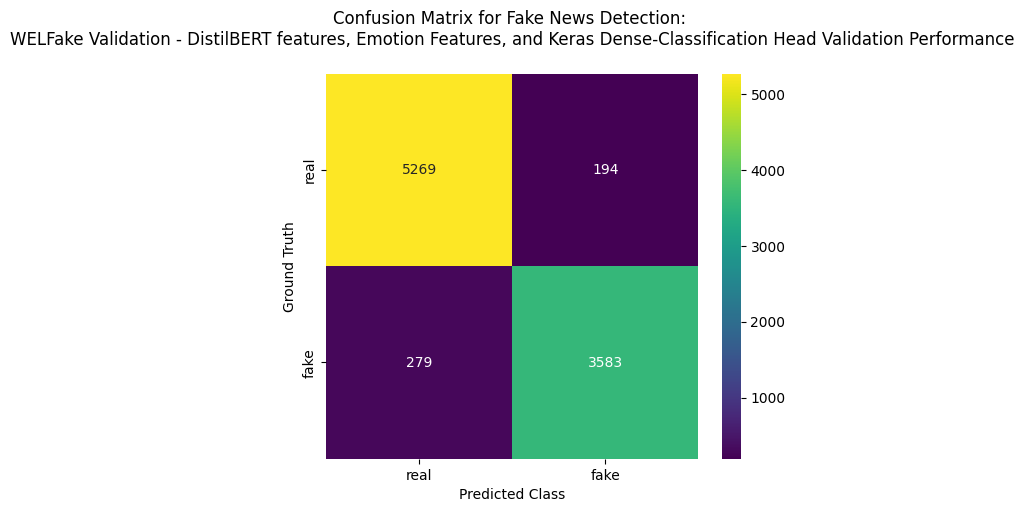

352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
Accuracy: 0.9507
Precision (Macro): 0.9488
Recall (Macro): 0.9462
Macro F1-score: 0.9475

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      6976
           1       0.94      0.93      0.93      4261

    accuracy                           0.95     11237
   macro avg       0.95      0.95      0.95     11237
weighted avg       0.95      0.95      0.95     11237



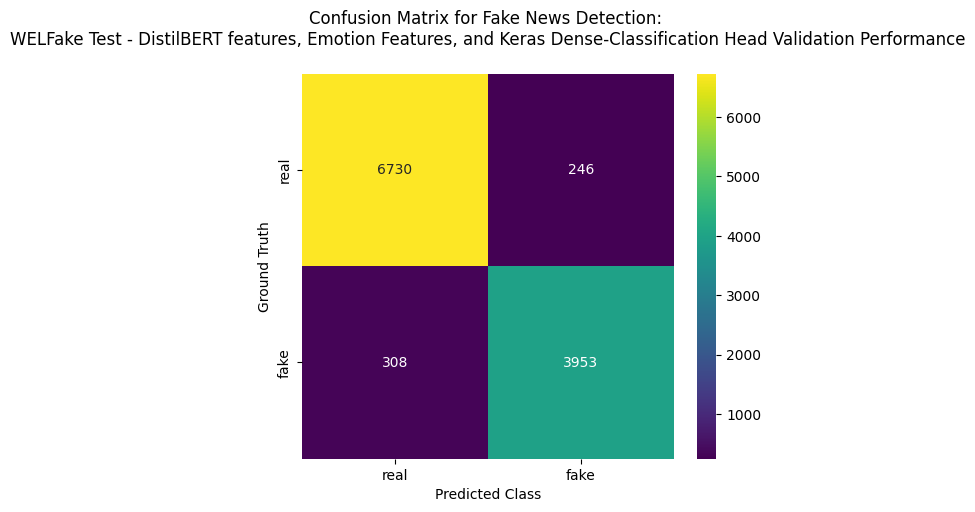

In [103]:
# Compiles the model using the number of features (787 = DistilBERT embeddings + xtra features) as input
wf_model = compileDenseKerasModel(wf_X_train_combined.shape[1])

# Defines the Early Stopping callback: stops training when validation loss plateaus for more than 10 epochs
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,              
    restore_best_weights=True # Restores the model weights from the best epoch for the final saved model
)

wf_history, wf_model = trainDenseLayerModel(wf_model, wf_X_train_combined, wf_y_train_one_hot, early_stopping)

# Evaluates the model on the WELFake validation set
wf_val_confusion_matrix_title = """
WELFake Validation - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
wf_val_dense_dict = evaluateDenseModel(wf_model, wf_X_val_combined, wf_y_val_one_hot, wf_y_val, wf_val_confusion_matrix_title)

# Evaluates the model on the WELFake test set
wf_test_confusion_matrix_title = """
WELFake Test - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
wf_test_dense_dict = evaluateDenseModel(wf_model, wf_X_test_combined, wf_y_test_one_hot, wf_y_test, wf_test_confusion_matrix_title)

### Fakeddit

Epoch 1/100
8101/8101 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.8067 - f1_score: 0.8032 - loss: 0.4226 - val_accuracy: 0.8484 - val_f1_score: 0.8477 - val_loss: 0.3598
Epoch 2/100
8101/8101 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.8439 - f1_score: 0.8415 - loss: 0.3519 - val_accuracy: 0.8579 - val_f1_score: 0.8570 - val_loss: 0.3543
Epoch 3/100
8101/8101 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.8484 - f1_score: 0.8464 - loss: 0.3416 - val_accuracy: 0.8572 - val_f1_score: 0.8565 - val_loss: 0.3553
Epoch 4/100
8101/8101 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.8520 - f1_score: 0.8500 - loss: 0.3360 - val_accuracy: 0.8564 - val_f1_score: 0.8559 - val_loss: 0.3437
Epoch 5/100
8101/8101 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.8536 - f1_score: 0.8517 - loss: 0.3330 - val_accuracy: 0.8588 - val_f1_score: 0.8582 - val_loss: 0.3592
Epoch 6/100
8101/8101 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.8551 - f1_score: 0.8531 - loss: 0.3297 - val_accuracy: 0.851

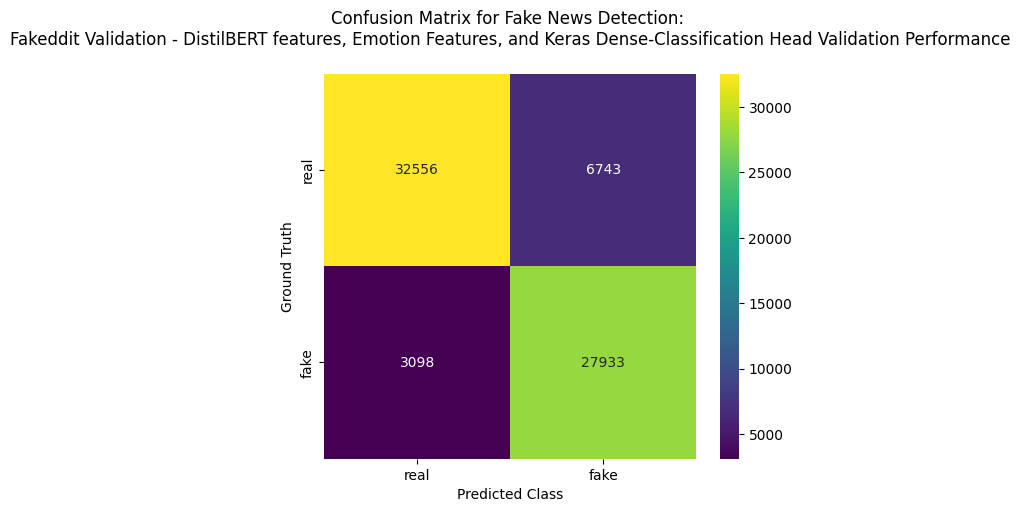

2222/2222 ━━━━━━━━━━━━━━━━━━━━ 1s 305us/step
Accuracy: 0.8596
Precision (Macro): 0.8587
Recall (Macro): 0.8641
Macro F1-score: 0.8589

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.83      0.87     39910
           1       0.80      0.90      0.85     31185

    accuracy                           0.86     71095
   macro avg       0.86      0.86      0.86     71095
weighted avg       0.87      0.86      0.86     71095



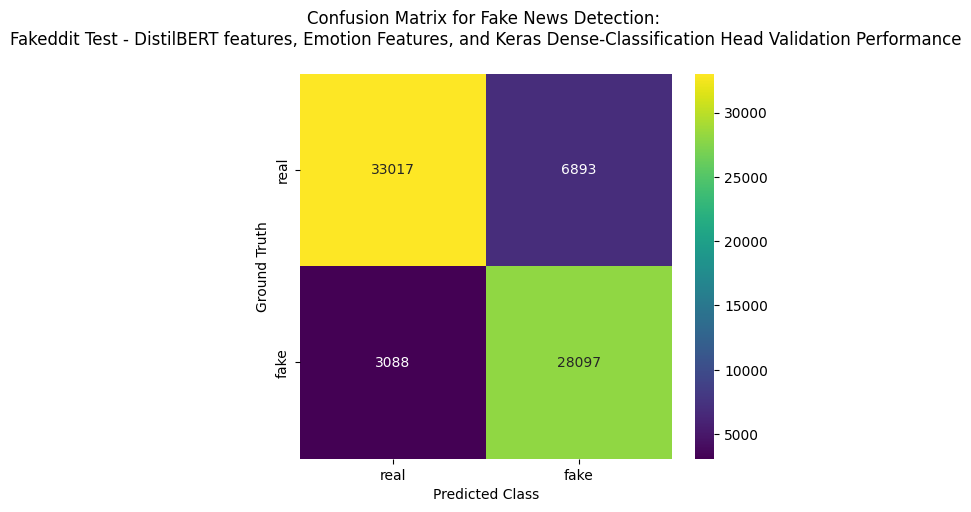

In [50]:
# Compiles the model using the number of features (787 = DistilBERT embeddings + xtra features) as input
fe_model = compileDenseKerasModel(fe_X_train_combined.shape[1])

# Defines the Early Stopping callback: stops training when validation loss plateaus for more than 10 epochs
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,              
    restore_best_weights=True # Restores the model weights from the best epoch for the final saved model
)

fe_history, fe_model = trainDenseLayerModel(fe_model, fe_X_train_combined, fe_y_train_one_hot, early_stopping)

# Evaluates the model on the Fakeddit validation set
fe_val_confusion_matrix_title = """
Fakeddit Validation - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
fe_val_dense_dict = evaluateDenseModel(fe_model, fe_X_val_combined, fe_y_val_one_hot, fe_y_val, fe_val_confusion_matrix_title)

# Evaluates the model on the Fakeddit test set
fe_test_confusion_matrix_title = """
Fakeddit Test - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
fe_test_dense_dict = evaluateDenseModel(fe_model, fe_X_test_combined, fe_y_test_one_hot, fe_y_test, fe_test_confusion_matrix_title)

### Constraint

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7001 - f1_score: 0.6980 - loss: 0.6011 - val_accuracy: 0.8777 - val_f1_score: 0.8775 - val_loss: 0.2870
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8887 - f1_score: 0.8882 - loss: 0.2853 - val_accuracy: 0.8879 - val_f1_score: 0.8876 - val_loss: 0.2714
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8987 - f1_score: 0.8983 - loss: 0.2560 - val_accuracy: 0.8997 - val_f1_score: 0.8997 - val_loss: 0.2474
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9091 - f1_score: 0.9088 - loss: 0.2330 - val_accuracy: 0.9216 - val_f1_score: 0.9216 - val_loss: 0.2181
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9132 - f1_score: 0.9129 - loss: 0.2192 - val_accuracy: 0.9177 - val_f1_score: 0.9177 - val_loss: 0.2158
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9217 - f1_score: 0.9215 - loss: 0.2078 - val_accuracy: 0.9036 - val_f1_score: 0.9035 - val

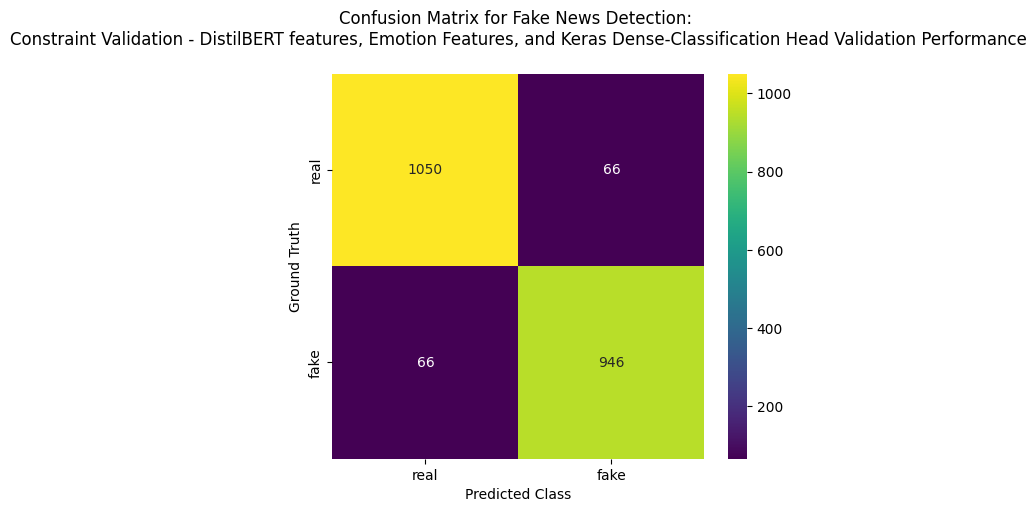

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step
Accuracy: 0.9378
Precision (Macro): 0.9376
Recall (Macro): 0.9377
Macro F1-score: 0.9376

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1115
           1       0.93      0.94      0.93      1007

    accuracy                           0.94      2122
   macro avg       0.94      0.94      0.94      2122
weighted avg       0.94      0.94      0.94      2122



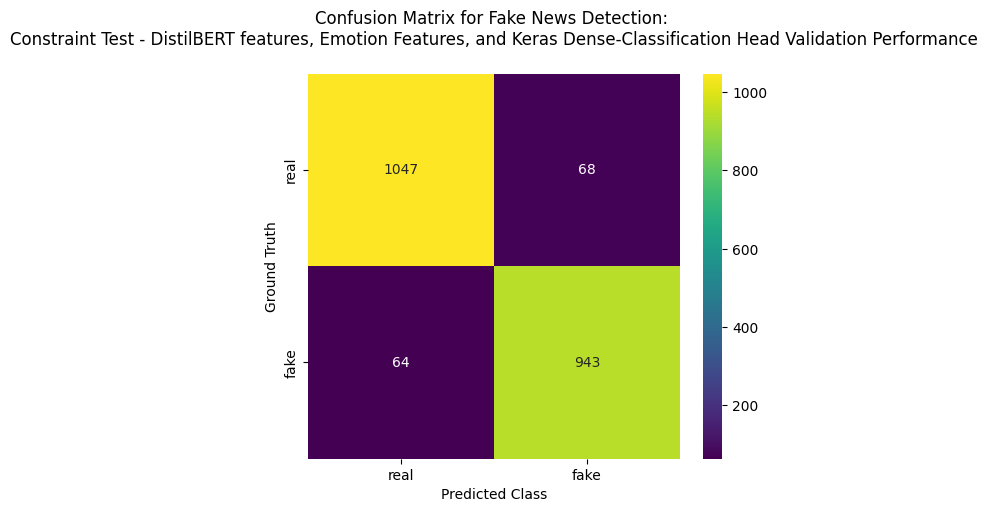

In [68]:
# Compiles the model using the number of features (787 = DistilBERT embeddings + extra features) as input
ct_model = compileDenseKerasModel(ct_X_train_combined.shape[1])

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,              
    restore_best_weights=True  # Restores the model weights from the best epoch for the final saved model
)

ct_history, ct_model = trainDenseLayerModel(ct_model, ct_X_train_combined, ct_y_train_one_hot, early_stopping)

# Evaluates the model on the Constraint validation set
ct_val_confusion_matrix_title = """
Constraint Validation - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
ct_val_dense_dict = evaluateDenseModel(ct_model, ct_X_val_combined, ct_y_val_one_hot, ct_y_val, ct_val_confusion_matrix_title)

# Evaluates the model on the Constraint test set
ct_test_confusion_matrix_title = """
Constraint Test - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
ct_test_dense_dict = evaluateDenseModel(ct_model, ct_X_test_combined, ct_y_test_one_hot, ct_y_test, ct_test_confusion_matrix_title)

### PolitiFact

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4494 - f1_score: 0.4444 - loss: 0.9609 - val_accuracy: 0.4545 - val_f1_score: 0.3125 - val_loss: 0.7371
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6070 - f1_score: 0.5623 - loss: 0.6884 - val_accuracy: 0.7614 - val_f1_score: 0.7470 - val_loss: 0.5976
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5838 - f1_score: 0.5833 - loss: 0.6554 - val_accuracy: 0.8068 - val_f1_score: 0.8068 - val_loss: 0.5647
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6668 - f1_score: 0.6568 - loss: 0.5998 - val_accuracy: 0.8409 - val_f1_score: 0.8402 - val_loss: 0.4739
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7937 - f1_score: 0.7914 - loss: 0.4934 - val_accuracy: 0.8523 - val_f1_score: 0.8513 - val_loss: 0.4249
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8075 - f1_score: 0.8071 - loss: 0.4445 - val_accuracy: 0.8409 - val_f1_score: 0.8406 - val_loss: 0.42

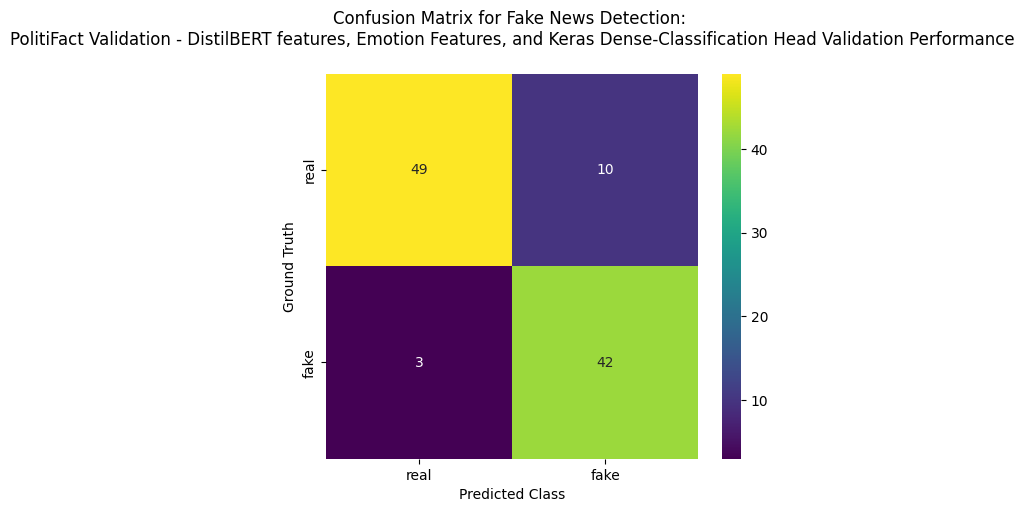

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.8730
Precision (Macro): 0.8749
Recall (Macro): 0.8719
Macro F1-score: 0.8725

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.84      0.86        61
           1       0.86      0.91      0.88        65

    accuracy                           0.87       126
   macro avg       0.87      0.87      0.87       126
weighted avg       0.87      0.87      0.87       126



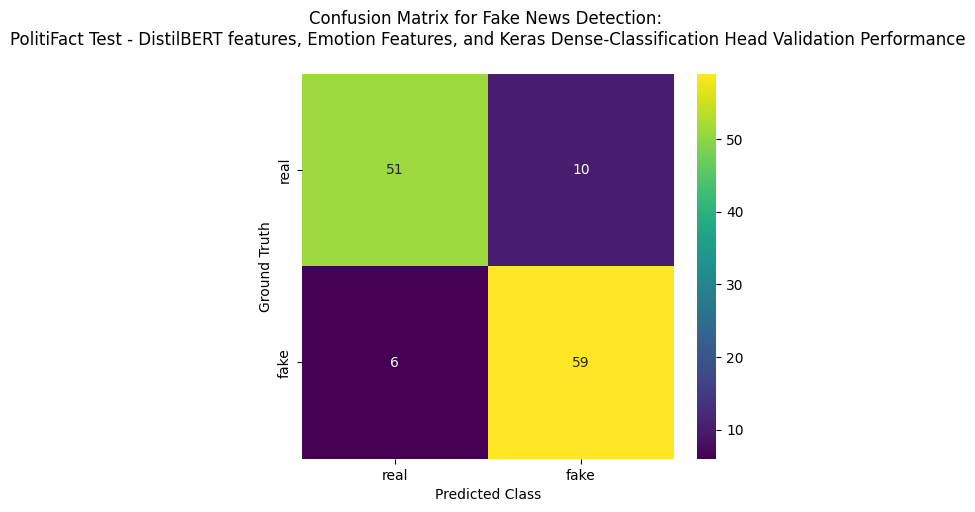

In [60]:
# Compiles the model using the number of features (787 = DistilBERT embeddings + extra features) as input
pf_model = compileDenseKerasModel(pf_X_train_combined.shape[1])

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,              
    restore_best_weights=True  # Restores the model weights from the best epoch for the final saved model
)

pf_history, pf_model = trainDenseLayerModel(pf_model, pf_X_train_combined, pf_y_train_one_hot, early_stopping)

# Evaluates the model on the PolitiFact validation set
pf_val_confusion_matrix_title = """
PolitiFact Validation - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
pf_val_dense_dict = evaluateDenseModel(pf_model, pf_X_val_combined, pf_y_val_one_hot, pf_y_val, pf_val_confusion_matrix_title)

# Evaluates the model on the PolitiFact test set
pf_test_confusion_matrix_title = """
PolitiFact Test - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
pf_test_dense_dict = evaluateDenseModel(pf_model, pf_X_test_combined, pf_y_test_one_hot, pf_y_test, pf_test_confusion_matrix_title)

### GossipCop

Epoch 1/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7083 - f1_score: 0.4709 - loss: 0.7230 - val_accuracy: 0.7863 - val_f1_score: 0.5665 - val_loss: 0.5028
Epoch 2/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7956 - f1_score: 0.5892 - loss: 0.4648 - val_accuracy: 0.8121 - val_f1_score: 0.7301 - val_loss: 0.4379
Epoch 3/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8246 - f1_score: 0.6939 - loss: 0.4272 - val_accuracy: 0.8334 - val_f1_score: 0.7398 - val_loss: 0.4236
Epoch 4/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8367 - f1_score: 0.7229 - loss: 0.4071 - val_accuracy: 0.8348 - val_f1_score: 0.7270 - val_loss: 0.4077
Epoch 5/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8389 - f1_score: 0.7272 - loss: 0.4031 - val_accuracy: 0.8366 - val_f1_score: 0.7428 - val_loss: 0.3995
Epoch 6/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8497 - f1_score: 0.7496 - loss: 0.3878 - val_accuracy: 0.8379 - val_f1_score: 

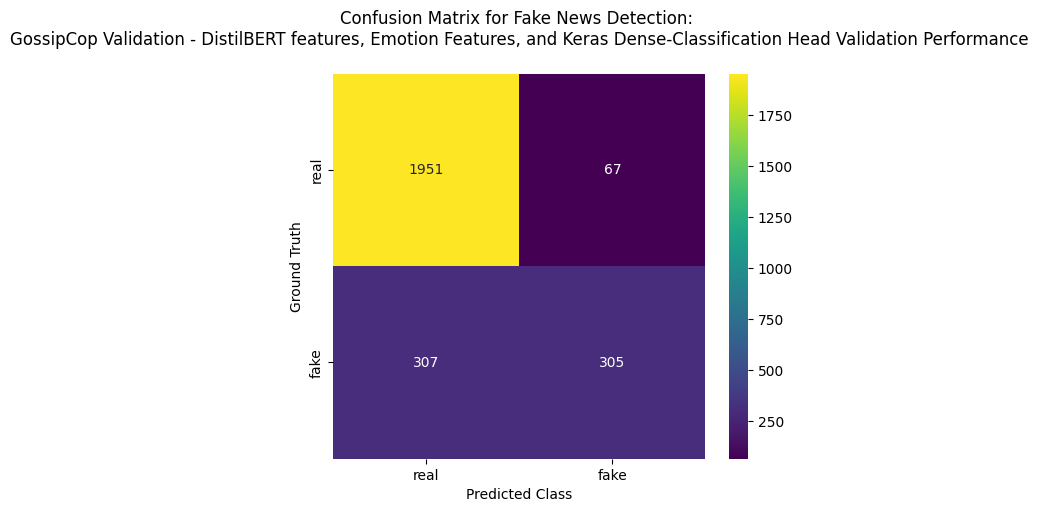

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.8425
Precision (Macro): 0.8085
Recall (Macro): 0.7193
Macro F1-score: 0.7476

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2444
           1       0.76      0.49      0.59       755

    accuracy                           0.84      3199
   macro avg       0.81      0.72      0.75      3199
weighted avg       0.83      0.84      0.83      3199



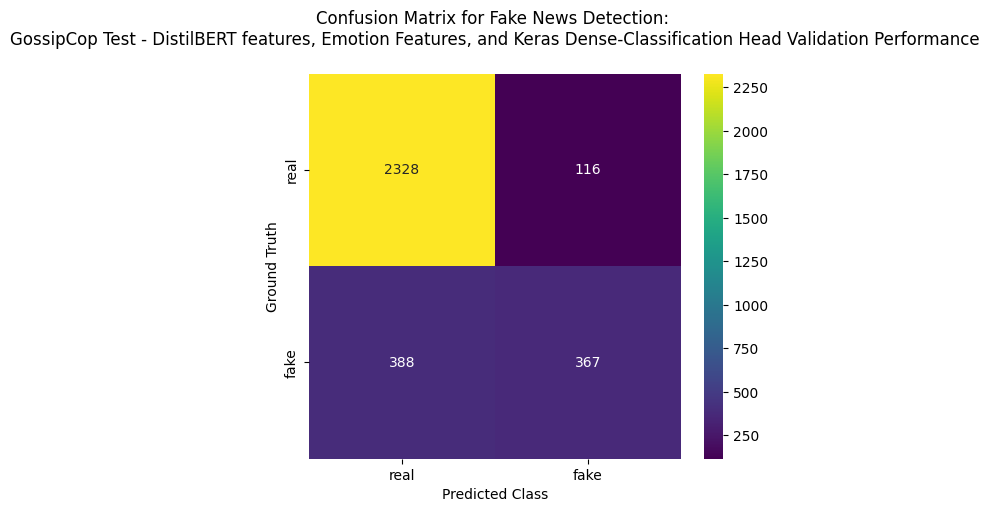

In [57]:
# Compiles the model using the number of features (787 = DistilBERT embeddings + extra features) as input
gc_model = compileDenseKerasModel(gc_X_train_combined.shape[1])

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,              
    restore_best_weights=True  # Restores the model weights from the best epoch for the final saved model
)

gc_history, gc_model = trainDenseLayerModel(gc_model, gc_X_train_combined, gc_y_train_one_hot, early_stopping)

# Evaluates the model on the GossipCop validation set
gc_val_confusion_matrix_title = """
GossipCop Validation - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
gc_val_dense_dict = evaluateDenseModel(gc_model, gc_X_val_combined, gc_y_val_one_hot, gc_y_val, gc_val_confusion_matrix_title)

# Evaluates the model on the GossipCop test set
gc_test_confusion_matrix_title = """
GossipCop Test - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
gc_test_dense_dict = evaluateDenseModel(gc_model, gc_X_test_combined, gc_y_test_one_hot, gc_y_test, gc_test_confusion_matrix_title)

### All-Four Combined

Epoch 1/100
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7297 - f1_score: 0.7153 - loss: 0.5247 - val_accuracy: 0.8666 - val_f1_score: 0.8593 - val_loss: 0.3015
Epoch 2/100
743/743 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8546 - f1_score: 0.8491 - loss: 0.3459 - val_accuracy: 0.8818 - val_f1_score: 0.8757 - val_loss: 0.2810
Epoch 3/100
743/743 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8629 - f1_score: 0.8580 - loss: 0.3223 - val_accuracy: 0.8903 - val_f1_score: 0.8865 - val_loss: 0.2703
Epoch 4/100
743/743 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8673 - f1_score: 0.8625 - loss: 0.3074 - val_accuracy: 0.8914 - val_f1_score: 0.8878 - val_loss: 0.2715
Epoch 5/100
743/743 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8689 - f1_score: 0.8639 - loss: 0.3039 - val_accuracy: 0.8938 - val_f1_score: 0.8905 - val_loss: 0.2696
Epoch 6/100
743/743 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8746 - f1_score: 0.8701 - loss: 0.2889 - val_accuracy: 0.8988 - val_f1_score: 

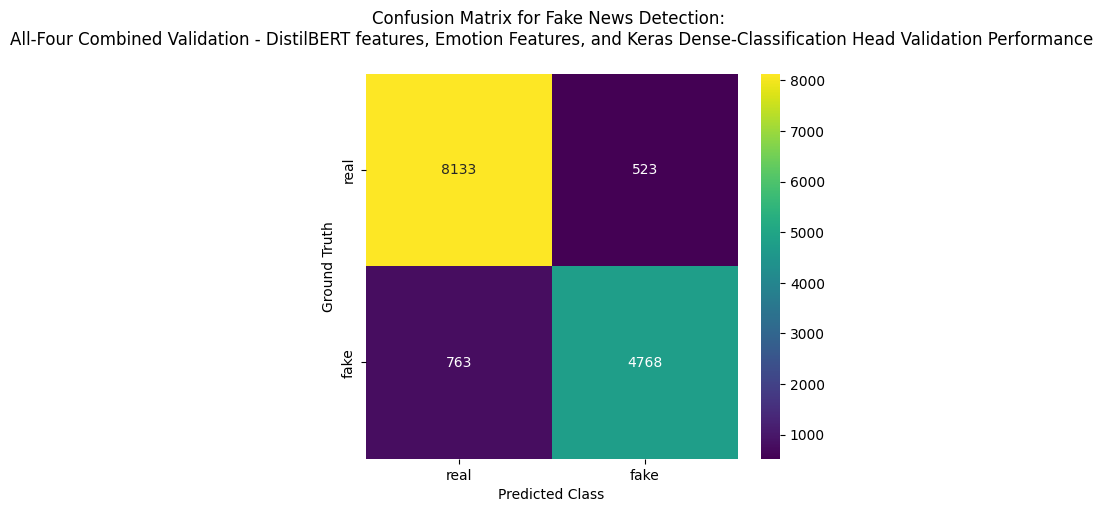

522/522 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
Accuracy: 0.9111
Precision (Macro): 0.9079
Recall (Macro): 0.8989
Macro F1-score: 0.9031

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     10596
           1       0.90      0.85      0.88      6087

    accuracy                           0.91     16683
   macro avg       0.91      0.90      0.90     16683
weighted avg       0.91      0.91      0.91     16683



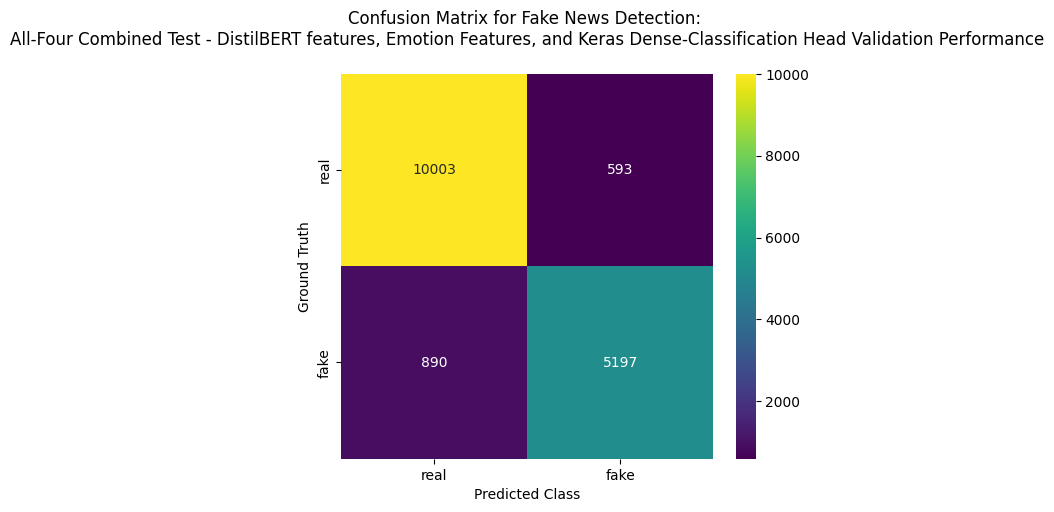

In [42]:
# Compiles the model using the number of features (787 = DistilBERT embeddings + extra features) as input
all_four_model = compileDenseKerasModel(all_four_X_train_combined.shape[1])

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,              
    restore_best_weights=True  # Restores the model weights from the best epoch for the final saved model
)

all_four_history, all_four_model = trainDenseLayerModel(all_four_model, all_four_X_train_combined, all_four_y_train_one_hot, early_stopping)

# Evaluates the model on the All-Four Combined validation set
all_four_val_confusion_matrix_title = """
All-Four Combined Validation - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
all_four_val_dense_dict = evaluateDenseModel(all_four_model, all_four_X_val_combined, all_four_y_val_one_hot, all_four_y_val, all_four_val_confusion_matrix_title)

# Evaluates the model on the All-Four Combined test set
all_four_test_confusion_matrix_title = """
All-Four Combined Test - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
all_four_test_dense_dict = evaluateDenseModel(all_four_model, all_four_X_test_combined, all_four_y_test_one_hot, all_four_y_test, all_four_test_confusion_matrix_title)

### Five-Shot: WELFake target

Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6955 - f1_score: 0.5934 - loss: 0.6178 - val_accuracy: 0.8130 - val_f1_score: 0.7862 - val_loss: 0.4323
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8094 - f1_score: 0.7656 - loss: 0.4397 - val_accuracy: 0.8385 - val_f1_score: 0.8077 - val_loss: 0.3862
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8282 - f1_score: 0.7906 - loss: 0.4062 - val_accuracy: 0.8320 - val_f1_score: 0.8112 - val_loss: 0.3932
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8376 - f1_score: 0.8018 - loss: 0.3917 - val_accuracy: 0.8488 - val_f1_score: 0.8185 - val_loss: 0.3632
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8415 - f1_score: 0.8067 - loss: 0.3767 - val_accuracy: 0.8499 - val_f1_score: 0.8217 - val_loss: 0.3547
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8372 - f1_score: 0.8017 - loss: 0.3840 - val_accuracy: 0.8474 - val_f1_score: 

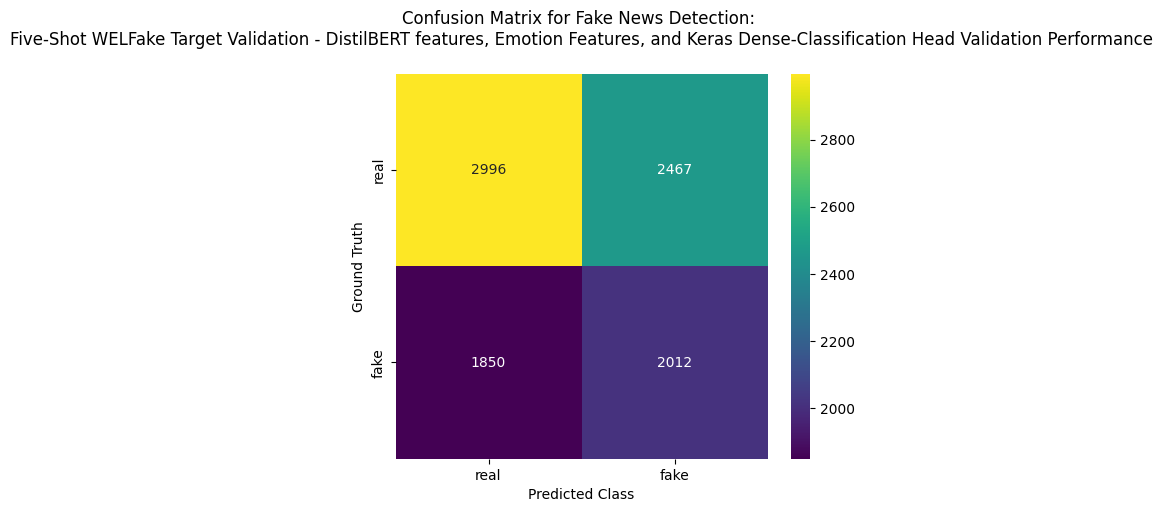

352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
Accuracy: 0.5400
Precision (Macro): 0.5334
Recall (Macro): 0.5353
Macro F1-score: 0.5296

Classification Report:

              precision    recall  f1-score   support

           0       0.65      0.55      0.60      6976
           1       0.41      0.52      0.46      4261

    accuracy                           0.54     11237
   macro avg       0.53      0.54      0.53     11237
weighted avg       0.56      0.54      0.55     11237



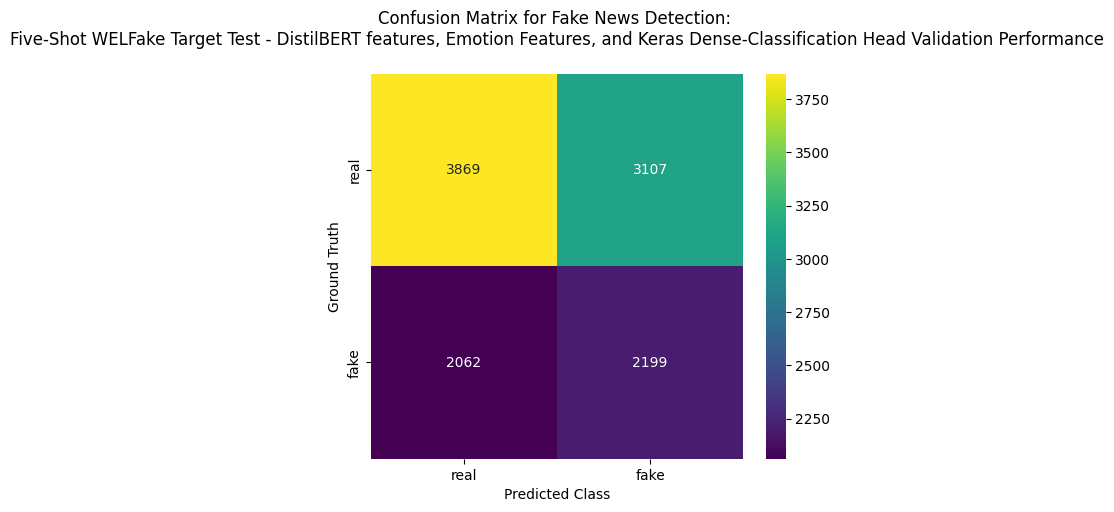

In [119]:
# Compiles the model using the number of features (787 = DistilBERT embeddings + xtra features) as input
five_shot_wf_model = compileDenseKerasModel(wf_target_five_shot_X_train_combined.shape[1])
five_shot_wf_history, five_shot_wf_model = trainDenseLayerModel(five_shot_wf_model, wf_target_five_shot_X_train_combined, wf_target_five_shot_y_train_one_hot, early_stopping)

# Evaluates the model on the WELFake validation set
five_shot_wf_val_confusion_matrix_title = """
Five-Shot WELFake Target Validation - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
five_shot_wf_val_dense_dict = evaluateDenseModel(five_shot_wf_model, wf_X_val_combined, wf_y_val_one_hot, wf_y_val, five_shot_wf_val_confusion_matrix_title)

# Evaluates the model on the WELFake test set
five_shot_wf_test_confusion_matrix_title = """
Five-Shot WELFake Target Test - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
five_shot_wf_test_dense_dict = evaluateDenseModel(five_shot_wf_model, wf_X_test_combined, wf_y_test_one_hot, wf_y_test, five_shot_wf_test_confusion_matrix_title)

### Five-Shot: Constraint target

Epoch 1/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7487 - f1_score: 0.7375 - loss: 0.5025 - val_accuracy: 0.8724 - val_f1_score: 0.8671 - val_loss: 0.3014
Epoch 2/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8574 - f1_score: 0.8519 - loss: 0.3342 - val_accuracy: 0.8795 - val_f1_score: 0.8755 - val_loss: 0.2814
Epoch 3/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8695 - f1_score: 0.8649 - loss: 0.3094 - val_accuracy: 0.8939 - val_f1_score: 0.8902 - val_loss: 0.2569
Epoch 4/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8704 - f1_score: 0.8661 - loss: 0.3077 - val_accuracy: 0.8954 - val_f1_score: 0.8917 - val_loss: 0.2617
Epoch 5/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8666 - f1_score: 0.8627 - loss: 0.3066 - val_accuracy: 0.8954 - val_f1_score: 0.8916 - val_loss: 0.2550
Epoch 6/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8762 - f1_score: 0.8725 - loss: 0.2900 - val_accuracy: 0.8975 - val_f1_score: 

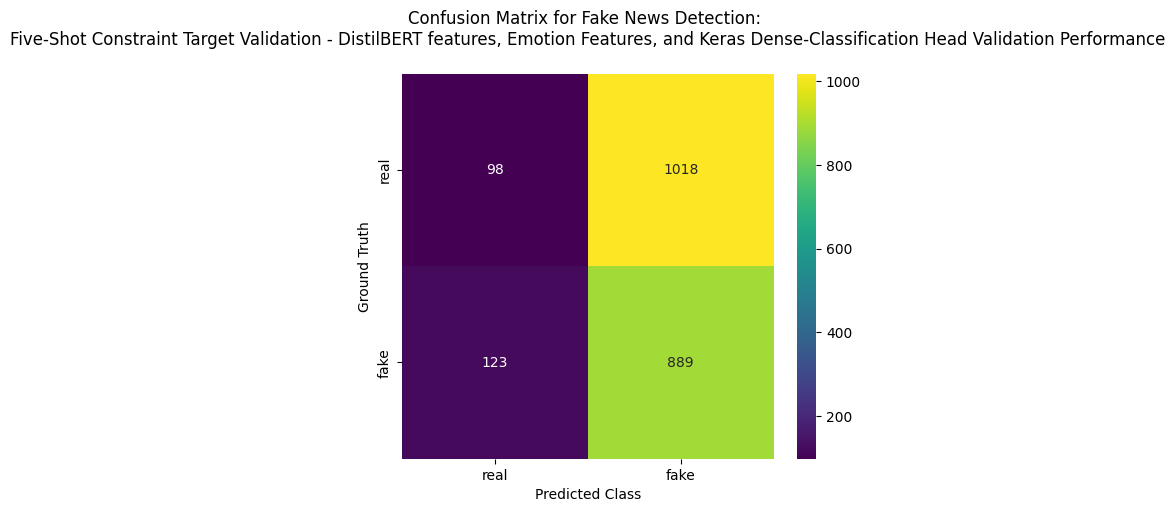

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
Accuracy: 0.4826
Precision (Macro): 0.5087
Recall (Macro): 0.5031
Macro F1-score: 0.3968

Classification Report:

              precision    recall  f1-score   support

           0       0.54      0.10      0.17      1115
           1       0.48      0.91      0.62      1007

    accuracy                           0.48      2122
   macro avg       0.51      0.50      0.40      2122
weighted avg       0.51      0.48      0.39      2122



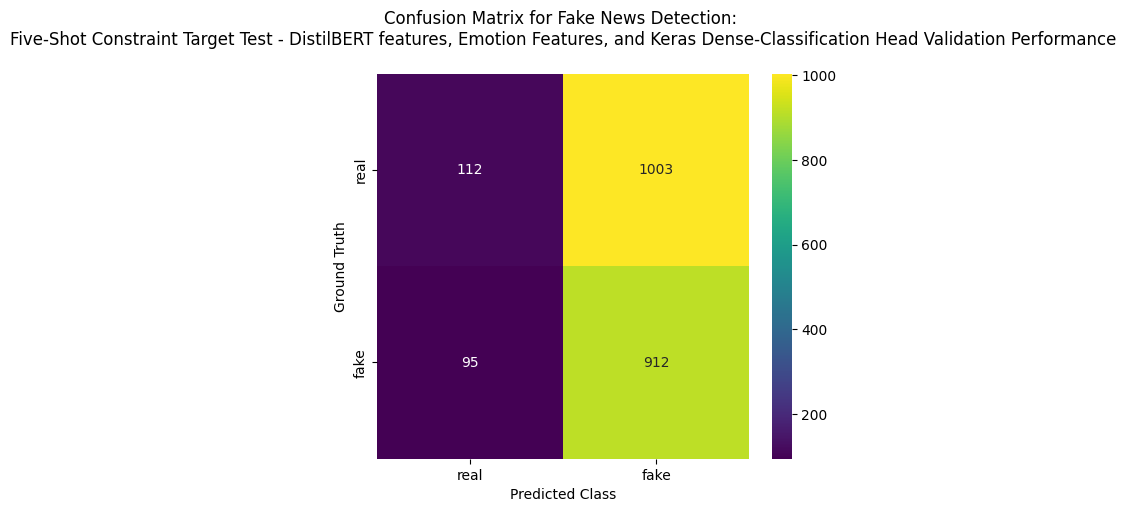

In [69]:
# Compiles the model using the number of features (787 = DistilBERT embeddings + xtra features) as input
five_shot_ct_model = compileDenseKerasModel(ct_target_five_shot_X_train_combined.shape[1])
five_shot_ct_history, five_shot_ct_model = trainDenseLayerModel(five_shot_ct_model, ct_target_five_shot_X_train_combined, ct_target_five_shot_y_train_one_hot, early_stopping)

# Evaluates the model on the Constraint validation set
five_shot_ct_val_confusion_matrix_title = """
Five-Shot Constraint Target Validation - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
five_shot_ct_val_dense_dict = evaluateDenseModel(five_shot_ct_model, ct_X_val_combined, ct_y_val_one_hot, ct_y_val, five_shot_ct_val_confusion_matrix_title)

# Evaluates the model on the Constraint test set
five_shot_ct_test_confusion_matrix_title = """
Five-Shot Constraint Target Test - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
five_shot_ct_test_dense_dict = evaluateDenseModel(five_shot_ct_model, ct_X_test_combined, ct_y_test_one_hot, ct_y_test, five_shot_ct_test_confusion_matrix_title)


### Five-Shot: PolitiFact target

Epoch 1/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7339 - f1_score: 0.7178 - loss: 0.5183 - val_accuracy: 0.8696 - val_f1_score: 0.8631 - val_loss: 0.3078
Epoch 2/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8464 - f1_score: 0.8408 - loss: 0.3518 - val_accuracy: 0.8856 - val_f1_score: 0.8813 - val_loss: 0.2803
Epoch 3/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8559 - f1_score: 0.8513 - loss: 0.3360 - val_accuracy: 0.8938 - val_f1_score: 0.8895 - val_loss: 0.2840
Epoch 4/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8653 - f1_score: 0.8609 - loss: 0.3158 - val_accuracy: 0.8877 - val_f1_score: 0.8851 - val_loss: 0.3023
Epoch 5/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8687 - f1_score: 0.8649 - loss: 0.3101 - val_accuracy: 0.8941 - val_f1_score: 0.8907 - val_loss: 0.2856
Epoch 6/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8784 - f1_score: 0.8746 - loss: 0.2866 - val_accuracy: 0.8946 - val_f1_score: 

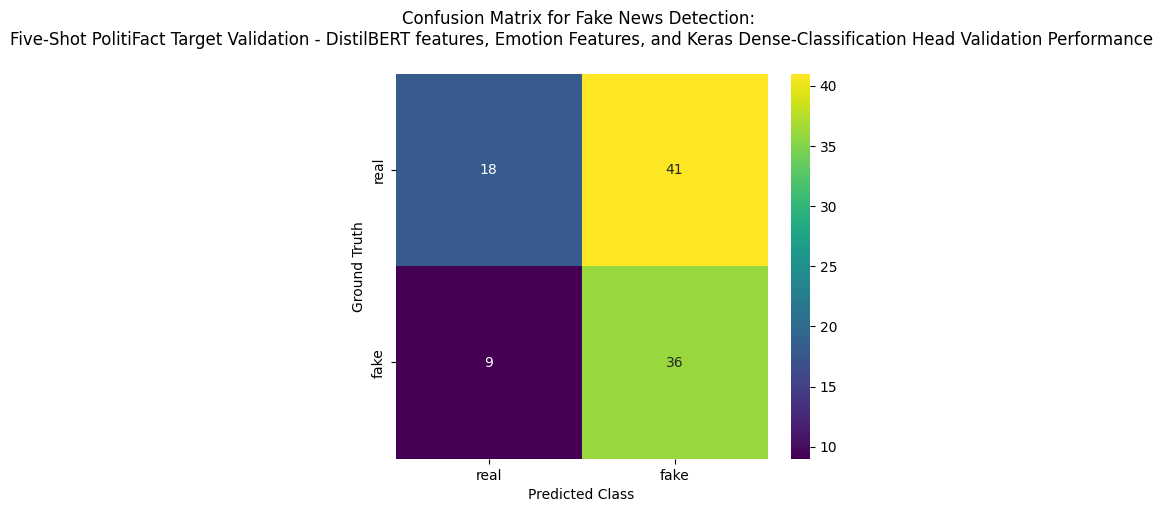

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.5556
Precision (Macro): 0.5640
Recall (Macro): 0.5475
Macro F1-score: 0.5207

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.30      0.39        61
           1       0.55      0.80      0.65        65

    accuracy                           0.56       126
   macro avg       0.56      0.55      0.52       126
weighted avg       0.56      0.56      0.52       126



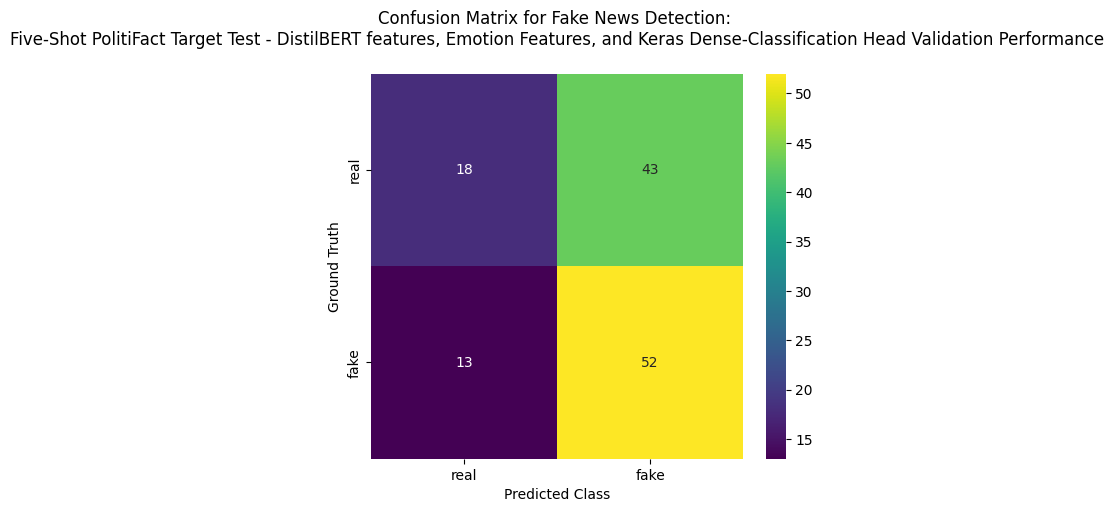

In [68]:
# Compiles the model using the number of features (787 = DistilBERT embeddings + xtra features) as input
five_shot_pf_model = compileDenseKerasModel(pf_target_five_shot_X_train_combined.shape[1])
five_shot_pf_history, five_shot_pf_model = trainDenseLayerModel(five_shot_pf_model, pf_target_five_shot_X_train_combined, pf_target_five_shot_y_train_one_hot, early_stopping)

# Evaluates the model on the PolitiFact validation set
five_shot_pf_val_confusion_matrix_title = """
Five-Shot PolitiFact Target Validation - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
five_shot_pf_val_dense_dict = evaluateDenseModel(five_shot_pf_model, pf_X_val_combined, pf_y_val_one_hot, pf_y_val, five_shot_pf_val_confusion_matrix_title)

# Evaluates the model on the PolitiFact test set
five_shot_pf_test_confusion_matrix_title = """
Five-Shot PolitiFact Target Test - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
five_shot_pf_test_dense_dict = evaluateDenseModel(five_shot_pf_model, pf_X_test_combined, pf_y_test_one_hot, pf_y_test, five_shot_pf_test_confusion_matrix_title)

### Five-Shot: GossipCop target

Epoch 1/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7772 - f1_score: 0.7750 - loss: 0.4692 - val_accuracy: 0.9036 - val_f1_score: 0.9032 - val_loss: 0.2455
Epoch 2/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8831 - f1_score: 0.8824 - loss: 0.2848 - val_accuracy: 0.9145 - val_f1_score: 0.9141 - val_loss: 0.2163
Epoch 3/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8932 - f1_score: 0.8927 - loss: 0.2649 - val_accuracy: 0.9170 - val_f1_score: 0.9169 - val_loss: 0.2079
Epoch 4/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8944 - f1_score: 0.8941 - loss: 0.2521 - val_accuracy: 0.9260 - val_f1_score: 0.9256 - val_loss: 0.1987
Epoch 5/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9006 - f1_score: 0.9002 - loss: 0.2365 - val_accuracy: 0.9273 - val_f1_score: 0.9268 - val_loss: 0.1972
Epoch 6/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9021 - f1_score: 0.9017 - loss: 0.2324 - val_accuracy: 0.9285 - val_f1_score: 

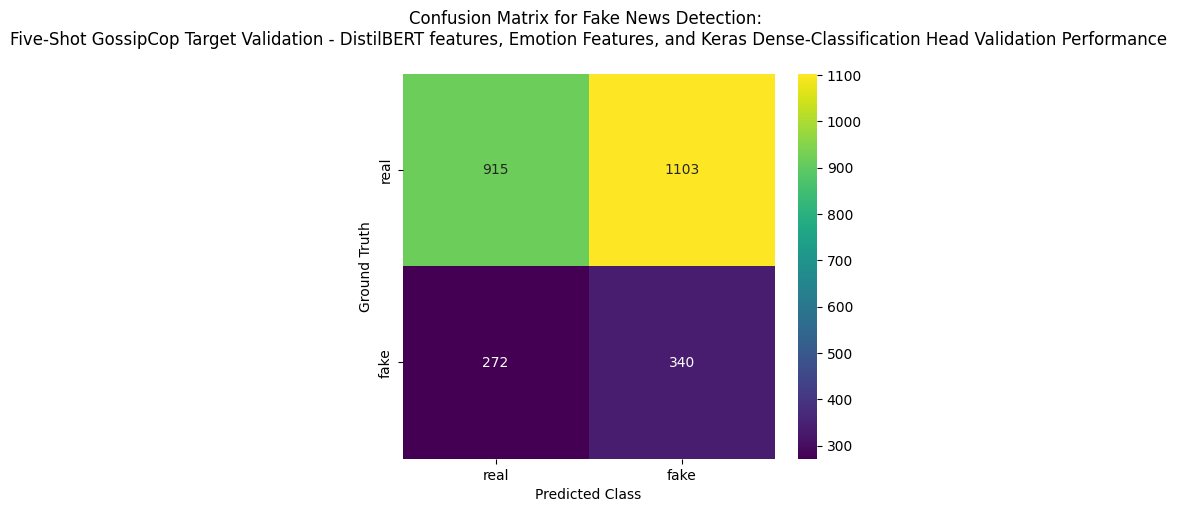

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step
Accuracy: 0.4767
Precision (Macro): 0.5047
Recall (Macro): 0.5065
Macro F1-score: 0.4523

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.45      0.57      2444
           1       0.24      0.56      0.34       755

    accuracy                           0.48      3199
   macro avg       0.50      0.51      0.45      3199
weighted avg       0.64      0.48      0.51      3199



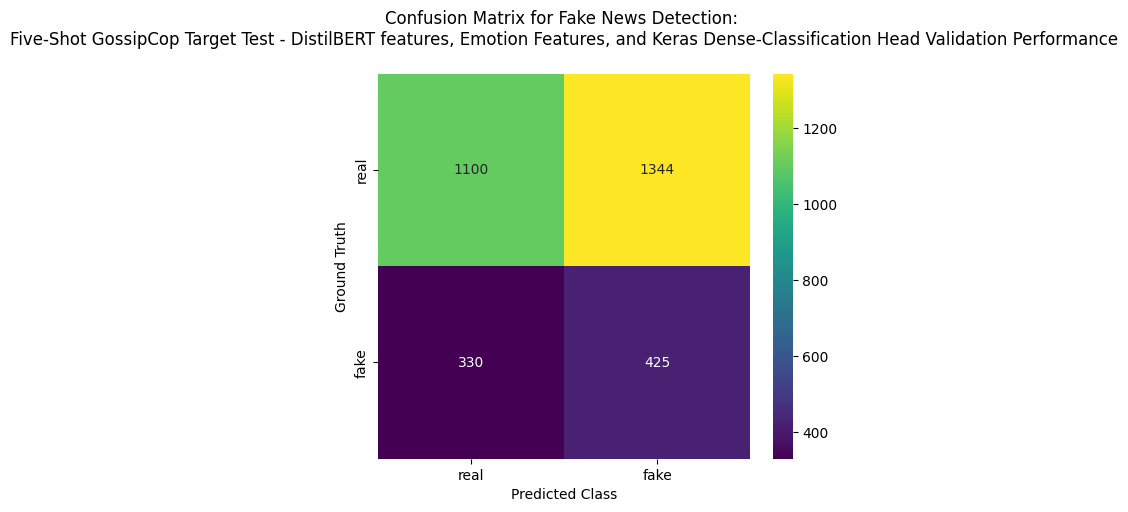

In [59]:
# Compiles the model using the number of features (787 = DistilBERT embeddings + xtra features) as input
five_shot_gc_model = compileDenseKerasModel(gc_target_five_shot_X_train_combined.shape[1])
five_shot_gc_history, five_shot_gc_model = trainDenseLayerModel(five_shot_gc_model, gc_target_five_shot_X_train_combined, gc_target_five_shot_y_train_one_hot, early_stopping)

# Evaluates the model on the GossipCop validation set
five_shot_gc_val_confusion_matrix_title = """
Five-Shot GossipCop Target Validation - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
five_shot_gc_val_dense_dict = evaluateDenseModel(five_shot_gc_model, gc_X_val_combined, gc_y_val_one_hot, gc_y_val, five_shot_gc_val_confusion_matrix_title)

# Evaluates the model on the GossipCop test set
five_shot_gc_test_confusion_matrix_title = """
Five-Shot GossipCop Target Test - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
five_shot_gc_test_dense_dict = evaluateDenseModel(five_shot_gc_model, gc_X_test_combined, gc_y_test_one_hot, gc_y_test, five_shot_gc_test_confusion_matrix_title)

### Zero-Shot: WELFake target

Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7031 - f1_score: 0.6081 - loss: 0.6116 - val_accuracy: 0.8289 - val_f1_score: 0.7990 - val_loss: 0.4163
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8099 - f1_score: 0.7688 - loss: 0.4343 - val_accuracy: 0.8353 - val_f1_score: 0.8091 - val_loss: 0.3942
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8305 - f1_score: 0.7963 - loss: 0.4091 - val_accuracy: 0.8451 - val_f1_score: 0.8193 - val_loss: 0.3740
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8374 - f1_score: 0.8046 - loss: 0.3869 - val_accuracy: 0.8289 - val_f1_score: 0.8066 - val_loss: 0.3973
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8407 - f1_score: 0.8079 - loss: 0.3836 - val_accuracy: 0.8482 - val_f1_score: 0.8233 - val_loss: 0.3612
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8434 - f1_score: 0.8107 - loss: 0.3866 - val_accuracy: 0.8586 - val_f1_score: 

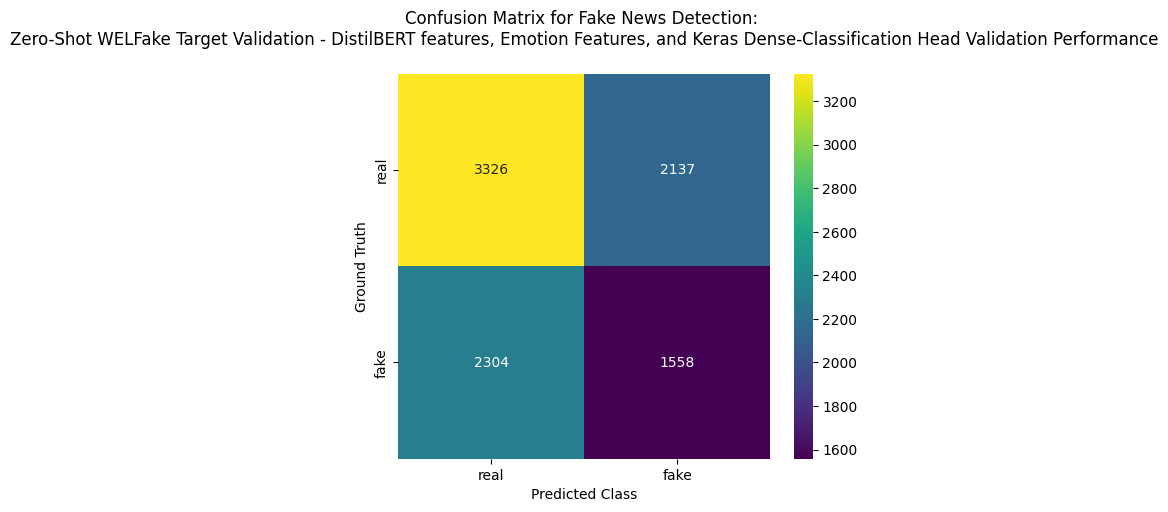

352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
Accuracy: 0.5273
Precision (Macro): 0.5020
Recall (Macro): 0.5021
Macro F1-score: 0.5019

Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.61      0.61      6976
           1       0.38      0.40      0.39      4261

    accuracy                           0.53     11237
   macro avg       0.50      0.50      0.50     11237
weighted avg       0.53      0.53      0.53     11237



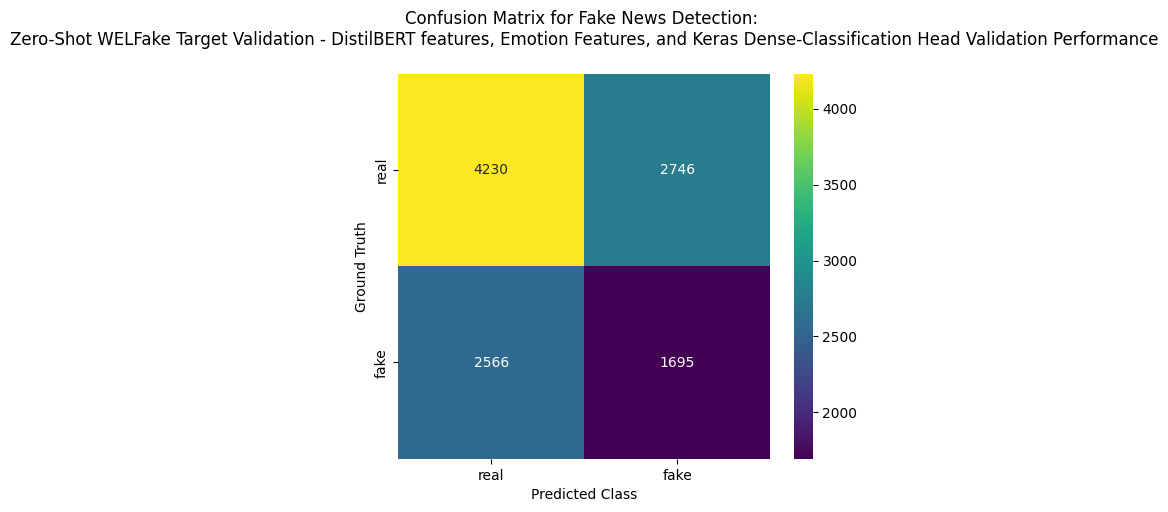

In [128]:
# Compiles the model using the number of features (787 = DistilBERT embeddings + xtra features) as input
zero_shot_wf_model = compileDenseKerasModel(wf_target_zero_shot_X_train_combined.shape[1])

zero_shot_wf_history, zero_shot_wf_model = trainDenseLayerModel(
    zero_shot_wf_model,
    wf_target_zero_shot_X_train_combined,
    wf_target_zero_shot_y_train_one_hot,
    early_stopping
)

# Evaluates the model on the WELFake test set
zero_shot_wf_val_confusion_matrix_title = """
Zero-Shot WELFake Target Validation - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
zero_shot_wf_val_dense_dict = evaluateDenseModel(
    zero_shot_wf_model, wf_X_val_combined, wf_y_val_one_hot, wf_y_val, zero_shot_wf_val_confusion_matrix_title
)

# Evaluates the model on the WELFake test set
zero_shot_wf_test_confusion_matrix_title = """
Zero-Shot WELFake Target Test - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Test Performance
"""
zero_shot_wf_test_dense_dict = evaluateDenseModel(
    zero_shot_wf_model, wf_X_test_combined, wf_y_test_one_hot, wf_y_test, zero_shot_wf_val_confusion_matrix_title
)

### Zero-Shot: Constraint Target

Epoch 1/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7524 - f1_score: 0.7406 - loss: 0.4997 - val_accuracy: 0.8750 - val_f1_score: 0.8689 - val_loss: 0.3053
Epoch 2/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8574 - f1_score: 0.8521 - loss: 0.3338 - val_accuracy: 0.8759 - val_f1_score: 0.8724 - val_loss: 0.3018
Epoch 3/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8640 - f1_score: 0.8586 - loss: 0.3156 - val_accuracy: 0.8923 - val_f1_score: 0.8875 - val_loss: 0.2661
Epoch 4/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8749 - f1_score: 0.8708 - loss: 0.2944 - val_accuracy: 0.8919 - val_f1_score: 0.8874 - val_loss: 0.2707
Epoch 5/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8747 - f1_score: 0.8701 - loss: 0.2897 - val_accuracy: 0.8964 - val_f1_score: 0.8928 - val_loss: 0.2623
Epoch 6/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8788 - f1_score: 0.8753 - loss: 0.2880 - val_accuracy: 0.8952 - val_f1_score: 

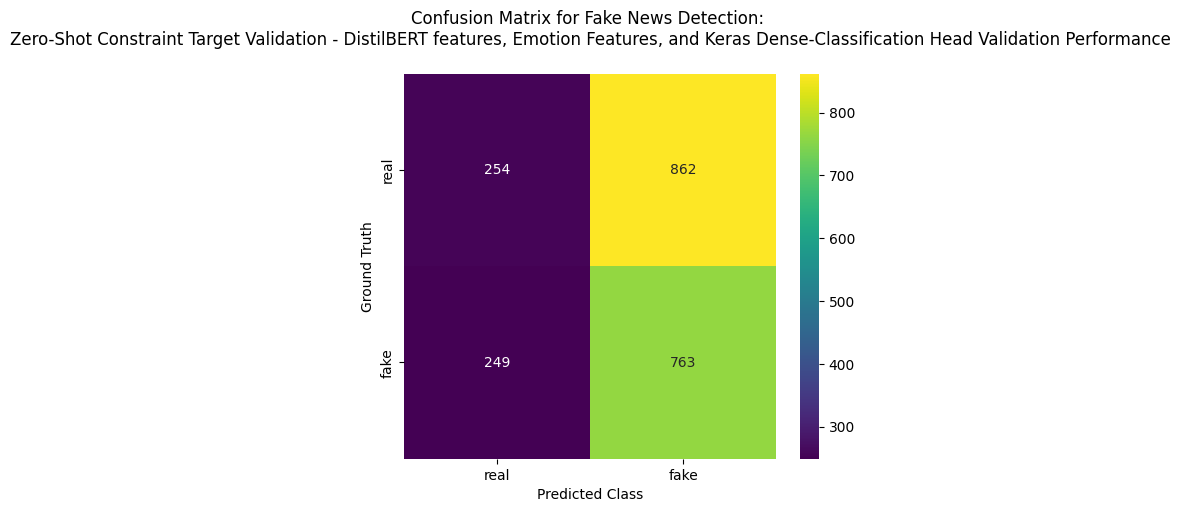

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step
Accuracy: 0.5005
Precision (Macro): 0.5229
Recall (Macro): 0.5152
Macro F1-score: 0.4631

Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.23      0.32      1115
           1       0.48      0.81      0.60      1007

    accuracy                           0.50      2122
   macro avg       0.52      0.52      0.46      2122
weighted avg       0.52      0.50      0.46      2122



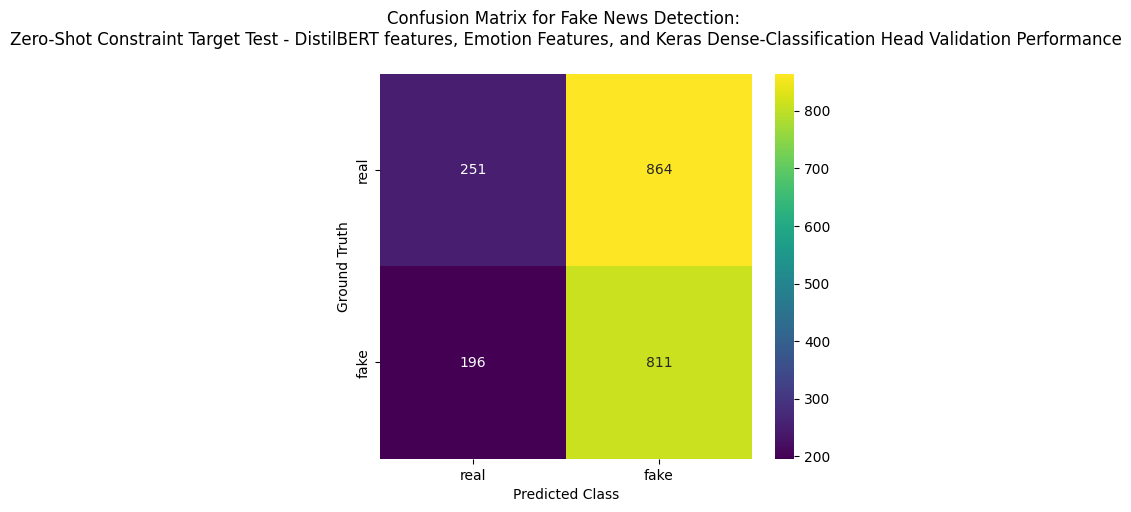

In [73]:
# Compiles the model using the number of features (787 = DistilBERT embeddings + xtra features) as input
zero_shot_ct_model = compileDenseKerasModel(ct_target_zero_shot_X_train_combined.shape[1])

zero_shot_ct_history, zero_shot_ct_model = trainDenseLayerModel(
    zero_shot_ct_model,
    ct_target_zero_shot_X_train_combined,
    ct_target_zero_shot_y_train_one_hot,
    early_stopping
)

# Evaluates the model on the Constraint validation set
zero_shot_ct_val_confusion_matrix_title = """
Zero-Shot Constraint Target Validation - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
zero_shot_ct_val_dense_dict = evaluateDenseModel(zero_shot_ct_model, ct_X_val_combined, ct_y_val_one_hot, ct_y_val, zero_shot_ct_val_confusion_matrix_title)


# Evaluates the model on the Constraint test set
zero_shot_ct_test_confusion_matrix_title = """
Zero-Shot Constraint Target Test - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
zero_shot_ct_test_dense_dict = evaluateDenseModel(zero_shot_ct_model, ct_X_test_combined, ct_y_test_one_hot, ct_y_test, zero_shot_ct_test_confusion_matrix_title)

### Zero-Shot: PolitiFact Target

Epoch 1/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7466 - f1_score: 0.7336 - loss: 0.5036 - val_accuracy: 0.8591 - val_f1_score: 0.8489 - val_loss: 0.3196
Epoch 2/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8528 - f1_score: 0.8471 - loss: 0.3417 - val_accuracy: 0.8822 - val_f1_score: 0.8765 - val_loss: 0.2838
Epoch 3/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8570 - f1_score: 0.8517 - loss: 0.3302 - val_accuracy: 0.8805 - val_f1_score: 0.8735 - val_loss: 0.2960
Epoch 4/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8652 - f1_score: 0.8603 - loss: 0.3124 - val_accuracy: 0.8869 - val_f1_score: 0.8808 - val_loss: 0.2752
Epoch 5/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8676 - f1_score: 0.8633 - loss: 0.2989 - val_accuracy: 0.8893 - val_f1_score: 0.8847 - val_loss: 0.2733
Epoch 6/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8743 - f1_score: 0.8699 - loss: 0.2869 - val_accuracy: 0.8969 - val_f1_score: 

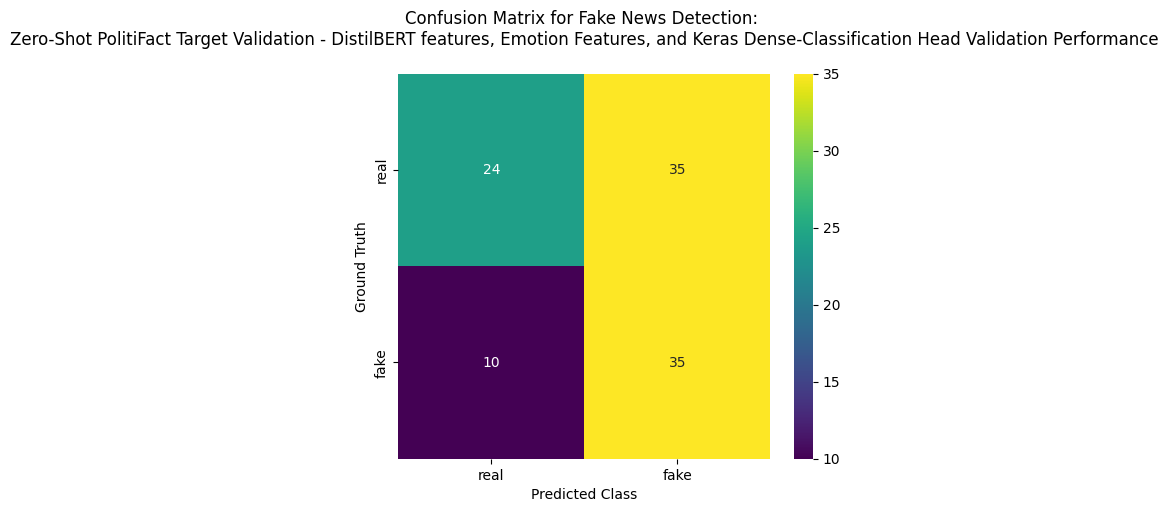

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.5556
Precision (Macro): 0.5640
Recall (Macro): 0.5475
Macro F1-score: 0.5207

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.30      0.39        61
           1       0.55      0.80      0.65        65

    accuracy                           0.56       126
   macro avg       0.56      0.55      0.52       126
weighted avg       0.56      0.56      0.52       126



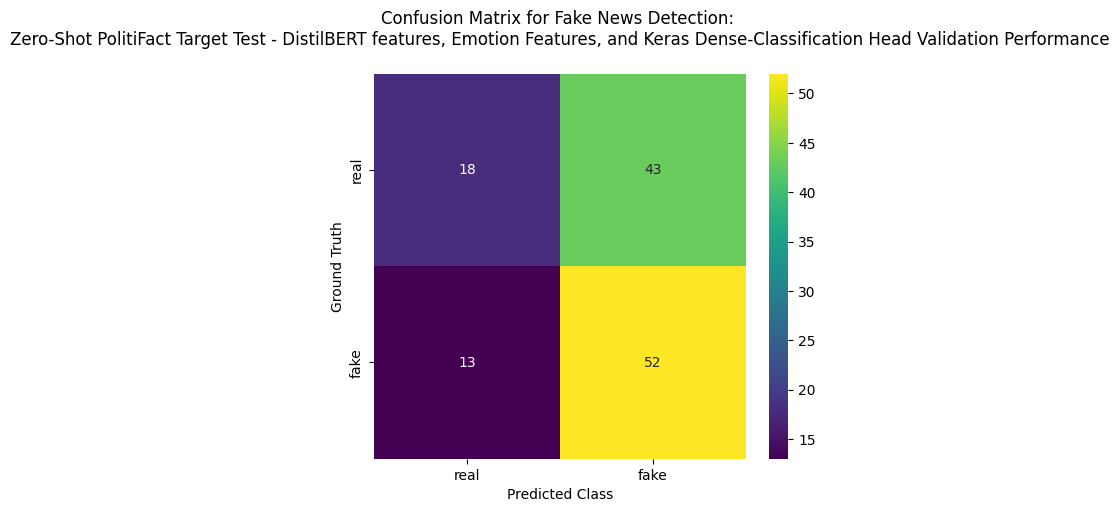

In [70]:
# Compiles the model using the number of features (787 = DistilBERT embeddings + xtra features) as input
zero_shot_pf_model = compileDenseKerasModel(pf_target_zero_shot_X_train_combined.shape[1])

zero_shot_pf_history, zero_shot_pf_model = trainDenseLayerModel(
    zero_shot_pf_model,
    pf_target_zero_shot_X_train_combined,
    pf_target_zero_shot_y_train_one_hot,
    early_stopping
)

# Evaluates the model on the PolitiFact validation set
zero_shot_pf_val_confusion_matrix_title = """
Zero-Shot PolitiFact Target Validation - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
zero_shot_pf_val_dense_dict = evaluateDenseModel(zero_shot_pf_model, pf_X_val_combined, pf_y_val_one_hot, pf_y_val, zero_shot_pf_val_confusion_matrix_title)


# Evaluates the model on the PolitiFact test set
zero_shot_pf_test_confusion_matrix_title = """
Zero-Shot PolitiFact Target Test - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
zero_shot_pf_test_dense_dict = evaluateDenseModel(zero_shot_pf_model, pf_X_test_combined, pf_y_test_one_hot, pf_y_test, zero_shot_pf_test_confusion_matrix_title)


### Zero-Shot: GossipCop target

Epoch 1/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7744 - f1_score: 0.7729 - loss: 0.4619 - val_accuracy: 0.9002 - val_f1_score: 0.8991 - val_loss: 0.2535
Epoch 2/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8834 - f1_score: 0.8829 - loss: 0.2793 - val_accuracy: 0.9175 - val_f1_score: 0.9170 - val_loss: 0.2171
Epoch 3/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8911 - f1_score: 0.8907 - loss: 0.2640 - val_accuracy: 0.9203 - val_f1_score: 0.9200 - val_loss: 0.2085
Epoch 4/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8984 - f1_score: 0.8980 - loss: 0.2468 - val_accuracy: 0.9268 - val_f1_score: 0.9263 - val_loss: 0.2009
Epoch 5/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9006 - f1_score: 0.9002 - loss: 0.2402 - val_accuracy: 0.9270 - val_f1_score: 0.9269 - val_loss: 0.2072
Epoch 6/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9098 - f1_score: 0.9094 - loss: 0.2229 - val_accuracy: 0.9214 - val_f1_score: 

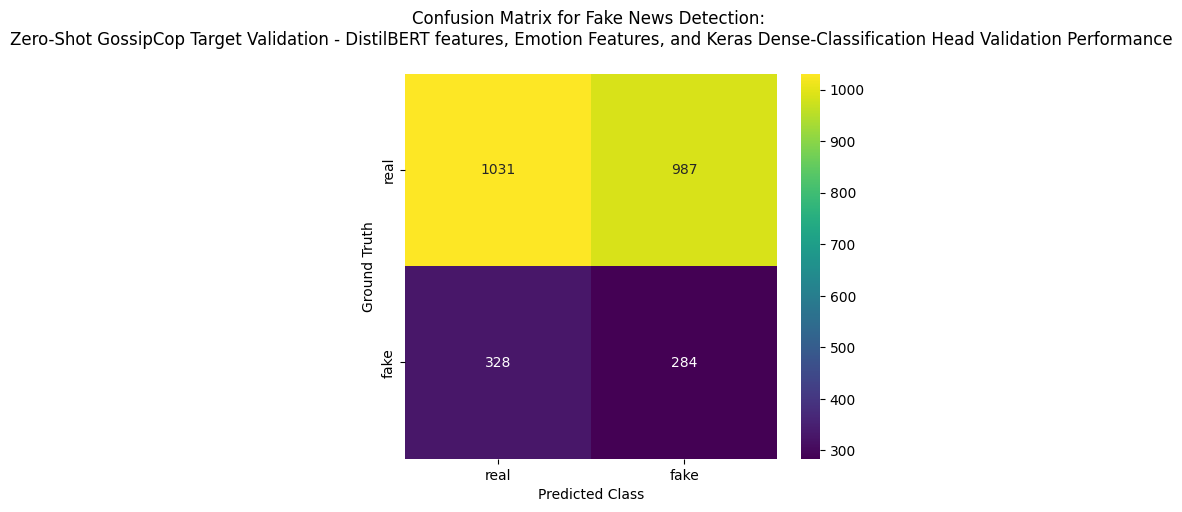

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
Accuracy: 0.5073
Precision (Macro): 0.5033
Recall (Macro): 0.5046
Macro F1-score: 0.4681

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.51      0.61      2444
           1       0.24      0.50      0.32       755

    accuracy                           0.51      3199
   macro avg       0.50      0.50      0.47      3199
weighted avg       0.64      0.51      0.54      3199



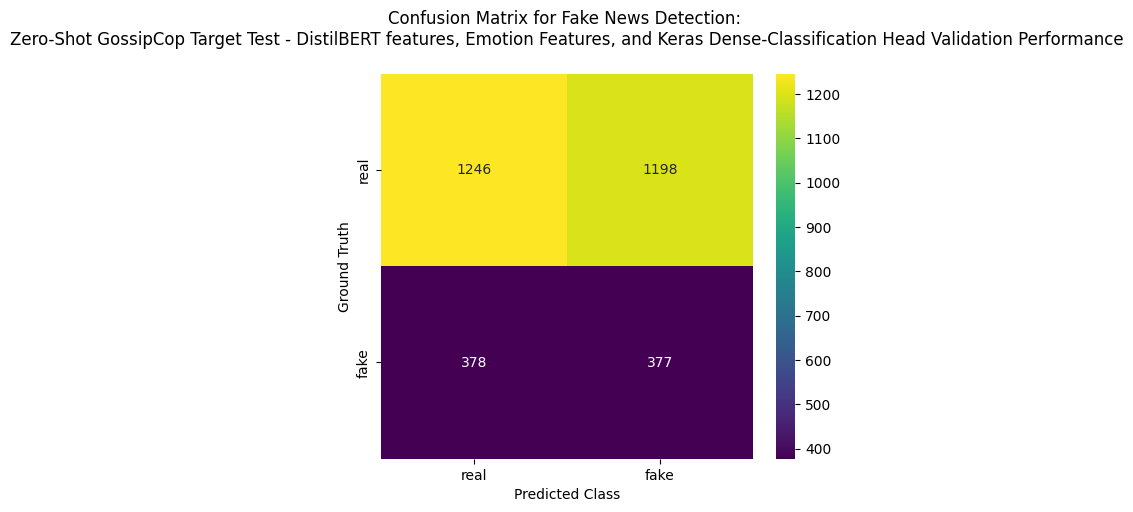

In [62]:
# Compiles the model using the number of features (787 = DistilBERT embeddings + xtra features) as input
zero_shot_gc_model = compileDenseKerasModel(gc_target_zero_shot_X_train_combined.shape[1])

zero_shot_gc_history, zero_shot_gc_model = trainDenseLayerModel(
    zero_shot_gc_model,
    gc_target_zero_shot_X_train_combined,
    gc_target_zero_shot_y_train_one_hot,
    early_stopping
)

# Evaluates the model on the GossipCop validation set
zero_shot_gc_val_confusion_matrix_title = """
Zero-Shot GossipCop Target Validation - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
zero_shot_gc_val_dense_dict = evaluateDenseModel(zero_shot_gc_model, gc_X_val_combined, gc_y_val_one_hot, gc_y_val, zero_shot_gc_val_confusion_matrix_title)


# Evaluates the model on the GossipCop test set
zero_shot_gc_test_confusion_matrix_title = """
Zero-Shot GossipCop Target Test - DistilBERT features, Emotion Features, and Keras Dense-Classification Head Validation Performance
"""
zero_shot_gc_test_dense_dict = evaluateDenseModel(zero_shot_gc_model, gc_X_test_combined, gc_y_test_one_hot, gc_y_test, zero_shot_gc_test_confusion_matrix_title)

## Results

## Full-Scale Scenario

### WELFake

| Dataset                                   | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |
|-------------------------------------------|----------|-------------------|----------------|----------------|
| WELFake (Validation)                      | 0.9493   | 0.9492            | 0.9461         | 0.9476         |
| WELFake (Test)                            | 0.9507   | 0.9488            | 0.9462         | 0.9475         |



### Fakeddit

| Dataset                                   | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |
|-------------------------------------------|----------|-------------------|----------------|----------------|
| Fakeddit (Validation)                     | 0.8601   | 0.8593            | 0.8643         | 0.8595         |
| Fakeddit (Test)                           | 0.8596   | 0.8587            | 0.8641         | 0.8589         |


### Constraint

| Dataset                                   | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |
|-------------------------------------------|----------|-------------------|----------------|----------------|
| Constraint (Validation)                   | 0.9380   | 0.9378            | 0.9378         | 0.9378         |
| Constraint (Test)                         | 0.9378   | 0.9376            | 0.9377         | 0.9376         |


### PolitiFact

| Dataset                                   | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |
|-------------------------------------------|----------|-------------------|----------------|----------------|
| PolitiFact (Validation)                   | 0.8750   | 0.8750            | 0.8819         | 0.8744         |
| PolitiFact (Test)                         | 0.8730   | 0.8749            | 0.8719         | 0.8725         |

### GossipCop

| Dataset                                   | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |
|-------------------------------------------|----------|-------------------|----------------|----------------|
| GossipCop (Validation)                    | 0.8578   | 0.8420            | 0.7326         | 0.7662         |
| GossipCop (Test)                          | 0.8425   | 0.8085            | 0.7193         | 0.7476         |


### All-Four Combined

| Dataset                                    | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |
|--------------------------------------------|----------|-------------------|----------------|----------------|
| All-Four Combined (Validation)             | 0.9094   | 0.9077            | 0.9008         | 0.9039         |
| All-Four Combined (Test)                   | 0.9111   | 0.9079            | 0.8989         | 0.9031         |

## Five-Shot Evaluation Scenario

### Five-Shot: WELFake target

| Dataset                                   | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |
|-------------------------------------------|----------|-------------------|----------------|----------------|
| Five-Shot (WELFake target - Validation)   | 0.5371   | 0.5337            | 0.5347         | 0.5318         |
| Five-Shot (WELFake target - Test)         | 0.5400   | 0.5334            | 0.5353         | 0.5296         |




### Five-Shot: Constraint target

| Dataset                                    | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |
|--------------------------------------------|----------|-------------------|----------------|----------------|
| Five-Shot (Constraint target - Validation) | 0.4638   | 0.4548            | 0.4831         | 0.3779         |
| Five-Shot (Constraint target - Test)       | 0.4826   | 0.5087            | 0.5031         | 0.3968         |

### Five-Shot: PolitiFact target

| Dataset                                         | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |
|-------------------------------------------------|----------|-------------------|----------------|----------------|
| Five-Shot (PolitiFact target - Validation)      | 0.5192   | 0.5671            | 0.5525         | 0.5044         |
| Five-Shot (PolitiFact target - Test)            | 0.5556   | 0.5640            | 0.5475         | 0.5207         |


### Five-Shot: GossipCop target

| Dataset                                             | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |
|-----------------------------------------------------|----------|-------------------|----------------|----------------|
| Five-Shot (GossipCop target - Validation)           | 0.4772   | 0.5032            | 0.5045         | 0.4509         |
| Five-Shot (GossipCop target - Test)                 | 0.4767   | 0.5047            | 0.5065         | 0.4523         |

## Zero-Shot Evaluation Scenario

### Zero-Shot: WELFake target

| Dataset                                              | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |
|------------------------------------------------------|----------|-------------------|----------------|----------------|
| Zero-Shot (WELFake target - Validation)              | 0.5238   | 0.5062            | 0.5061         | 0.5060         |
| Zero-Shot (WELFake target - Test)                    | 0.5273   | 0.5020            | 0.5021         | 0.5019         |



### Zero-Shot: Constraint target

| Dataset                                               | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |
|-------------------------------------------------------|----------|-------------------|----------------|----------------|
| Zero-Shot (Constraint target - Validation)            | 0.4779   | 0.4873            | 0.4908         | 0.4462         |
| Zero-Shot (Constraint target - Test)                  | 0.5005   | 0.5229            | 0.5152         | 0.4631         |


### Zero-Shot: PolitiFact target

| Dataset                                               | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |
|-------------------------------------------------------|----------|-------------------|----------------|----------------|
| Zero-Shot (PolitiFact target - Validation)            | 0.5673   | 0.6029            | 0.5923         | 0.5624         |
| Zero-Shot (PolitiFact target - Test)                  | 0.5556   | 0.5640            | 0.5475         | 0.5207         |


### Zero-Shot: GossipCop target

| Dataset                                               | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |
|-------------------------------------------------------|----------|-------------------|----------------|----------------|
| Zero-Shot (GossipCop target - Validation)             | 0.5000   | 0.4910            | 0.4875         | 0.4561         |
| Zero-Shot (GossipCop target - Test)                   | 0.5073   | 0.5033            | 0.5046         | 0.4681         |